# NOTEBOOK (#1): DATA EXPLANATION, CLEANING & PREPARATION

# TABLE OF CONTENTS

* Part One [Data Cleaning, Preparation & Explanation] (#PART_ONE)

* Part Two [Calculating PECDS (PAR EQUIVALENT CREDIT DEFAULT SWAP](#PART_TWO)

* Part Three [Descriptive Statistics Overview](#PART_THREE)

* Part Four [Regressions & Modelling]


* May wish to seperate out these sections into 4 seperate notebooks? 

In [ ]:
#look at appending bond trading data / CDS trading data to see if the constant issue with the cds spread == no trades? 

In [ ]:
#fixing up the statistics partS: 
#https://realpython.com/python-statistics/

#percentiles / range etc / skew / 
#E.G. see below ZA section 

In [ ]:
#import six
#six.MAXSIZE

In [ ]:
#import potential packages needed

In [1]:
#system packages

import sys
import warnings
import os 
import traceback #obs? 
if not sys.warnoptions:
    warnings.filterwarnings("once")  

In [2]:
#base packages:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats, integrate, optimize
import math
import datetime
from datetime import date, timedelta

In [3]:
#optional packages

from statsmodels.tsa.base.datetools import dates_from_str
from IPython.display import display
pd.options.display.max_columns = 60  #allow DF.head to show all columns in notebook
from see import see
from tabulate import tabulate 
#from io import StringIO

In [4]:
#packages for the econometrics / models

##statsmodels 
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.stattools import adfuller, zivot_andrews 
import statsmodels.formula.api as smf  #VAR package contained within 
import statsmodels.tsa.api as smt
#archpackage
from arch.unitroot import DFGLS, ADF, KPSS, PhillipsPerron, ZivotAndrews, VarianceRatio
from arch.unitroot.cointegration import engle_granger, phillips_ouliaris

#import the functionality for detecting mathematical errors (E.G. types of linear algebra issues etc.)
from statsmodels.tools.sm_exceptions import ValueWarning
from arch.utility.exceptions import (
    InfeasibleTestException,
    InvalidLengthWarning,
    invalid_length_doc)
warnings.filterwarnings("once", category = ValueWarning)

C:\Users\JasonSpano\anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [5]:
#pickle file: 
#sorted_alldata_df_final = pd.read_pickle("./sorted_alldata_df_final.pkl")

#sorted_alldata_df_final = pd.read_pickle(r"C:\Users\JasonSpano\OneDrive\Uva Msc 19-20 Subjects\Research Assistant Docs\CDS_project_-_first_set_of_tasks\Part 2_jan20./sorted_alldata_df_final.pkl")

In [6]:
#with ADF results: to be updated to VECM outcome (cointegration) eventually?
sorted_alldata_df_final_adf_results = pd.read_pickle("./sorted_alldata_df_final_adf_results.pkl")

#need to rename: ADF_test outcome + length == time differential? 

In [ ]:
#TBC:

#from statsmodels.iolib.summary2 import summary_col   #proably won't work as for panel reg
#https://stackoverflow.com/questions/54881902/generate-statistical-tables-in-python-and-export-to-excel

#from pystout import pystout
#!{sys.executable} -m pip install stargazer
#from stargazer.stargazer import Stargazer   #table/regression output package 

In [ ]:
cut data-cleaning to seperate document
keep regressions / modelling in seperate document: 
    
need to fix/edit actual document > export to PDF > reupload: 
check UvA for publication? 


#23.12.2020
#merged the two ZA frames
## 24.12: added normalised standard deviation 
## 24.12 TO DO: finish adding the descriptive statistics to the ZA-finalised frame E.g. inter-quantile range, etc. 
#see link in sectior or above:
### then, finalise the variance ratio test (or add this before, append to DF and then do the statistics???)



In [38]:
21.11.20
apply the [5,10,20] loop (from garch webpage code) in the variance ratio loop? report multiple results? 

17.11.2020
DFGLS - largely finished, just think about how to merge back onto "main DF" or just attach the sectors to that DF? (probs)
fix the ZA or consider cutting to seperate document? 
#add bond yield (raw) spread to CDS plots? 

try put the ZA test in the ADF looking code (from statsmodels) see link in ZA section: 
    use it to determine "break-points" in the code 
    try to convert that index location to date by GVKEY? 


problem with the groupby(std?) method?     
    
#see dict or sep ipynb doc. 
work on changing lists format to dictionaries, perk being it would preserve dtypes? 
do speed checks with np.column stack & dict format vs original? Compare and contrast? 
#https://arch.readthedocs.io/en/latest/_modules/arch/unitroot/unitroot.html#ADF
#looks like a function with return x(a,b,c,d) and then call after: x.a, x.b etc. 
#see:   https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html


#12.11.2020: TO DO: 

#change ADF to: ADF(BIC VS AIC) + DFGLS(BIC VS AIC) report in one table? 
#try to utilise dictionary outputs? 
#might allow the calculation of mean (lag lengths) by group? 

#make one DF with 3 tests? PP/ADF/DFGLS? 
#in current ADF, change VIX to >> ADF with trend==ct, compare "ct" and "c"? 

#ZIVOT_A: #move to single GVKEY primer?  #show a problem GVKEY VS non-problem GVKEY? (linalg error?)

#tidy up print out DFS from ADF and ZA sections: 

#see how to merge the boolean outcome for cointeg test back to main DF: update pickle file 

#try using different measure (AIC vs BIC) for lag lengths & results:

#try the PP coint test? Or trace vs eigenvalue explanation? 

#rerun the VaR / GCT with a boolean split for the cointregation / ADF test outcomes: 

#compare ratio of error groups to groupby(sector) ratio of total DF (ADF- ZA- COINT GVKEY issue groups are identical?)
#[check main file for the code?]

#create some ratio of: first-last date / total period? to see "structural breaks"


cointegrating examples: (good) statsmodels
#https://arch.readthedocs.io/en/latest/unitroot/unitroot_cointegration_examples.html
#http://rizaudinsahlan.blogspot.com/2017/09/johansen-cointegration-test-with-eviews_93.html

#4.11.2020: 
#clean up ZA test by (changing from C to CL + constant + trend) 
comment on the low std_dev of the groups

#email tomislav? ds skill + code publication + low stddev dropping? / unchronological / time-breaks etc. 
time breaks attributable to the "changing bond-code? happens when merging on GVKEY" - byproduct of long-horizon testing?

#consider: trying to wrap up a function of the multivariate coint test / ADF etc. ? 

#consider: moving data cleaning to seperate document? 




#see msvecm_1.02: breakdown of the VECM process explanation + links 

SyntaxError: invalid syntax (<ipython-input-38-9fa4add21636>, line 1)

## Table of Contents

1) Data Overview & Data Cleaning Process







* [Variance_Ratio_Test](#variance_ratio_test)

# Section 1.1) Data Overview

1) First data point is a .txt file (~10GB) of Bond Data, downloaded from Wharton Research/Data Services (WRDS): pertaining to TRACE bond trades for all regular bonds (senior bonds with fixed or zero coupons) issued by firms in Compustat. Observations are at the day-level
    * contains all bond trades between 2002 and June-2017
    * Data included is bond ID, cusip_id, exact trade date/time, traded price, quoted_yield
    
2) Second data point is Bond Maturities information (From TRACE) .txt file from WRDS, relating to the corresponding data on bond maturities seniority etc.
    * contains bond ID, cusip_id, sub-product type, debt-type, issuer_name, maturity date, grade, convertible_flag, company_symbol
    
3) Third data point is Bond Coupon Rates,  a .txt file from (Mergent FISD), pertaining to coupon information per bond
    * contains: issue_id, coupon_type, offering_date, principal, first_interest_date, interest_frequency, coupon, day_count_basis, last_interest_date
    
4) Fourth data entry is information extracted from Fred, relating to information on swap_rates from one-year through to five-year (the risk-free rate proxy in this report)- all denonted in USD; in addition to values of VIX and other interest rate components

5) Fifth data entry is the trace-mergent linkfile (provides a common factor to merge bond coupon rae information with bond market prices and bond maturities)
    * contains: bond_ID, issue_id, issue_id_fisd
    * This file is necessary to merge together the data about the bonds as WRDS has data on coupons, maturities, prices from different sub-vendors who potentially use different codes/reference numbers. This file will enable us to merge all of the above information on bonds and eventually, with their respective Credit Default Swap (CDS) counterparts. 
    
6) Sixth date entry is CDS spreads (From Datastream) .txt file (>20GB) of CDS trades on the same date range as the earlier bond information. Only CDS with standard contractual clauses are considered. Observations are at the day-level
    * contains information on: series_id, gvkey, company_name, stock_ticker, source, duration, clause, currency, class_type, date, cds_spread
    
7) (By earlier filtered viable GVKEY sub-sample) Equivalent Equity trading data (Daily) from WRDS/Compustat (CSV ~1GB)
    * Includes: open, high, low, close, trading_volume......

8) (By earlier filtered viable GVKEY sub-sample)(Data is monthly/quarterly level) of: Firm-level ratios
    * pertaining to: EPS....
    
9) Equity Sector Data & Returns (Daily-level) from WRDS/Compustat     

10) (By earlier filtered viable GVKEY sub-sample) detailed breakdown of opening, high, low, closing bond-trades data


#### SIDENOTE: Additional robustness checks will be performed on the same data but re-sampled by weekly/monthly - these DFs will be based off the final DF which includes the merging of all the above dataframes (#1 through #10) but re-sampled respectively.

11) weekly_resample_df

12) monthly_resample_df
    

## Example of importing bond trading data from (.txt) file -- 
### Data is imported from WRDS (Wharton)

* NOTE: only the price is required from this, as the equivalent "yield" will be formulated through another mathematical procedure "par equivalent credit default swap (PECDS)" as the raw yield here is not directly comparable with CDS spreads


* Given data will be collapsed to the daily-level (one trade per bond, per day) - thus, the trade_time variable is not needed. However, it could be incorporated if some intraday trading phenomena became part of the analysis in future studies. 


* Variables definitions: 
    * bond_sym_id == the "ticker" of the bond instrument
    * date == date the trade took place
    * trade_time == the exact time / date
    * quantity == the volume (amount of bonds) traded at that respective trade_time / date
    * price == price paid per bond
    * _yield == simple reported yield (quoted yield / price)
    


In [ ]:
#BOND DATA: DATA_FILE_#1

bond_file = open('sample_bond_data_all.txt','r')                #read the file (adjust the local directory if necessary)
bonds_date_price = {}                                           #initalise a dictionary to write to

for line in bond_file:  
  line = line.rstrip("\r\n")  
  #for each line, strip the whitespace characters [new line, return key etc.]
    
  [bond_sym_id, date, trade_time, quantity, price, _yield] = line.split("\t")    
  #for each variable [bond_sym_id, date etc.] split on the [tab] space  

  if bond_sym_id=="bond_sym_id" and date=='date':               #this forms the "break point" between bonds/trading days
    continue
    
  #try to update the initial dictionary with the respective bond, for each date, with the traded price for that time  
  #note: (value error was rarely- that is, (less than) 25 instances encountered, usually missing or corrupted data points)  
    
  try:
      bonds_date_price[(date, bond_sym_id)] = price
  except ValueError as ve:
    print("ValueError: Row: {}, Reason : {} ".format(line, ve))   #print the location/details of any encountered value errors
    
    
#construct the final DF with the necessary items, label the columns    
bonds_date_price_df = pd.DataFrame(list(bonds_date_price.items()), columns=['date','date_id_price'])

#close the file
bond_file.close()

In [ ]:
#Create a datetime object for later merging this data with the relevant swap_rates / other data
#this is because the date column imported is not yet recognised as date format in Python: 

format_date = '%Y%m%d'                                                                #American style date
datetime_obj = bonds_date_price_df['trade_date'].apply(lambda x: datetime.datetime.strptime(x, format_date))


## E.G. Importing the master file (Bond Maturities etc.)

* Many of the subsequent data imports share a near identical format to the first block of code; consequently, the code is included without annotations

In [ ]:
bond_file= open('master_file.txt','r')
bond_maturities = {}

for line in bond_file:  
  line = line.rstrip("\r\n") 
  [bond_sym_id, cusip_id, bsym_id, sub_prdct_type, debt_type_cd, issuer_nm, scrty_ds, cpn_rt, cpn_type_cd, trd_rpt_efctv_dt, mtrty_dt, grade, ind_144a, dissem, cnvrb_fl, company_symbol] = line.split("\t")
  if bond_sym_id=="bond_sym_id":
    continue
    
  try:
      bond_maturities[(bond_sym_id)] = mtrty_dt
  except ValueError as ve:
    print("ValueError: Row: {}, Reason : {} ".format(line, ve))       

bond_maturities_df = pd.DataFrame(list(bond_maturities.items()), columns=['bond_sym_id','maturity_date'])    
bond_file.close()

In [ ]:
#matched with the first file by bond_ID

In [ ]:
coupon_file= open('coupon_info.txt','r')
coupons_dict = {}

#change to include the location in the try/except loop

for line in coupon_file:  
  line = line.rstrip("\r\n")
  [ISSUE_ID, MATURITY, COUPON_TYPE, OFFERING_DATE, PRINCIPAL_AMT, FIRST_INTEREST_DATE,
   INTEREST_FREQUENCY, COUPON, DAY_COUNT_BASIS, LAST_INTEREST_DATE] = line.split("\t")
  if ISSUE_ID=="ISSUE_ID":
    continue
  try:
      coupons_dict[(ISSUE_ID, INTEREST_FREQUENCY, COUPON)] = ISSUE_ID, INTEREST_FREQUENCY, COUPON
  except ValueError:
    pass

try:
    coupons_df = pd.DataFrame(list(coupons_dict.items()), columns=['ISSUE_ID','INTEREST_FREQ'])
except RuntimeError as re:
    print("runtime error", re)
except Exception as other:
    print("something else", other)
 
coupon_file.close()

In [ ]:
#RFR DATA

In [ ]:
from fredapi import Fred
fred = Fred(api_key='56e2cc23702c09f0c02226f2780c4de4') #censor this code eventually

In [ ]:
#SWAP RATES



get from older version 


In [ ]:
#LINEAR INTERPOLATION OF THE RFRs

#interpolate / line-broken for readability
fulldata_df[['riskfree_rate_1yr', 'riskfree_rate_2yr', 'riskfree_rate_3yr', 'riskfree_rate_4yr', 'riskfree_rate_5yr']] = 
fulldata_df[['riskfree_rate_1yr', 'riskfree_rate_2yr', 'riskfree_rate_3yr', 'riskfree_rate_4yr', 'riskfree_rate_5yr']].interpolate(method='linear',limit_direction='forward')

#method = linear; consecutive NaN(s) are filled forward; axis = 1, (interpolation occurs down the columns )

## VIX / TED SPREAD 
* SOURCE: FRED

In [ ]:
#VIX series
cboe_vix = fred.get_series('VIXCLS', '2006-07-03','2017-06-30')

#TEDRATE
ted_rate = fred.get_series('TEDRATE', '2006-07-03','2017-06-30')

#concatenate the two series column-wise
int_spreads_concat = pd.concat([cboe_vix, ted_rate],axis=1)

#convert to a dataframe
interest_spreads_df = pd.DataFrame(int_spreads_concat.values, 
                                   index=cboe_vix.index,
                                  columns=['cboe_vix','ted_rate'])

#interpolate the DF (linearly) any missing values in the: VIX or TED rates
interest_spreads_df[['cboe_vix','ted_rate']] = interest_spreads_df[['cboe_vix','ted_rate']].interpolate(method='linear',limit_direction='forward')

In [ ]:
#check both series have zero NaN(s)
interest_spreads_df.isna().sum()

In [ ]:
#reset the index of the DF so that the trade-date becomes a seperate column (to allow merging onto the main bond/cds DF)
interest_spreads_df = interest_spreads_df.reset_index()

#rename the relevant columns:
interest_spreads_df = interest_spreads_df.rename(columns={'index':'trade_date'})

In [ ]:
#check d-types (datetime64 for trade/date and float64 for values)
print(interest_spreads_df.dtypes)

### Merge this DF onto the main dateframe with the firm-level data
* set the main-DF as the principal DF, such that a left merge on trade-date will only keep the relevant dates for each firm
* that is, E.G. if Firm(X) has data from 2010:2014, only the interest_spreads from 2010:2014 will be affixed for this firm 

In [ ]:
#E.G. of the merge: 
fulldata_daily_vix_df = fulldata_daily_df.merge(interest_spreads_df, how='left', on='trade_date')

In [ ]:
#trace_mergent_linkfile.txt
merge_file= open('trace_mergent_linkfile.txt','r')
merge_dict = {}

for line in merge_file:  
  line = line.rstrip("\r\n")
  [bond_sym_id, issue_id_fisd] = line.split("\t")
  if bond_sym_id=="bond_sym_id":
    continue
  try:
      merge_dict[bond_sym_id, issue_id_fisd] = bond_sym_id, issue_id_fisd
  except ValueError:
    pass

try:
    mergefile_df = pd.DataFrame(list(merge_dict.items()), columns=['bond_sym_id','issue_id_fisd'])
except (RuntimeError, TypeError, NameError):
    print('ERROR')
     
merge_file.close()

In [ ]:
#CDS SPREAD

cds_file = open('sample_cds_data_all.txt','r')
cds_spread_dict = {}

for line in cds_file:  
  line = line.rstrip("\r\n") 
  [series_id, series_name, gvkey, company_name, ticker, source, duration, clause, currency, class_type, date, cds_spread] = line.split("\t")   
  if series_id=="series_id":
    continue
  if (float(duration)==5 and currency=="USD" and clause=="XR"):
    cds_spread_dict[gvkey, series_id, date] = cds_spread #date removed 
    
cds_file.close()

try: 
    cds_spread_df2 = pd.DataFrame(list(cds_spread_dict.items()),columns = ['cds_info','cds_spread']) 
except RuntimeError as re:
    print("runtime error", re)
except Exception as other:
    print("something else", other)

# DATAFRAME (#8) - FIRM LEVEL RATIOS
#### E.G. of ratios contained within & outlining what the Wharton abreviations actually represent: 

* #bm = book/market
* #pe_inc = P/E (Diluted, Incl. EI)
* #ps = price/sales
* #p/cf = Price/Cash flow	
* #npm = net profit margin
* #roe = return on equity 
* #Gprof = Gross profit / Total Assets
* #Capital_ratio = Capitalization ratio
* #fcf_ocf = Free Cash Flow/Operating Cash Flow
* #de_ratio = Total Debt/Equity
* #curr_ratio = current ratio 
* #rd_sale = Research and Development/Sales
* #ptb = price to book
* #divyield = dividend yield 

#### NOTE: due to the inherently different nature of the included firms, it is expected that there will be (Null) values in each ratio per firm, E.G. not all firms will pay a dividend and thus dividend_yield will be 0.

In [ ]:
firm_level_ratios = 'firm_level_ratios_gvkey.csv'
firm_level_ratio_df = pd.read_csv(firm_level_ratios)

In [ ]:
#because of the .CSV file, the dtypes won't be compatible with the existing pandas-based DF
#principally, the date series (for merging onto the main DF) will need to be converted to datetime from string

#convert the float64 column to datetime
#in Wharton: the series for which the ratio was released as public information is referred to as 'public_date'
firm_level_ratios_dtime = pd.to_datetime(firm_level_ratio_df['public_date'], format='%Y%m%d', errors='coerce')

#rename this column to match 'trade_date' so it can be merged 
firm_level_ratios_dtime = firm_level_ratios_dtime.rename(columns={"public_date": "trade_date"})

## Overcoming a major issue: different frequencies of reporting, as ratios per firm are reported either monthly, or quarterly:
* Need to devise a method to interpolate the values between these two points in time and transform it to daily-level values so some series can later be used in the various models, E.G. Vector Autoregressions 
* Also, need to make sure the method cuts the time periods correctly for each firm-combination, as virtually every firm-combination has a unique set of start and finish dates for its CDS/BOND data series: both for accuracy and to reduce computation strain 

In [ ]:
#also noted that we will need to merge by [GVKEY, DATE] now and thus GVKEY needs to be converted from (object) type
firm_level_ratios_dtime['gvkey'] = firm_level_ratios_dtime['gvkey'].astype(np.int)

In [ ]:
#create a seperate date column which is just the month:year and leave the daily-level series unaffected
firm_level_ratios_dtime['trade_date_month'] = firm_level_ratios_dtime['trade_date']

#convert to date-time, the level of the ratios data is at minimum (month:year)
firm_level_ratios_dtime['trade_date_month'] = pd.to_datetime(firm_level_ratios_dtime['trade_date_month'], format='%Y-%m')

#create a pivot-tabel of those value-series deemed relevant for the later regression models
df_firm_ratios_mini = firm_level_ratios_dtime.pivot(index='trade_date_month', columns='gvkey',
                                                     values=['ps','pcf','GProf','capital_ratio','de_ratio','rd_sale'])

#now, create the offsets for the DF's dates: 
start_date = df_firm_ratios_mini.index.min() - pd.DateOffset(day=1)    #note: "trade_date_month" is now the index column
end_date = df_firm_ratios_mini.index.max() + pd.DateOffset(day=31)
dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'date'

#ffill will pad the values in-between the two dates to create a continuous flow E.G. January 1, 2,... 31st etc.
pivot_df_firm_ratios_mini = df_firm_ratios_mini.reindex(dates, method='ffill') 

In [ ]:
#now, need to rearrange the pivot-DF back to a regular format by stacking the DF on the GVKEY
pivot_df_firm_ratios_mini = pivot_df_firm_ratios_mini.stack('gvkey')

#sort the DF, so that each GVKEY is sorted chronologically
pivot_df_firm_ratios_mini = pivot_df_firm_ratios_mini.sort_index()

#reset the index, so that this chronologically sorted date-series is now treated as a column within the DF (for easier merging)
pivot_df_firm_ratios_mini = pivot_df_firm_ratios_mini.reset_index()

In [ ]:
#Optional: create a pickle of this particular set of variables, 
#if it is required to change the input-series for a different set of values

pivot_df_firm_ratios_mini.to_pickle("./pivot_df_firm_ratios_mini.pkl")
#pivot_df_firm_ratios_mini = pd.read_pickle("./pivot_df_firm_ratios_mini.pkl")  #would be read-pickle code

In [ ]:
#now, the final merge to re-affix the now converted/padded values of firm-level ratios on a daily level to the main DF
#optional to rename DF to modified version, e.g. fulldata_df_ratios to confirm the ratios are correctly formatted now

fulldata_df = fulldata_df.merge(pivot_df_firm_ratios_mini, how='left', on=['gvkey','trade_date'])

# DATAFRAME (#9) DAILY EQUITY PRICES / TRADING INDICATORS

In [ ]:
#DVRATED -- Indicated Annual Dividend Rate - Daily
#curcdd = CURCDD -- ISO Currency Code - Daily
#cshoc = CSHOC -- Shares Outstanding
#cshtrd = CSHTRD -- Trading Volume - Daily
#eps = EPS -- Current EPS
#prccd = PRCCD -- Price - Close - Daily
#prchd = PRCHD -- Price - High - Daily
#prcld = PRCLD -- Price - Low - Daily
#prcod = PRCOD -- Price - Open - Daily
#exchg = Stock Exchange Code	 #19 = other-OTC US, 12 = Amaerican, 14 = NASDAQ, 11 = NYSE
#secstat = Security Status Market	 I = inactive, A= active
#costat = COSTAT -- Active/Inactive Status Marker

# = GSUBIND -- GIC Sub-Industries
#Global Industry Classification Standard (GICS). The Sub-industry is represented by all 8 digits of the total GICS code.

#idbflag = IDBFLAG -- International, Domestic, Both Indicator (B = North-America & Int, D = domestic (NA), I = int)
#spicindcd = SPCINDCD -- S&P Industry Sector Code

In [ ]:
daily_us_equity_prices = 'gvkey_daily_usa_equity_prices.csv'
daily_us_equity_prices_df = pd.read_csv(daily_us_equity_prices)

### Given this data is already at the daily-level by GVKEY, the process to merge it onto the main-DF is virtually identical to the processes outlined above. Hence, it has been omitted here to avoid needless repitition 

In [ ]:
#the one thing to note here is to ensure that you keep only the one trading observation for prices per day:
#E.G. after converting the date to datetime, renaming columns, checking for Null/NaN etc.

daily_us_equity_prices_df = daily_us_equity_prices_df.drop_duplicates(subset=['gvkey','trade_date'], keep='first')

# Breakingdown the data merging process:

* I dropped all bonds with missing or negative prices (assume this is an error in the data on the vendor's end as it is implausible to have a negatively priced bond); repeated this step with other important data points, such as: missing coupon rates or maturity dates. 
    * Out of 10M + total observations, only a few thousand were dropped in this manner so the data integrity as whole is sound. 
    * Around 10% of the bonds have no data on interest_frequency (frequency of the coupon payments, usually semi-annual for most fixed-rate bonds); this issue is elaborated on more in one of the next steps


* Multiple approaches in merging, I believe a fairly simple method is to perform an outer-join on the BOND & CDS data frames; thus, potentially there will be some observations with bond prices and no CDS spreads, and vice-versa. However, quickly dropping the NaN from the DF will resolve this, resulting in a DF with just the overlapping firms with both CDS and BOND data. 



In [ ]:
#th

## Restricting the aggregate DF to only those firms with both a CDS:Bond trading between 4-6 years
* First, calculate the time gap between date traded (From the original bond trade file) and the maturity date by bond_ID (from the 2nd data entry file on bond maturities)- to filter the DF to only those observatios beteen four and six years

In [ ]:
#Convert the maturity date column to more workable datetime format for the later date(1) - date(2) calculation 
fulldata_df['maturity_date'] = pd.to_datetime(fulldata_df['maturity_date'], format="%Y%m%d", errors='coerce')

#Extract the existing dates within the index as seperate column to simplify the subsequent calculation
fulldata_df['time_dif'] = ((fulldata_df['maturity_date'] - fulldata_df['trade_date']))

In [ ]:
#filter sample to keep only observations for which both a CDS-Bond combination exist with maturities between 4-6 years

#pre-create the variables to hold the date limits (note, 1Y == 365.2425 days)
fouryear_timedelta = timedelta(days=(365.2425 * 4))
sixyear_timedelta = timedelta(days=(365.2425 * 6))

#first, restrict to only maturities less than 6 years
fulldata_df = fulldata_df[fulldata_df['time_dif'] < pd.Timedelta(sixyear_timedelta, unit='d')]

#further filter to only those maturities greater than 4 years; resulting in a range of 4-6Y
fulldata_df = fulldata_df[fulldata_df['time_dif'] > pd.Timedelta(fouryear_timedelta, unit='d')]


In [ ]:
#improve the readability of the dataframe above by converting the days to years
#fill NaN or missing values with 0 days

fulldata_df['time_dif'] = (fulldata_df['time_dif'] / np.timedelta64(1, 'Y')).fillna(pd.Timedelta('0 Days'))

#optional but recommended: round the large float value for a more compact, readable DF
fulldata_df['time_dif'] = np.round(fulldata_df['time_dif'], 3)

# Basic Data Cleaning & Preparation

* Checking for NaN / Missing / Duplicated Values

In [ ]:
#after merging all of the previous data into one aggregate frame
#note: pickles of the intermediate data sets (E.G. just equities / bonds / cds, without ratios) exist for faster computation
#although, pandas can handle a 1.34m row dataframe without much effort so this is largely unnecessary

fulldata_df = pd.read_table('full_dataset.txt')  
# ROWS = 13445375 

fulldata_df = fulldata_df[fulldata_df['bond_sym_id'].notna()] #remove the NaN in the bond_sym_id series
# total rows from (13445375) to 11202753

fulldata_df = fulldata_df[fulldata_df['cds_spread'].notna()] #drop NaN from CDS_spread
# total rows from 11202753 to 5495942

### Inspecting a DF of the NaN / Missing values revealed that there were a few corrupted data points with {} in place of the data
* There were 31 instances of corrupted data points
* Also noted several thousand NaN in the (bond) interest/coupon frequency; however, these require seperate considerations

In [ ]:
#find all the occurences of the corrupted data points with: {} instead of price (#NO = 31)
corrupted_price_df = fulldata_df[fulldata_df.price.str.contains('\{}')==True]

#send the index numbers to a list
corrupted_indexes = corrupted_price_df.index.tolist()

#find the loc of these indexs so faciliate dropping them from the DF 
corrupted_indexloc = []
for i in corrupted_indexes:
    corrupted_indexloc.append(fulldata_df.index.get_loc(i))
    

In [ ]:
#drop all of the rows with the corrupted {} in place of the price for the entire DF: based off their index.loc list above
fulldata_df = fulldata_df.drop(fulldata_df.index[corrupted_indexloc], axis=0)

### A feature of the data is missing interest_frequency data points; these cannot simply be dropped as they potentially represent either: zero-coupon bonds, bonds which for whatever reason (perhaps near bankruptcy and undergoing debt deorganisation) have temporarily ceased paying coupons
* These points must be accounted for in the subsequent code to calculate their par-equivalent CDS spreads & how this might affect the results as a whole

In [ ]:
#inspect coupon_freq NaN(s)
missing_ir_freq = fulldata_df[fulldata_df['interest_frequency'].isna()]
missing_ir_freq

#revealed 47219 instances of missing coupon frequency data

## MAJOR PROBLEM: NON-CHRONOLOGICALLY SORTED DATA

### Some data appears to have become jumbled in the sorting, as the index was set to an arbitrary counter (1, 2...., 450K etc.) and Python has recognised that number (E.G. from the screen shot below, 451434 is greater than 100224) and thus, these data points are appearing in chronological order only up to a certain point

    * This is potentially a side-effect of multiple mergings
    * E.G. screenshot below

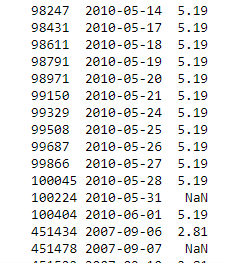

In [ ]:
#in most recent document, no? 

#from msvecm_thesis_1.02

In [ ]:
#create a copy in case the sorting results in an error:
unsorted_fulldata_df = fulldata_df.copy()

#re-organise the DF by (GVKEY) and then sort chronologically on the trade_date
unsorted_fulldata_df = unsorted_fulldata_df.set_index(['gvkey','trade_date']).sort_index()

#reset the index to move GVKEY and trade_date back to regular columns, while preserving the now chronologically sorted format
unsorted_fulldata_df = unsorted_fulldata_df.reset_index()

## optional but recommended: manually inspect a specific GVKEY ##
gvkey_28272 = unsorted_fulldata_df.loc[unsorted_fulldata_df.gvkey==28272]

#print the slice of the DF to string (so it prints the entire thing, and quickly confirm the trade_date is chronological)
print(gvkey_28272[['gvkey','trade_date']].to_string())   

#delete this sliced DF if it's correct and proceed:
del gvkey_28272

#if it is indeed correct, rename the DF / re-copy / or re-run the above code with "fulldata_df" instead
fulldata_df = unsorted_fulldata_df.copy()

#delete the tester DF
del unsorted_fulldata_df

In [ ]:
#now interpolation: 

gvkey_28272 = gvkey_28272.interpolate(method='linear',limit_direction='forward',axis=0)

gvkey_28272 = gvkey_28272.interpolate(method='linear',limit_direction='forward', limit=20, axis=0)
#add in limit to == 10 days

# A note on interpolation

### INCOMPLETE

In [ ]:
#interpolation?

gvkey_28272 = gvkey_28272.interpolate(method='linear',limit_direction='forward', limit=20, axis=0)

#interpolate the price  to sales ratio per GVKEY group 
sorted_alldata_df_final = sorted_alldata_df_final.groupby(['gvkey','price_sales']).apply(lambda g: g.interpolate(method='linear',
                                                                                       limit_direction='forward',
                                                                                       limit=4,
                                                                                       axis=0))

#if this were for weekly data: limit == 4 would exclude the interpolation of any series with a structural break >1m time


In [ ]:
#merge time resampling with interpolation? 

#add conclusion 

## TIME RE-SAMPLING EXAMPLE
* Going from daily-level observations to weekly; with the week being classified as Wednesday-to-Wednesday to iron out anomalies with Friday-Monday trading phenomena

In [ ]:
fulldata_df_weekly = fulldata_df.groupby('gvkey').resample('W-WED', on='trade_date').first()

#will result in a multi-level index; personal preference to reset index to move ['GVKEY','trade_date'] back to the columns

# Conclusion on the data cleaning process: 


* The result is roughly 408 firms with outstanding CDS contrats, bonds which mature in 4-6 years, as well as have information available on the bonds coupons 

<a id='PART_TWO'></a>

# PART TWO: Calculating Par-Equivalent Credit Default Swap (PECDS) 

* This is a technique used to be able to compare bonds (even those trading far from par) with their equivalent CDS contracts

### A brief primer on the underlying mechanics and mathematics of PECDS

* Intended to..

#### Initial Class Function:


* NOTE: the "hypothetical_bond_price" returned from this function, is the hypothetically implied price of the bond if the initial (starting value guessed) hazard rate (AKA default rate) were indeed the true hazard rate being used in the market.


* Provided that it is unlikely this initial guess is actually the true hazard rate, the hypothetical bond price variable in itself has no meaning until the subsequent function which re-optimises the entire processs with the newly solved hazard rate. 


* The price given by the solve_for_lambda function, would ...


* NOTE: the divison by 100 in the "def__init__(self...)" is a feature of the.......

In [ ]:
class lambda_exp_solver:
    def __init__(self, coupon, interest_frequency, years_to_maturity, price, riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr):
        self.coupon = float(coupon) / 100                             
        self.interest_frequency = int(float(interest_frequency))      # must be read in as (int(float( )) to avoid error
        self.maturity = float(years_to_maturity)                           
        self.price = float(price)                                  
        self.riskfree_rate_1yr = float(riskfree_rate_1yr) / 100
        self.riskfree_rate_2yr = float(riskfree_rate_2yr) / 100
        self.riskfree_rate_3yr = float(riskfree_rate_3yr) / 100
        self.riskfree_rate_4yr = float(riskfree_rate_4yr) / 100
        self.riskfree_rate_5yr = float(riskfree_rate_5yr) / 100     
        #note: the division by /100 is a feature of the data from WRDS (where 4.75 is == 4.75% but in python should = 0.0475)
        
    #formulate function for expected (present value) of bond- as a function of the numerically optimised hazard_rate (lambda)
    def lambda_bond_price_equation(self, hazard_r):
        
        #initialise variables for bond pricing
        pv_coupon_payments = 0    
        pv_bond_repayment_default = 0     
        pv_bond_repayment_no_default = 0          
        
        #initalise fixed parameters: the floating is simply for consistency if debugging is required: 
        principal = float(100)                                       #bonds quoted on basis of principal == $100
        recovery_rate = float(0.4)                                   #equivalent to 0.4 == (1 - RR)
        
        #initialise the class function's self.params
        maturity = self.maturity
        coupon_frequency = self.interest_frequency                  
        coupon_r = self.coupon
        price = self.price                                           
        riskfree_rate_1yr = self.riskfree_rate_1yr
        riskfree_rate_2yr = self.riskfree_rate_2yr
        riskfree_rate_3yr = self.riskfree_rate_3yr
        riskfree_rate_4yr = self.riskfree_rate_4yr
        riskfree_rate_5yr = self.riskfree_rate_5yr
        
        #initialise the risk-free rates as if they were 'one' series, to allow the correct year reference for discounting cash flows
        risk_free_rates_series = pd.Series([riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr])
        
        #calculate No. Years where bond makes a payment: math.ceil = returns smallest integral value greater than the passed in number
        total_payment_years = math.ceil(maturity)
        
        #for coupon bonds-- derive the number of coupon payments that will be made in its final year
        if ( coupon_frequency > 0):
            
            ## Start by calculating duration of final year (as a fraction of the total year). 
            duration_final_year = maturity - math.floor(maturity)
            
            ## Next calculate duration between each coupon payment (this equals 0.5 for semi-annual coupon bonds)
            duration_between_payments = 1/coupon_frequency
            
            ## Start by setting the number of payments in the final year to 1, since each bond pays a coupon on its maturity date (so as long as the bond matures in year 5, at least one payment is made then)
            number_coupons_final_year = 1
            
            ## Next shorten duration of final year by time period between coupon payments 
            remaining_duration_final_year =  duration_between_payments - duration_final_year
            
            #assuming the math.ceil(mat) means 3.8 >> 4.0; this should ensure the remaining duration is always positive for that 1/2 year's worth of coupon
            
            ## As long as this remaining duration is positive, increment number of coupon payments
            while (remaining_duration_final_year > 0):
                number_coupons_final_year += 1 
                
                #this loop segment handles any issue with negative (remaining_duratuin_final_year):if 5.1 == (0.1 - 0.5) = -0.4
                if (duration_final_year <= 0.5):
                     remaining_duration_final_year = duration_final_year - duration_final_year #should cancel out the while loop when the if-clause hits this
                elif (duration_final_year > 0.5):        
                    remaining_duration_final_year = duration_final_year - duration_between_payments 
        
        #formula for pricing the bond, as a function of the hazard_rate (lambda) 
        for i in range(1 ,total_payment_years+1):                  
                
            ## Obtain risk free rate corresponding to year of bond payment
            # The try/except format is to counter a "key error" occuring with some bonds nearing 6Y maturities - this is resolved by reverting the reference for maturities > 5Y to the 5Y swap rate
            try:
                risk_free_rate = risk_free_rates_series[i]
            except KeyError:
                risk_free_rate = risk_free_rates_series[4]  
                #note: in python, reference loc[4] is actually referring to the (5 year) swap rate - not the 4th
            
            ## Calculate the number of coupons paid during the payment year. In all but the final payment year, this is equal to the standard number of coupons per year.
            if ( i < total_payment_years):            
                number_coupons_in_payment_year = coupon_frequency
            elif ( i == total_payment_years):
                try:
                    number_coupons_in_payment_year = number_coupons_final_year
                except UnboundLocalError:            #occurs with zero-coupon bonds; simply fix zero-coupon bonds to have just one coupon (only the final year)
                    #This resolves the issue with zero-coupon bonds, as this variable is not defined for coupon_freq <= 0 (loop above)
                    number_coupons_final_year = 1
            
            ## Next increment expected present values of coupon payments (with t denoting the payment number within the year, always starting at 1)
            ## this is because most bonds pay semi-annual coupons (a select few pay quarterly, but the code will handle either without further changes)
            t = 1
            
            ## In each year, iterate over the number of coupon payments in that year
            ## Note that this loop will be skipped over for zero-coupon bonds, which have coupon_frequency of 0
            while ( t <= number_coupons_in_payment_year):
                
                ## Add present value of coupon payment, with hazard rate and risk-free rate multiplied by year i (since only discounting once per year)
                pv_coupon_payments += (np.exp(- (hazard_r) * i )) * coupon_r * principal * np.exp(-(risk_free_rate * i))
                
                ## Increment counter for number of coupon payments
                t+= 1
                
            ## Increment expected present value of bond recovery payment in case of default in each year i. Note this value is incremented only once per year.
            pv_bond_repayment_default += recovery_rate * principal * np.exp(-risk_free_rate * i) * ( np.exp(-hazard_r * (i-1)) - np.exp(-hazard_r * i) ) 

            ## Increment expected present value of bond principal repayment in case of no default in final year. 
            ## Note this value is incremented only once (as there can only be one 'final' payoff obviously)
            if ( i == total_payment_years):                              
                pv_bond_repayment_no_default += np.exp(-hazard_r * i) * principal * np.exp(-risk_free_rate * i)                  
                
        ## After looping over all payment years, calculate expected present value of bond          
        hypothetical_bond_price = pv_coupon_payments + pv_bond_repayment_default - pv_bond_repayment_no_default       
    
        ## Return total expected present value
        return hypothetical_bond_price
    
    #the above (lambda_bond_price_equation) function can now be numerically solved by np.optimize
    #this will yield the necessary hazard rate (implied by the market prices/variables) which would set the bond's value to par ($100)
    def solve_for_lambda(self):                                     
        optimised_lambda = optimize.fsolve(self.lambda_bond_price_equation, x0 = 0.05) 
        #note: x0 = initial starting guess parameter.
        #not particularly important as the updated x0 will be the previous function's value anyhow, (see function below): but 5-10% is a safe initial choice
        return optimised_lambda[0]

### Multiple methods for applying the above function to the Bond/CDS dataframe

* Due to the underlying functionality of the optimise function, the ... .... ..... 

* Thus, a viable (albeit, only for a relatively moderately sized DF) is to read the DF like a .txt file, iteratively, line-by-line

In [ ]:
reader_df_txt = open('final_df_cleaned_txt.txt','r')         #read the main DF(data) file
output_df_txt = open('output_df_v2_01.txt','w+')             #Create a file called () or write to it if it already exists (w+)

initial_hr = 0.075                                           #starting guess for solver 

for line in reader_df_txt:                            
    line = line.rstrip("\r\n")
    [bond_sym_id, trade_date, price, issue_id, bond_in_mergent,
       coupon, interest_frequency, coupon_type, maturity_date,
       secured, seniority, years_to_maturity, gvkey,
       riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr,
       riskfree_rate_4yr, riskfree_rate_5yr, cds_spread, series_id] = line.split()    # ("\t") tab space(not how my data is formatted)
    if bond_sym_id=="bond_sym_id":
        print('bond_sym_id', 'trade_date', 'price', 'issue_id', 'bond_in_mergent',
       'coupon', 'interest_frequency', 'coupon_type', 'maturity_date',
       'secured', 'seniority', 'years_to_maturity', 'gvkey',
       'riskfree_rate_1yr', 'riskfree_rate_2yr', 'riskfree_rate_3yr',
       'riskfree_rate_4yr', 'riskfree_rate_5yr', 'cds_spread', 'series_id', sep="\t", end="\n", file=output_df_txt)
        continue
    if (interest_frequency =="nan"):                                        #if I_FREQ = NAN >> assume == zero coupon bond ()
        interest_frequency = int(0)

    if (bond_sym_id=="" or bond_sym_id=="{}" or bond_sym_id=="NA"):          #bond_sym_id issues shouldn't exist anyhow
        init_bondprice = "NA"
        init_solved_lam = "NA"
        
    else:
        lambda_exp_solver_instance = lambda_exp_solver(coupon, interest_frequency, years_to_maturity, price, riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr)
        
        #initial_hr == 0.075 as defined at the beginning of this cell
        
        init_bondprice = lambda_exp_solver_instance.lam_exp_4(initial_hr)
        
        init_solved_lam = lambda_exp_solver_instance.solve_for_lambda()
        
        initial_hr = init_solved_lam    #update the initial starting guess using solved value from T-1
        #otherwise, it would reset to X0 = 5% for every iteration, 
        
    print(bond_sym_id, trade_date, price, issue_id, bond_in_mergent,
       coupon, interest_frequency, coupon_type, maturity_date,
       secured, seniority, years_to_maturity, gvkey,
       riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr,
       riskfree_rate_4yr, riskfree_rate_5yr, cds_spread, series_id, init_bondprice, init_solved_lam, sep="\t", end="\n", file=output_df_txt)    

        
reader_df_txt.close()  
output_df_txt.close() 

In [ ]:
#from PECDS_VAR_1.24

In [ ]:
#break down zero coupon bonds

#break down coupon bonds

#create a groupby-series, by year, for each subset:
full_df_years = final_df_pz_year.groupby('year_index').size()
zero_coupon_years = zero_coupon_series.groupby('year_index').size()

#create series with the difference
years_dif_series = zero_coupon_years / full_df_years

#convert to a better format for readability 
years_dif_series_percent = ['{:.2f}%'.format(x) for x in (years_dif_series[:] * 100)]

In [ ]:
#print a latex table for publication, 

print(tabulate(zip(full_df_years.index, full_df_years),
              headers=['YEAR', 'FULL_DF_BREAKDOWN' ], tablefmt='latex_raw'))

print('\n',
     "Total Observations full DF ==", len(df_basis_coupons_month))

In [ ]:
#don't need this data specifically in a seperate DF, so just print it to get an overview of the data:

print(tabulate(zip(zero_coupon_years.index, full_df_years, zero_coupon_years, years_dif_series_percent),
              headers=['YEAR', 'FULL_DF_BREAKDOWN', 'ZERO_COUPONS_BREAKDOWN',' ZERO_COUP (%) of FULL_DF'], tablefmt='orgtbl'))

print('\n', "Total Observations for zero coupon bonds ==", len(zero_coupon_series), '\n',
     "Total Observations full DF ==", len(final_df_pz))

|   YEAR |   FULL_DF_BREAKDOWN |   ZERO_COUPONS_BREAKDOWN |  ZERO_COUP (%) of FULL_DF   |
|--------+---------------------+--------------------------+-----------------------------|
|   2007 |                1325 |                      146 | 1.35%                       |
|   2008 |               10854 |                     1144 | 3.03%                       |
|   2009 |               37755 |                      954 | 1.97%                       |
|   2010 |               48443 |                      958 | 1.92%                       |
|   2011 |               49777 |                     1543 | 3.23%                       |
|   2012 |               47837 |                     3443 | 6.51%                       |
|   2013 |               52891 |                     3759 | 6.96%                       |
|   2014 |               54004 |                     2858 | 5.59%                       |
|   2015 |               51123 |                     2629 | 5.11%                       |
|   2016 |               51405 |                     5283 | 9.78%                       |
|   2017 |               53991 |                     2603 | 9.43%                       |

 Total Observations for zero coupon bonds == 25320 
 Total Observations full DF == 487018

### Noteworthy observation: zero_coupon_bonds seem to gradually be increasing as a portion of total Bond/CDS combinations; although, in absolute terms, they still remain the vastly smaller of the two groups

* big uptick in 2012? caused by default?

* 2015-2016??? 

## add a column for total outstanding bond observations over-time? Or a graph etc. 

In [ ]:
#printing latex 
print(rowsamp_20.to_latex(float_format=lambda x: '%10.2f' % x, index=False))

#writing latex files
res20_sampdf = open('res20_samptex.tex', 'w+') #write to this .tex file (or create it if it doesn't exist)
res20_sampdf.write(rowsamp_20.to_latex(float_format=lambda x: '%10.2f' % x, index=False ))
res20_sampdf.close()

# Modified function using solved lambda

* PECDS_VAR_1.24

In [ ]:
def lambda_exp_closed_solution(solved_lambda, coupon, interest_frequency, years_to_maturity, price, riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr, market_cds_spread):
        """
        Function to re-input the solved lambda; as this function can be applied in pandas, through df.apply with an auxiliary
        row function- it is easier to pull it out of the class and just directly apply it
        """
        #initialise variables for bond pricing
        pv_coupon_payments = 0    
        pv_bond_repayment_default = 0     
        pv_bond_repayment_no_default = 0   
        
        #redefine / rename variables where necessary
        hazard_r = solved_lambda
        maturity = years_to_maturity
        coupon_frequency = interest_frequency
        coupon_r = coupon / 100
        riskfree_rate_1yr = float(riskfree_rate_1yr) / 100
        riskfree_rate_2yr = float(riskfree_rate_2yr) / 100
        riskfree_rate_3yr = float(riskfree_rate_3yr) / 100
        riskfree_rate_4yr = float(riskfree_rate_4yr) / 100
        riskfree_rate_5yr = float(riskfree_rate_5yr) / 100          

        #initalise fixed parameters:
        principal = float(100)                                       
        recovery_rate = float(0.4)
        
        #initialise RFR(s) to enable linking respective RFR to its corresponding bond payment
        risk_free_rates_series = pd.Series([riskfree_rate_1yr, riskfree_rate_2yr, riskfree_rate_3yr, riskfree_rate_4yr, riskfree_rate_5yr])
        
        #calculate No. Years where bond makes a payment: math.ceil = returns smallest integral value greater than the passed in number
        total_payment_years = math.ceil(maturity)
        
        #for coupon bonds-- derive the number of coupon payments that will be made in its final year
        if ( coupon_frequency > 0):
            
            ## Start by calculating duration of final year (as a fraction of the total year). 
            duration_final_year = maturity - math.floor(maturity)
            
            ## Next calculate duration between each coupon payment (this equals 0.5 for semi-annual coupon bonds)
            duration_between_payments = 1/coupon_frequency
            
            ## Start by setting the number of payments in the final year to 1, since each bond pays a coupon on its maturity date (so as long as the bond matures in year 5, at least one payment is made then)
            number_coupons_final_year = 1
            
            #
            remaining_duration_final_year =  duration_between_payments - duration_final_year
            
            ## As long as this remaining duration is positive, increment number of coupon payments
            while (remaining_duration_final_year > 0):
                number_coupons_final_year += 1 
                
                #this loop here should resolve the issue with negative (remaining_dur_final_year):if 5.1 == (0.1 - 0.5) = -0.4
                if (duration_final_year <= 0.5):
                     remaining_duration_final_year = duration_final_year - duration_final_year #should cancel out the while loop
                elif (duration_final_year > 0.5):        
                    remaining_duration_final_year = duration_final_year - duration_between_payments
    
        
        #formula for pricing the bond, as a function of the hazard_rate (lambda) 
        for i in range(1 ,total_payment_years+1):               
                
            ## Obtain risk free rate corresponding to year of bond payment
            try:
                risk_free_rate = risk_free_rates_series[i]
            except KeyError:
                risk_free_rate = risk_free_rates_series[4]   
                #this manually sets any maturities which are 5Y> and <6Y to reference the 5Y swap rate (max maturity is 6Y for PECDS)
            
            ## Calculate the number of coupons paid during the payment year. In all but the final payment year, this is equal to the standard number of coupons per year.
            if ( i < total_payment_years):            
                number_coupons_in_payment_year = coupon_frequency
            elif ( i == total_payment_years):
                try:
                    number_coupons_in_payment_year = number_coupons_final_year
                except UnboundLocalError:
                    #try to solve the "reference before assignment" issue with zero-coupon bonds given this variable is not defined for coupon_freq <= 0 (loop above)
                    number_coupons_final_year = 1            
            
            ## Next increment expected present values of coupon payments (with t denoting the payment number within the year, always starting at 1)
            t = 1
            
            ## In each year, iterate over the number of coupon payments in that year
            while ( t <= number_coupons_in_payment_year):
                
                ## Add present value of coupon payment, with hazard rate and risk-free rate multiplied by year i (since only discounting once per year). Note that this loop will be skipped over for zero-coupon bonds, which have coupon_frequency of 0
                pv_coupon_payments += (np.exp(- (hazard_r) * i )) * coupon_r * principal * np.exp(-(risk_free_rate * i))
                
                ## Increment counter for number of coupon payments
                t += 1  
                
            ## Increment expected present value of bond recovery payment in case of default in each year i. Note this value is incremented only once per year.
            pv_bond_repayment_default += recovery_rate * principal * np.exp(-risk_free_rate * i) * ( np.exp(-hazard_r * (i-1)) - np.exp(-hazard_r * i) ) 

            ## Increment expected present value of bond principal repayment in case of no default in final year. Note this value is incremented only once
            if ( i == total_payment_years):                              
                pv_bond_repayment_no_default += np.exp(-hazard_r * i) * principal * np.exp(-risk_free_rate * i)

        ## After looping over all payment years, calculate expected present value of bond          
        lam_exp = pv_coupon_payments + pv_bond_repayment_default - pv_bond_repayment_no_default

        #change the scale (CDS on notional of $10000) however only *100 (see note below this function)
        pv_bond_repayment_default_modified = pv_bond_repayment_default * 100
        
        #divide modified bond_repayment_default by PV coupons
        PECDS_eq = pv_bond_repayment_default_modified / pv_coupon_payments
        
        cds_basis = market_cds_spread - PECDS_eq

        return PECDS_eq, cds_basis


## CHECK CDS_BASIS in main DOC: this could be incorrect as it is using the pre-optimised PECDS_eq value? Or at least, the above element "cds_basis" is overwritten later and thus useless here 

In [ ]:
def lambda_exp_closed_solution_auxfunc(row):
    "auxiliary function to apply to multiple columns per row for the bond pricing equation"
    
    return lambda_exp_closed_solution(row.solved_lambda, row.coupon, row.interest_frequency, row.years_to_maturity, row.price, 
    row.riskfree_rate_1yr, row.riskfree_rate_2yr, row.riskfree_rate_3yr, row.riskfree_rate_4yr, row.riskfree_rate_5yr, 
    row.market_cds_spread)

In [ ]:
final_df_basis['pecds_eq'] = final_df_basis.apply(lambda_exp_closed_solution_auxfunc, axis=1)

# BASIS/PECDS: needs cleaning / names adjustment 

In [ ]:
#to create two columns output, take the result of one column with the values seperated by a (comma) and split

#split the pecds / cds_bond_basis from one column into two 
pecds_eq_df = pd.DataFrame(final_df_basis['pecds_eq'].values.tolist(), index=final_df_basis.index)

#rename these columns for simplicity 
pecds_eq_df.columns = ['pecds','cds_bond_basis']

#drop the original incorrectly specified PECDS_EQ column from the main DF; as it is no longer needed / essentially meaningless
#this is the original PECDS (which used the wrong hazard rate, E.G. x0 = 5) before it was optimised & re-plugged in
final_df_basis = final_df_basis.drop(['pecds_eq'], axis=1)

#reaffix the original (two values in one column) as two columns, each with their one respective value
final_df_basis[['pecds','cds_bond_basis']] = pecds_eq_df[['pecds','cds_bond_basis']]

<a id='PART_THREE'></a>

# PART THREE: DESCRIPTIVE STATISTICS

## DISCLAIMER: 
* This section represents the code used to generate the descriptive statistics tables used in the write-up; however, the analysis offered here is not designed to be a complete substitute for the length and rigour offered in the main report. Accordingly, the brief snippets of analysis offered below are closer to executive summaries for each sub-section and thus, should not be regarded a complete analysis

In [15]:
cwd = os.getcwd()
files = os.listdir(cwd)
print("Files in %r: %s" % (cwd, files))

Files in 'C:\\Users\\JasonSpano\\OneDrive\\Uva Msc 19-20 Subjects\\Research Assistant Docs\\CDS_project_-_first_set_of_tasks\\Part 2_jan20\\Python_Github_Thesis_Rep_C\\Jspano_MScQFin_Thesis': ['.git', '.ipynb_checkpoints', 'Calculating_MSVECM_thesis_1.02.ipynb', 'Jspano_MSc_QuantFin_Public_Github_V1.00.ipynb', 'README.md']


In [10]:
#sorted_alldata_df_final = pd.read_pickle("./sorted_alldata_df_final.pkl")

In [9]:
sorted_alldata_df_final = pd.read_pickle(r"C:\Users\JasonSpano\OneDrive\Uva Msc 19-20 Subjects\Research Assistant Docs\CDS_project_-_first_set_of_tasks\Part 2_jan20./sorted_alldata_df_final.pkl")

In [30]:
#pre-define min and max median values by sector group to define the upper and lower limits of the y-axis (median basis value)

min_median = sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].min()
max_median = sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].max()

print(" Minimum sector median CDS-Bond basis: ", min_median, '\n',
     "Maximum sector median CDS-Bond basis: ", max_median, '\n')

#add a small amount of buffer to each value before inserting that value as the y-axis min/max:
min_median_adjusted = min_median * 1.20
max_median_adjusted = max_median * 1.20

print(" Adjusted minimum sector median CDS-Bond basis: ", min_median_adjusted, '\n',
     "Adjusted maximum sector median CDS-Bond basis: ", max_median_adjusted)

 Minimum sector median CDS-Bond basis:  -39.562582265761016 
 Maximum sector median CDS-Bond basis:  271.9672444858026 

 Adjusted minimum sector median CDS-Bond basis:  -47.475098718913216 
 Adjusted maximum sector median CDS-Bond basis:  326.3606933829631


In [ ]:
#https://stackoverflow.com/questions/7908636/possible-to-make-labels-appear-when-hovering-over-a-point-in-matplotlib

ValueError: too many values to unpack (expected 1)

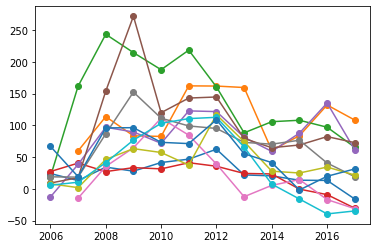

In [8]:

#x = sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].unstack()
#y = sorted_alldata_df_final.groupby(['year_index'])
#plt.ylim(min_median_adjusted, max_median_adjusted)
#plt.xlim(2007, 2017)
#ax.set_xlabel('Year')
#ax.set_ylabel('Median CDS-Bond Basis By Sector')
names = np.array(list("ABCD"))

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
#sc = plt.scatter(x,y,c=c, s=100, cmap=cmap, norm=norm)
line, = plt.plot(sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].unstack(), marker="o")

annot = ax.annotate("", xy=(0,0), xytext=(-20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    x = line.get_data()
    annot.xy = (x[ind["ind"][0]])
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show();

### Construct a line graph of each sector's median CDS-Bond basis over the sample period

Text(0, 0.5, 'Median CDS-Bond Basis By Sector')

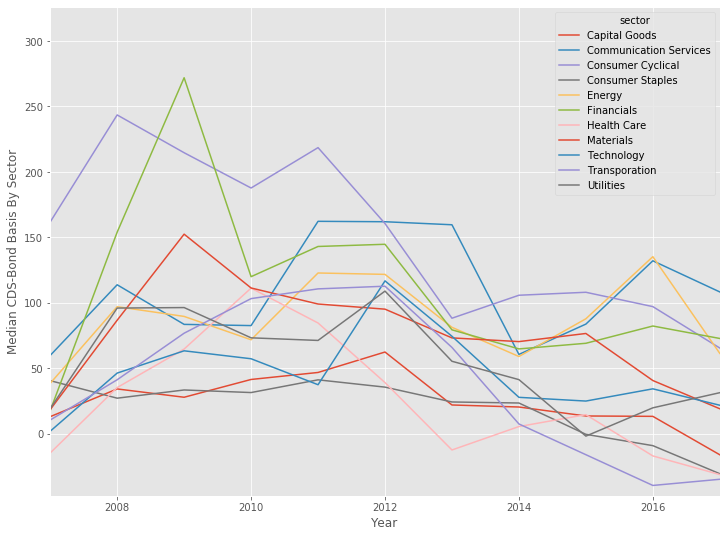

In [28]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,9))
sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].unstack().plot(ax=ax);
plt.ylim(min_median_adjusted, max_median_adjusted)
plt.xlim(2007, 2017)
ax.set_xlabel('Year')
ax.set_ylabel('Median CDS-Bond Basis By Sector')

### A general observation of the data at an aggregate-level reveals the universal tendency for the median CDS-Bond basis to trend downwards over time
* Although, the graph is too noisy and therefore, too cumbersome to indentify individual sector trends- we will refer to a stylised table to accomplish this task

* NOTE: herewithin, the CDS-Bond basis will be simply referred to as 'the basis'

In [10]:
#create a new dataframe which holds the median basis by sector per year across the sample horizon
median_sector_basis_by_sector = np.round(sorted_alldata_df_final.groupby(['year_index','sector']).median()['cds_bond_basis'].unstack(),2)

In [11]:
median_sector_basis_by_sector

sector,Capital Goods,Communication Services,Consumer Cyclical,Consumer Staples,Energy,Financials,Health Care,Materials,Technology,Transporation,Utilities
year_index,,,,,,,,,,,
2006,24.12,NaN,19.09,27.22,-12.87,9.07,NaN,18.91,7.92,5.63,66.93
2007,12.99,59.78,161.75,40.52,38.44,17.57,-14.76,18.40,1.86,10.43,19.16
2008,34.18,113.78,243.54,27.12,97.03,153.96,35.23,86.67,46.29,41.19,95.97
2009,27.83,83.51,214.68,33.39,89.59,271.97,64.66,152.45,63.31,76.76,96.36
2010,41.42,82.59,187.72,31.42,71.75,119.96,111.24,111.32,57.24,103.21,73.24
2011,46.77,162.26,218.57,41.14,122.78,143.04,84.57,99.07,37.41,110.64,71.24
2012,62.39,161.94,160.57,35.56,121.72,144.72,39.03,95.14,116.75,112.68,108.94
2013,21.92,159.63,88.22,24.22,81.28,79.34,-12.46,73.18,74.42,65.89,55.32
2014,20.37,60.57,105.77,23.43,58.97,64.77,5.44,70.35,27.77,7.43,41.30


#### A full analysis of the trends and accompanying explanations is available in the formal write-up document - linked at the top of this notebook

##### A brief primer on some principal trends are included here for convenience however: 
* There appears to be some aggregate-level macro event which occured around 2012, which temporarily reversed the earlier trend of shrinking basis values. One noteworthy observation is that the effect is significantly more pronounced for typically "riskier" industries, E.G. Technology, Financials and less pronounced for typically safer sectors E.G. Consumer Staples: which appears to be virtually unaffected. 
    * In the write-up, an argument and explanation is made in favour of determining whether the spike in median- and mean basis, which is presented in the write-up- can be causally explained by contagion effects from  2012's Eurozone Crisis. Broadly speaking, the answer is yes. 
    
    
* A more top-level observation is to note the long-run dynamics of the median basis across sectors. Drawing upon the aforementioned sectors above, the more typically "safe" asset classes have a long-run median which is closer to zero (E.G. consumer staples, capital goods) VS. more typically volatile sectors (E.G. Consumer Cyclical, Financials): which have consistently higher bases, as well as exhibit greater volatility. 

## Breakdown broad overview by year (in place of sector) 

* Components to detail: 
    * Year (2006 through 2017)
    * number of observations in that year
    * (%) of the respective year's observations as (%) of the total observations 
    * CDS-Bond Basis: 
        * Mean
        * Median
        * Standard Deviation

In [ ]:
#create series grouped-by year for each subset
full_df_years = df_basis_coupons_month.groupby('year_index').size()

In [ ]:
#create year index + the number of #OBS by year to be concatenated with the descriptive statistcs 
full_df_years_df = pd.DataFrame(full_df_years)
full_df_years_df = full_df_years_df.reset_index()
full_df_years_df.columns = ['year','obs_count']

In [ ]:
#run: mean, median, stddev on CDS-Bond Bais
basis_stats_yearind = np.round(df_basis_coupons_month.groupby('year_index').agg({'cds_bond_basis':['mean','median','std']}),2)
basis_stats_yearind = basis_stats_yearind.reset_index()

In [ ]:
#concat frames and drop the multi-index
basis_stats_obspercent_yearind = pd.concat([full_df_years_df, basis_stats_yearind], axis=1)
basis_stats_obspercent_yearind = basis_stats_obspercent_yearind.drop([('year_index', '')], axis=1)

In [ ]:
basis_stats_obspercent_yearind

### Turning to a broader overview of the distribution of the observations and the dynamics of the basis over time

* Present a simple table which shows how many observations fall into each year and determine the aggregate mean, median and standard deviation values for the entire sample.

* The aim is to largely establish that each year has a sufficient number of observations, such that causal explanations- such as the one presented above about the impacts of the Eurozone Crisis- can be soundly made without concern for other statistical anomalies: small sample-size effects etc. 

# try some unstacking here by sector?? 
* Or change the .groupby(['year_ind, sector']).agg(std.) etc. 


## Illustrating number of positive & negative weeks to descriptive statistics table

* PECDS_VAR_1.24

### CONSIDER: dropping the basis counters or present it by GVKEY but just shortened presentation -- consider just including the mean/median by sector breakdown? 

In [ ]:
df_basis_counts = df_basis_coupons_month
gvkey_sizes = df_basis_counts.groupby('gvkey').size()

In [ ]:
gvkey_list = []
pos_list = []
neg_list = []

for i, val in enumerate(df_basis_coupons_month.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]
    basis = data.cds_bond_basis
    gvkey_list.append(gvkey)
    pos_counter = 0; neg_counter = 0
    
    for i in basis:
        if i >=0:
            pos_counter += 1
            continue
        else:
            neg_counter += 1
            continue

    pos_list.append(pos_counter)
    neg_list.append(neg_counter)
    
df_basis_counter_df = pd.DataFrame(data=(gvkey_list, pos_list, neg_list)).T
df_basis_counter_df.columns=['GVKEY','POS_COUNTS','NEG_COUNTS']

In [ ]:
df_basis_counter_df['group_size'] = gvkey_sizes

In [ ]:
#this is to establish the base DF for presenting the results? 

gvkey_sizes_df = pd.DataFrame(gvkey_sizes)
gvkey_sizes_df = gvkey_sizes_df.reset_index()
gvkey_sizes_df.columns=['GVKEY','gvkey_sizes']

In [ ]:
df_basis_counter_df = df_basis_counter_df.merge(gvkey_sizes_df, how='left',on='GVKEY')

In [ ]:
#construct final frame
df_basis_counter_df['positive_weeks'] = np.round(df_basis_counter_df['POS_COUNTS'] / 7, 2)
df_basis_counter_df['negative_weeks'] = np.round(df_basis_counter_df['NEG_COUNTS'] / 7, 2)
df_basis_counter_df['gvkey_weeks'] = np.round(df_basis_counter_df['gvkey_sizes'] / 7, 2)
#df_basis_counter_df['GVKEY'] = (str(i)[-2:] == '.0' and str(i)[:-2] or str(i) for i in df_basis_counter_df['GVKEY'])

#add GVKEY and convert from float to clean (int)
df_basis_counter_df['GVKEY'] = gvkey_sizes_df['GVKEY']
df_basis_counter_df['GVKEY_'] = df_basis_counter_df['GVKEY'].astype(np.int)
df_basis_counter_df['POS_COUNTS_2'] = df_basis_counter_df['POS_COUNTS'].astype(np.int)
df_basis_counter_df['NEG_COUNTS_2'] = df_basis_counter_df['NEG_COUNTS'].astype(np.int)

#re-transform the original series
df_basis_counter_df['GVKEY'] = df_basis_counter_df['GVKEY_']
df_basis_counter_df['POS_COUNTS'] = df_basis_counter_df['POS_COUNTS_2']
df_basis_counter_df['NEG_COUNTS'] = df_basis_counter_df['NEG_COUNTS_2']

df_basis_counter_df['percent_positive'] = np.round(df_basis_counter_df['positive_weeks'] / df_basis_counter_df['gvkey_weeks'] * 100, 2)

In [ ]:
df_basis_counter_df = df_basis_counter_df.drop(['GVKEY_','POS_COUNTS_2','NEG_COUNTS_2'],axis=1)

In [ ]:
df_basis_counter_df

In [ ]:
#agg stats: 


In [ ]:
df_basis_counter_df = df_basis_counter_df.rename(columns={'GVKEY':'gvkey'})

In [ ]:
#here merged with a DF containing the GVKEY + sector keys 

basis_counts_weeks = df_basis_counter_df_sector.groupby('sector').agg({'gvkey_sizes':['size'], 'POS_COUNTS': ['median'], 'NEG_COUNTS': ['median'], 
                                                 'positive_weeks':['mean'], 'negative_weeks':['mean'], 
                                                  'percent_positive':['mean']})

In [ ]:
#see code below to round the mean(s) from 6 decimals to {:.2f}

In [ ]:
basis_counts_weeks

## SECTOR comparison of mean/median/sector sizes. 
* From: Calculating MS_VECM_thesis_1.02

In [ ]:
basis_meanmed_sector = np.round(fulldata_daily_df.groupby(['sector']).agg({'sector':['count'],'cds_bond_basis':['mean','median'], 
                                                              'market_cds_spread':['mean','median','std'],
                                                              'pecds':['mean','median','std'],
                                                                      'coupon':['mean','median','std']}),2)

In [ ]:
basis_meanmed_sector['cds_bond_basis',   'mean'] = np.round(basis_meanmed_sector['cds_bond_basis',   'mean'], 2)
basis_meanmed_sector['cds_bond_basis',   'median'] = np.round(basis_meanmed_sector['cds_bond_basis',   'median'], 2)
basis_meanmed_sector['solved_lambda',   'mean'] = np.round(basis_meanmed_sector['solved_lambda',   'mean'], 3)
basis_meanmed_sector['solved_lambda',   'median'] = np.round(basis_meanmed_sector['solved_lambda',   'median'], 3)

In [ ]:
basis_meanmed_sector

# REGRESSIONS-PRIMER

* Show a single GVKEY in demonstrating the: ADF, cointegration test, VAR regression, VECM regression, MS-VECM 


* (hyperlink its github location? Or PDF export?) 

# AUGMENTED DICKEY-FULLER (ADF) TEST

### Unit Root Testing / Stationarity Testing
* Fundamentally, it uses an autoregressive model, and optimises the (Bayesian Information Criterion (BIC)) across multiple different lags. NOTE: Other information criterion can also be used, for which there are pros and cons. See full report for an indepth analysis on the choice of BIC over alternatives


* The hypotheses: 
    * Null Hypothesis (H0) = the process can be represented by a unit root (has a time dependent structure / is stationary)
        * If failed to be rejected, implies the series/process has a unit root (it is non-stationary)
    * Alternative Hypothesis (H1) = the process has no unit root (no-time dependent structure); that is, the series is non-stationary
        * Rejecting the H0 - suggests the series does not have a unit root and implies it is stationary
        

* Roughly speaking, the more negative the test statistic, the more likely it is to reject the null hypothesis (the data is stationary)

    
* Additionally, the interpretation of this result must be supported by a threshold p-value; this paper uses a 95% certainty (p-value <= 0.05 will result in rejecting the H0). Similarily, a p-value > 0.05 will indicate a failure to reject H0 and imply the presence of a unit root / non-stationarity


### IMPORTANT : The VECM model & its extensions require the series to not only be non-stationary, but be integrated of the same order; accordingly, all series must be characterised by a unit-root for the regression models to be valid

In [36]:
#make a note on the p-value in the tesT? seems to always be >0.05 if the test.val is rejected (not neg enough AKA unit root)

#is it even valid to use VIX in the ADF test because the result then becomes time-dependent based on the exact sample periods? 


In [ ]:
#possible extensions: DFGLS? 
#Zivot-Andrews (UR test with a structural break in the intercept)


In [ ]:
#FROM: MSVECM_1.02

In [ ]:
#one_percent_cv == un hard-code it

In [51]:
ADF_critical_values_dictionary = list(test_ADF_cds.critical_values.values())

one_percent_cv = ADF_critical_values_dictionary[0]
five_percent_cv = ADF_critical_values_dictionary[1]
ten_percent_cv = ADF_critical_values_dictionary[2]

print("1% ADF CRITICAL VALUE:",  one_percent_cv, '\n'); print("5% ADF CRITICAL VALUE:", five_percent_cv, '\n')
print("10% ADF CRITICAL VALUE:", ten_percent_cv)

1% ADF CRITICAL VALUE: %f -3.4347287139577753 

5% ADF CRITICAL VALUE: -2.8634739225299133 

10% ADF CRITICAL VALUE: -2.5677995973755325


In [52]:
for key, value in test_ADF_cds.critical_values.items():
    print('\t%s: %.3f' % (key, value))

	1%: -3.435
	5%: -2.863
	10%: -2.568


In [56]:
test_ADF_cds.summary()

Test Statistic,-5.087
P-value,0.000
Lags,1


In [ ]:
#sum(list(values_adf)[0:1])

In [ ]:
#add discussion here: 

https://stackoverflow.com/questions/21604498/numpy-cholesky-decomposition-linalgerror
    
    

In [ ]:
#check msvecm_1.02 for table output / latex presentation tables



## maybe scrap equities trading data from this section

* Analyse that seperately, maybe some correlation methods with VIX? 
* Regress on different elements of the firm level ratios + 

### NEED THE GENERAL MARKET RETURN OF S&P 500?


#### SEE FONTANA 2011! for extracting market risk premium from S&P 500 (VIX, GARCH, S&P etc.) 

# ADF (BIC + AIC) + DFGLS(BIC + AIC) Combined Loop

* https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.DFGLS.html
* https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.ADF.html
    * https://arch.readthedocs.io/en/latest/_modules/arch/unitroot/unitroot.html#ADF
    
* BIC/AIC DIFFERENCES: 
    * https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other

# ORIGINAL (ADF (JUST BIC)) VIX/CDS/BOND

* Consider dropping the p-values? 
* How to handle the VIX? 
    * which papers had VIX? 

In [ ]:
dictionaries preserve dtypes:
    https://stackoverflow.com/questions/43816160/create-pandas-dataframe-from-lists-while-preserving-datatypes

In [ ]:
#import ADF values here: (instead of hard-coding as below)

In [ ]:
#correct to use VAR model to determine lag length for ADF of individual series?? 

#https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.ADF.html


#remove VIX >> change to ADF test with "ct" and compare two results: 

In [7]:
#initialise a few lists to append data to from each GVKEY's loop

gvkey_list = []                       #holds the GVKEY
sector_list = []                      #append the sector for each GVKEY (just saves having to re-merge on again later)
optimal_lag_list = []                 #holds the optimal number of lags selected by the BIC
first_date_obs = []                   #holds the first date observation per GVKEY
last_date_obs = []                    #holds the last date observation per GVKEY
time_horizon = []                     #holds the difference between the first and last date observations

#holds the series' test statistics (CDS, Bond, VIX)
stationarity_ts_cds = []              
stationarity_ts_bond = []             
stationarity_ts_vix = []

#holds the p-value for the test statistic 
stationarity_pvalue_cds = []          
stationarity_pvalue_bond = []         
stationarity_pvalue_vix = []

#will hold the supplementary list that will merge the test statistic with it's significance level
#E.G. the significance level (*, **, ***) for levels 10%, 5%, 1% respectively; this is for the latex publication tables
stationarity_test_res_cds = []        
stationarity_test_res_bond = []
stationarity_test_res_vix = []

stat_test_joint = []                                #will hold the outcome (CDS+BONDS) for the joint unit-root test outcome
problematic_gvkey = []                              #seperately log GVKEYs which encounter errors
linalg_errors = 0; value_errors = 0                 #simple counters for logging the number of errors occured, by group

#THE ADF CRITICAL VALUES for 1%, 5%, 10%:
one_percent_cv = -3.43472   
five_percent_cv = -2.86347 
ten_percent_cv = -2.56779
adf_automated_lag_cds = []; adf_automated_lag_bond = []

#create loop to test for stationarity in each GVKEY's data group: was (#sorted_alldata_df_final)
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]                        #assign the remainder of the data to be callable from data.(variable)
    gvkey_list.append(gvkey)             #append the GVKEY to a list, which keeps the data stored under the appropriate key
    sector_string = data.sector
    sector_list.append(sector_string.iloc[0])      #append the respective sector for that GVKEY
    
    #compute the specifics of each GVKEY's date / time horizon
    first_date_obs.append(data.trade_date.min())
    last_date_obs.append(data.trade_date.max())
    time_difference = data.trade_date.max() - data.trade_date.min()
    time_horizon.append(time_difference.days)               #append just the .days aspect of the timedelta variable
    
    #define the appropriate series for the ADF test: 
    cds = data.market_cds_spread         
    pecds = data.pecds
    vix = data.cboe_vix
    
    #the VAR model package requires the data be structured in a particular way; np.column stack is the fastest method
    data = np.column_stack((cds, pecds)) 
    
    #the VAR model construction is necessary for computing the BIC
    model = smt.VAR(data)  

    #compute the optimised BIC value from [model] which holds the vector autoregression model per GVKEY
    try:
        #for daily data, a maximum lag length is imposed (5 trading days, roughly equivalent to one trading week)
        bic_selected_lag = model.select_order(maxlags=10).bic 
        optimal_lag_list.append(bic_selected_lag)                  #store the optimised BIC result per GVKEY
        
        #ADF test - plugging in the bic selected lag length to run a unique length ADF test per GVKEY, per instrument
        test_ADF_cds = ADF(cds, trend='c', max_lags=10, method='BIC') 
        adf_automated_lag_cds.append(test_ADF_cds.lags)
        
        test_ADF_bond = ADF(pecds, trend='c',  max_lags=10, method='BIC')  
        adf_automated_lag_bond.append(test_ADF_bond.lags)
        
        test_ADF_vix = ADF(vix, trend='c',  max_lags=10, method='BIC')
        #test_ADF_vix = ADF(vix, lags=bic_selected_lag)
        
        #store the test statistic & p-value for each instrument's ADF test result, for each GVKEY (rounded to 4 decimals)
        stationarity_ts_cds.append(np.round(test_ADF_cds.stat,4))    
        stationarity_ts_bond.append(np.round(test_ADF_bond.stat,4))     
        stationarity_ts_vix.append(np.round(test_ADF_vix.stat,4))
        
        stationarity_pvalue_cds.append(np.round(test_ADF_cds.pvalue,4))    
        stationarity_pvalue_bond.append(np.round(test_ADF_bond.pvalue,4))
        stationarity_pvalue_vix.append(np.round(test_ADF_vix.pvalue,4))
        
        ##OPTIONAL
        #this part reads the test stat per GVKEY / instrument and assigns the appropriate (*) per its significance level
        #E.G. > 99% significance is commonly denoted as [test_statistic]*** in publication regression tables
        
        #CDS ADF LATEX TABLE CONSTRUCTION
        if test_ADF_cds.stat < one_percent_cv:
            stationarity_test_res_cds.append("***")   
        elif test_ADF_cds.stat < five_percent_cv:
            stationarity_test_res_cds.append("**")    ## The 1% & 5% significance would reject H0
        elif test_ADF_cds.stat < ten_percent_cv:
            stationarity_test_res_cds.append("*")     ## The 10% and no level would fail to reject H0
        else: 
            stationarity_test_res_cds.append(" ")  

        #repeat for BONDS:
        if test_ADF_bond.stat < one_percent_cv:
            stationarity_test_res_bond.append("***")
        elif test_ADF_bond.stat < five_percent_cv:
            stationarity_test_res_bond.append("**")   ## The 1% & 5% significance would reject H0
        elif test_ADF_bond.stat < ten_percent_cv:
            stationarity_test_res_bond.append("*")    ## The 10% and no level would fail to reject H0
        else: 
            stationarity_test_res_bond.append(" ")
            
            
        #VIX ADF LATEX TABLE CONSTRUCTION
        if test_ADF_vix.stat < one_percent_cv:
            stationarity_test_res_vix.append("***")   
        elif test_ADF_vix.stat < five_percent_cv:
            stationarity_test_res_vix.append("**")    ## The 1% & 5% significance would reject H0
        elif test_ADF_vix.stat < ten_percent_cv:
            stationarity_test_res_vix.append("*")     ## The 10% and no level would fail to reject H0
        else: 
            stationarity_test_res_vix.append(" ")  
                    
        
        #ensure that both series are integrated of the same order: a jointly unit-root system is required for VECM models
        if (test_ADF_bond.stat > five_percent_cv and test_ADF_cds.stat > five_percent_cv):  
            #this is > as to "not reject" the H0 is unit root; while reject the null would imply a stationary series
            stat_test_joint.append("BOND/CDS Both Have Unit Root")
            #stat_boolean.append(int(1))
        elif (test_ADF_bond.stat > five_percent_cv and test_ADF_cds.stat < five_percent_cv):
            stat_test_joint.append("BOND ONLY HAS UR")
        elif (test_ADF_bond.stat < five_percent_cv and test_ADF_cds.stat > five_percent_cv):
            stat_test_joint.append("CDS ONLY HAS UR")            
        else: 
            stat_test_joint.append("Cannot Reject H0")
            #stat_boolean.append(int(2))
        
    # A linear-algebra error could be caused by market factors which have created highly erratic basis behaviour
    # This could be caused by a firm nearing bankruptcy where its basis deviates excessively far from par
    #accordingly, the leading minor of the array is not positive definite is akin to taking the square root of a negative number
    except np.linalg.LinAlgError as lae:
        problematic_gvkey.append(gvkey)                                 #append problem GVKEY to seperate list
        print("LinAlgError: Row: {}, Reason : {} ".format(i, lae), '\n', "GVKEY: ({})".format(gvkey), 
              "SECTOR: ", sector_string.iloc[0])
      
        #append items to maintain placement in main DF \\ 
        #where the errors occur, fill with NaN values instead
        optimal_lag_list.append(np.nan)
        adf_automated_lag_cds.append(np.nan)
        adf_automated_lag_bond.append(np.nan)
        stat_test_joint.append("LinAlg_Error")
        
        stationarity_test_res_cds.append("_LAE")
        stationarity_test_res_bond.append("_LAE")
        stationarity_test_res_vix.append("_LAE")
        
        stationarity_ts_cds.append(np.nan)
        stationarity_ts_bond.append(np.nan)
        stationarity_ts_vix.append(np.nan)
        
        stationarity_pvalue_cds.append(np.nan)
        stationarity_pvalue_bond.append(np.nan)
        stationarity_pvalue_vix.append(np.nan)
        
        linalg_errors += 1
        continue
    
    #some series may have encounted some errors with a constant, thus adding a constant to the equation is invalid
    #this occurs due to poor liquidity in some markets, resulting in long periods of near-identical price quotes
    except (ValueError) as ve:
        problematic_gvkey.append(gvkey)
        print("ValueError: Row: {}, Reason : {} ".format(i, ve), '\n', "GVKEY: ({})".format(gvkey), 
              "SECTOR:", sector_string.iloc[0])
        
        #append items to maintain placement in main DF \\ 
        #where the errors occur, fill with NaN values instead
        optimal_lag_list.append(np.nan)
        adf_automated_lag_cds.append(np.nan)
        adf_automated_lag_bond.append(np.nan)        
        stat_test_joint.append("Value_Error")
        
        stationarity_test_res_cds.append("_VE")
        stationarity_test_res_bond.append("_VE")
        stationarity_test_res_vix.append("_VE")        
        
        stationarity_ts_cds.append(np.nan)
        stationarity_ts_bond.append(np.nan)
        stationarity_ts_vix.append(np.nan)
        
        stationarity_pvalue_cds.append(np.nan)
        stationarity_pvalue_bond.append(np.nan)
        stationarity_pvalue_vix.append(np.nan) 
        
        value_errors += 1
        continue  
        
#this section combines the test-statistic itself with the appropriate (*, **, ***) into one cell for the final DF
cds_sig = ["{}{}".format(stationarity_ts_cds, stationarity_test_res_cds) for stationarity_ts_cds, stationarity_test_res_cds in zip(stationarity_ts_cds, stationarity_test_res_cds)]
bond_sig = ["{}{}".format(stationarity_ts_bond, stationarity_test_res_bond) for stationarity_ts_bond, stationarity_test_res_bond in zip(stationarity_ts_bond, stationarity_test_res_bond)]  
vix_sig = ["{}{}".format(stationarity_ts_vix, stationarity_test_res_vix) for stationarity_ts_vix, stationarity_test_res_vix in zip(stationarity_ts_vix, stationarity_test_res_vix)]        

#the final DF constructor; the .T is to transpose to a more visually-friendly vertically orientated DF
df_stat_cdsbond_results = pd.DataFrame(data=(gvkey_list, sector_list, 
                                             cds_sig, adf_automated_lag_cds, stationarity_pvalue_cds,
                                             bond_sig, adf_automated_lag_bond, stationarity_pvalue_bond,
                                             vix_sig, stationarity_pvalue_vix,
                                             stat_test_joint, optimal_lag_list,
                                            first_date_obs, last_date_obs, time_horizon)).T

#dont think the boolean is needed? can read col names fine? 

#rename the columns for better readability
df_stat_cdsbond_results.columns = ['gvkey', 'sector', 
                                   'CDS', 'CDS_ADF_LAGS','CDS_pval', 
                                   'Bond', 'BOND_ADF_LAGS','BOND_pval',
                                   'VIX', 'VIX_pval',
                                   'Joint_Test_Outcome', 'bic_lag',
                                  'date_start','date_end','length_days'] 

#change to tabulate? 
print('\n', " Linear Algebra Errors #", linalg_errors, '\n', " Value Errors #", value_errors, '\n', " Total Errors #:", 
     (linalg_errors + value_errors))

ValueError: Row: 105, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (5671) SECTOR: Consumer Cyclical
LinAlgError: Row: 109, Reason : 1-th leading minor of the array is not positive definite  
 GVKEY: (5862) SECTOR:  Materials
ValueError: Row: 123, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (6653) SECTOR: Financials
ValueError: Row: 158, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (7991) SECTOR: Capital Goods
ValueError: Row: 179, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (8551) SECTOR: Consumer Cyclical
ValueError: Row: 205, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (10187) SECTOR: Financials
ValueError: Row: 207, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (10247) SECTOR: Consumer Staples
LinAlgError: Row

In [8]:
df_stat_cdsbond_results

,gvkey,sector,CDS,CDS_ADF_LAGS,CDS_pval,Bond,BOND_ADF_LAGS,BOND_pval,VIX,VIX_pval,Joint_Test_Outcome,bic_lag,date_start,date_end,length_days
0,1045,Transporation,-1.0953,0,0.717,-4.4148***,0,0.0003,-3.1261**,0.0247,CDS ONLY HAS UR,10,2009-09-24,2014-05-30,1709
1,1078,Health Care,-1.2237,0,0.6633,-1.2005,0,0.6734,-2.0928,0.2474,BOND/CDS Both Have Unit Root,1,2008-03-17,2010-09-30,927
2,1161,Technology,-1.9595,1,0.3046,-2.2782,0,0.1791,-6.0955***,0,BOND/CDS Both Have Unit Root,2,2008-04-10,2017-06-30,3368
3,1209,Materials,-1.7596,1,0.4007,-1.5319,0,0.5177,-4.193***,0.0007,BOND/CDS Both Have Unit Root,1,2011-07-28,2017-06-30,2164
4,1300,Capital Goods,-2.5216,2,0.1103,-2.521,0,0.1105,-2.9181**,0.0433,BOND/CDS Both Have Unit Root,2,2007-12-14,2017-03-01,3365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,175263,Consumer Cyclical,-3.4818***,3,0.0085,-4.6045***,0,0.0001,-3.0304**,0.0322,Cannot Reject H0,1,2009-02-23,2010-02-26,368
387,176404,Communication Services,-2.7357*,1,0.0681,-2.2938,0,0.174,-3.1709**,0.0217,BOND/CDS Both Have Unit Root,2,2008-01-28,2016-04-29,3014
388,176760,Materials,-1.8314,2,0.365,-1.2935,0,0.6321,-2.6707*,0.0793,BOND/CDS Both Have Unit Root,2,2007-12-03,2017-06-29,3496
389,179657,Capital Goods,nan_VE,NaN,NaN,nan_VE,NaN,NaN,nan_VE,NaN,Value_Error,NaN,2014-07-16,2016-07-15,730


In [9]:
#create just a mini-DF which holds the: GVKEY and ADF (base) joint test outcome:
base_adf_result_df = df_stat_cdsbond_results[['gvkey','Joint_Test_Outcome']]

In [10]:
base_adf_result_df

,gvkey,Joint_Test_Outcome
0,1045,CDS ONLY HAS UR
1,1078,BOND/CDS Both Have Unit Root
2,1161,BOND/CDS Both Have Unit Root
3,1209,BOND/CDS Both Have Unit Root
4,1300,BOND/CDS Both Have Unit Root
...,...,...
386,175263,Cannot Reject H0
387,176404,BOND/CDS Both Have Unit Root
388,176760,BOND/CDS Both Have Unit Root
389,179657,Value_Error


In [11]:
#max lags = 10  restrictions:
print("10 LAGS: BONDS")
bond_lag_series = pd.to_numeric(df_stat_cdsbond_results['BOND_ADF_LAGS'], errors='coerce')
print(bond_lag_series.mean())
print(bond_lag_series.median())
print(bond_lag_series.var())
print("BOND_LAGS (>2)", np.count_nonzero(bond_lag_series >2))
print("BOND_LAGS ==(2)", np.count_nonzero(bond_lag_series ==2))
print("BOND_LAGS ==(1)", np.count_nonzero(bond_lag_series ==1))
print("BOND_LAGS ==(0)", np.count_nonzero(bond_lag_series ==0))

#with max lags == 10 restrictions
print('\n', "10 LAGS: CDS")
cds_lag_series = pd.to_numeric(df_stat_cdsbond_results['CDS_ADF_LAGS'], errors='coerce')
print(cds_lag_series.mean())
print(cds_lag_series.median())
print(cds_lag_series.var())
print("CDS_LAGS (>2)", np.count_nonzero(cds_lag_series >2))
print("CDS_LAGS ==(2)", np.count_nonzero(cds_lag_series ==2))
print("CDS_LAGS ==(1)", np.count_nonzero(cds_lag_series ==1))
print("CDS_LAGS ==(0)", np.count_nonzero(cds_lag_series ==0))

10 LAGS: BONDS
0.47058823529411764
0.0
2.962939599432247
BOND_LAGS (>2) 26
BOND_LAGS ==(2) 5
BOND_LAGS ==(1) 3
BOND_LAGS ==(0) 340

 10 LAGS: CDS
1.3903743315508021
1.0
3.664893693280399
CDS_LAGS (>2) 58
CDS_LAGS ==(2) 58
CDS_LAGS ==(1) 109
CDS_LAGS ==(0) 149


In [12]:
#10 lags
bic_lag_series = pd.to_numeric(df_stat_cdsbond_results['bic_lag'], errors='coerce')
bic_lag_series
print(bic_lag_series.mean())
print(bic_lag_series.median())
print(bic_lag_series.var())
print("BIC_LAGS (>2)", np.count_nonzero(bic_lag_series >2))
print("BIC_LAGS ==(2)", np.count_nonzero(bic_lag_series ==2))
print("BIC_LAGS ==(1)", np.count_nonzero(bic_lag_series ==1))
print("BIC_LAGS ==(0)", np.count_nonzero(bic_lag_series ==0))

1.606951871657754
1.0
1.6440266089375
BIC_LAGS (>2) 36
BIC_LAGS ==(2) 95
BIC_LAGS ==(1) 243
BIC_LAGS ==(0) 0


In [13]:
#new
print(len(df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=="BOND/CDS Both Have Unit Root"]))
print(len(df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=="BOND ONLY HAS UR"]))
print(len(df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=="CDS ONLY HAS UR"]))
print(len(df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=="Cannot Reject H0"]))

265
64
31
14


## REORGANISE RESULTS PRESENTATION

In [79]:
#isolate each group into a seperate DF
unitroot_gvkeys = df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=='BOND/CDS Both Have Unit Root']
stationary_gvkeys = df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=='Cannot Reject H0']

#group results by sector: 
unitroot_gvkeys_adf_results = unitroot_gvkeys.groupby('sector').agg({'Joint_Test_Outcome':['size']})
stationary_gvkeys_adf_results = stationary_gvkeys.groupby('sector').agg({'Joint_Test_Outcome':['size']})

#rename for better readability / the future titles
unitroot_gvkeys_adf_results = unitroot_gvkeys_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Unit Root', 'Unit_Roots')})
stationary_gvkeys_adf_results= stationary_gvkeys_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Stationary', 'Stat_Series')}) 

### BRIEF RUNDOWN:
* Unit Root GVKEYS: 259
* Bond Only Unit Root GVKEYS: 67
* CDS only Unit Root GVKEYS: 35
* Both Series Stationary: 14
    * Total GVKEYS with at least one stationary series: 116
        * 116 keys will only be applicable in a VaR regression framework
    * Total GVKEYS potentially usable in VECM framework (subject to cointegration test): 259
    * Total GVKEYS to be usable in VaR / Granger Causality: (259 + 116) == 375
    

* Total Error GVKEYS (14 Value Errors + 2 Linear Algebra Errors == 16) 
* Total Analysed GVKEY groups (375 + 16) = 391

In [80]:
sector_adf_results = pd.concat([unitroot_gvkeys_adf_results, stationary_gvkeys_adf_results], axis=1)

#sector_adf_results= sector_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Unit Root', 'size')})

sector_adf_results = sector_adf_results.rename(columns={('Joint_Test_Outcome', 'size'):('Joint_Test_Outcome','Unit_Roots'),
                                                       ('Joint_Test_Outcome', 'size'):('Joint_Test_Outcome', 'Stationary')})

In [95]:
sector_adf_results
#stationary is 2nd column (==116)

Joint_Test_Outcome           
                               Unit Roots Unit Roots
sector                                              
Capital Goods                          21         10
Communication Services                  6          4
Consumer Cyclical                      50         13
Consumer Staples                       28         18
Energy                                 28          6
Financials                             30         18
Health Care                            23          4
Materials                              25         19
Technology                             22          6
Transporation                           7          7
Utilities                              16         11

In [7]:
#sector_adf_results.index.unique(level=1)

#IndexError: Too many levels: Index has only 1 level, not 2


# fix multi-index? 

In [120]:
sector_adf_results.columns.set_levels(['Unit Roots', 'Stationary'], level=1, inplace=True)
sector_adf_results

Joint_Test_Outcome           
                               Unit Roots Unit Roots
sector                                              
Capital Goods                          21         10
Communication Services                  6          4
Consumer Cyclical                      50         13
Consumer Staples                       28         18
Energy                                 28          6
Financials                             30         18
Health Care                            23          4
Materials                              25         19
Technology                             22          6
Transporation                           7          7
Utilities                              16         11

In [ ]:
#displaying only stationary observations

#stationary only variables for 1% / 5% significance for both series
#statationary_cdsbonds_df = df_stat_cdsbond_results.loc[((df_stat_cdsbond_results.stationarity_test_res_bond=='***') | (df_stat_cdsbond_results.stationarity_test_res_bond=='**')) & ((df_stat_cdsbond_results.stationarity_test_res_cds=='***') | (df_stat_cdsbond_results.stationarity_test_res_cds=='**'))]

#USE: 
stationary_gvkeys

#for the VAR in levels

## DFGLS TEST (ADF TEST EXTENSION)
### Elliott, Rothenberg and Stock’s GLS version of the Dickey-Fuller test

* DFGLS is an augmented Dickey-Fuller test. The principal difference is the time series in the DFGLS is transformed via a generalised least squares (GLS) regression before the test is performed. Elliott, Rothenberg, and Stock, as well as numerous later studies have shown this test has significantl greater power than the previous versions of the Augmented Dickey-Fuller (ADF) test. 

* The DFGLS performs the test for a series of models that includes (1 to K) lags of the first differenced, detrended variable.
  
  
* The test involves fitting a regression of the form: 
    * #yt ......
    
* The hypotheses: 
    * The null hypothesis: H0: B0 = 0
        * The null hypothesis being that Yt is a random walk, possibly with drift
    * There are two alternative hypotheses: 
        * Yt is stationary about a linear time trend
        * Yt is stationary with a possibly nonzero mean, but with no linear time trend 
        
        
* REFERENCE: 
    * Elliott, G., T. J. Rothenberg, and J. H. Stock. 1996. Efficient tests for an autoregressive unit root. Econometrica 64: 813–836.
     * Using Statsmodels packages: 
        * https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.DFGLS.html


In [ ]:
#THE ADF CRITICAL VALUES for 1%, 5%, 10%: (identical if trend == 'c')

one_percent_adf_cv = -3.43472 
five_percent_adf_cv = -2.8634
ten_percent_adf_cv = -2.5677

#if trend is set to "ct":
one_percent_dfgls_cv = -2.58
five_percent_dfgls_cv = -1.96
ten_percent_dfgls_cv = -1.64

#add biforked loop for handling c and ct DFGLS specs: 

In [11]:
#initialise lists to append data to from each GVKEY's loop
gvkey_list = []                       
sector_list = []    
var_model_optimal_lag = []

#optimal lag lengths for the CDS and BOND series under the different DFGLS specifications 
dfgls_lag_cds_trend_c = []
dfgls_lag_cds_trend_ct = []
dfgls_lag_bond_trend_c = []
dfgls_lag_bond_trend_ct = []

#holds the series' test statistics (CDS, Bond) for the two trend specifications (c and ct) + Pvalues List
dfgls_cds_trend_c = []; dfgls_cds_trend_c_pval = []     
dfgls_cds_trend_ct = []; dfgls_cds_trend_ct_pval = []    
dfgls_bond_trend_c = []; dfgls_bond_trend_c_pval = []      
dfgls_bond_trend_ct = []; dfgls_bond_trend_ct_pval = []        

#will hold the supplementary list that will merge the test statistic with it's significance level
#E.G. the significance level (*, **, ***) for levels 10%, 5%, 1% respectively; this is for the latex publication tables
test_res_cds_trend_c = []        
test_res_cds_trend_ct = []   
test_res_bond_trend_c = []
test_res_bond_trend_ct = []

#lists to hold the outcome of each specification for the unit-root tests (CDS / BONDS)
stat_test_joint_trend_c = []                        
stat_test_joint_trend_ct = []
problematic_gvkey = []                              #seperately log GVKEYs which encounter errors
linalg_errors = 0; value_errors = 0                 #simple counters for logging the number of errors occured, by group


#create loop to test for stationarity in each GVKEY's data group 
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]                        #assign the remainder of the data to be callable from data.(variable)
    gvkey_list.append(gvkey)             #append the GVKEY to a list, which keeps the data stored under the appropriate key
    sector_string = data.sector
    sector_list.append(sector_string.iloc[0])      #append the respective sector for that GVKEY
    
    #define the appropriate series for the ADF test: 
    cds = data.market_cds_spread         
    pecds = data.pecds
    
    #the VAR model package requires the data be structured in a particular way; np.column stack is the fastest method
    data = np.column_stack((cds, pecds)) 
    
    #the VAR model construction is necessary for computing the BIC
    model = smt.VAR(data)  

    #compute the optimised BIC value from [model] which holds the vector autoregression model per GVKEY
    try:
        #for daily data, a maximum lag length is imposed (5 trading days, roughly equivalent to one trading week)
        bic_selected_lag = model.select_order(maxlags=10).bic 
        var_model_optimal_lag.append(bic_selected_lag)                  #store the optimised BIC result per GVKEY
        
        #DFGLS TEST: 
        #trend == c (include a constant); critical values are identical to regular ADF test
        test_dfgls_cds_trend_c = DFGLS(cds, trend='c', max_lags=10, method='BIC')  
        test_dfgls_bond_trend_c = DFGLS(pecds, trend='c', max_lags=10, method='BIC')
        
        #store the test statistic & p-value for each instrument's ADF test result, for each GVKEY (rounded to 4 decimals)
        dfgls_cds_trend_c.append(np.round(test_dfgls_cds_trend_c.stat,4))    
        dfgls_bond_trend_c.append(np.round(test_dfgls_bond_trend_c.stat,4))  
        
        #store lag lengths for both CDS and Bond under "C" trend specification: 
        dfgls_lag_cds_trend_c.append(test_dfgls_cds_trend_c.lags)
        dfgls_lag_bond_trend_c.append(test_dfgls_bond_trend_c.lags)

        #append p-vals
        dfgls_cds_trend_c_pval.append(np.round(test_dfgls_cds_trend_c.pvalue,4))    
        dfgls_bond_trend_c_pval.append(np.round(test_dfgls_bond_trend_c.pvalue,4))

        #this part reads the test stat per GVKEY / instrument and assigns the appropriate (*) per its significance level
        #E.G. > 99% significance is commonly denoted as [test_statistic]*** in publication regression tables
        
        #CDS DFGLS_trend_c LATEX TABLE CONSTRUCTION
        if test_dfgls_cds_trend_c.stat < one_percent_adf_cv:
            test_res_cds_trend_c.append("***")   
        elif test_dfgls_cds_trend_c.stat < five_percent_adf_cv:
            test_res_cds_trend_c.append("**")    ## The 1% & 5% significance would reject H0
        elif test_dfgls_cds_trend_c.stat < ten_percent_adf_cv:
            test_res_cds_trend_c.append("*")     ## The 10% and no level would fail to reject H0
        else: 
            test_res_cds_trend_c.append(" ")  

        #BOND DFGLS_trend_c LATEX TABLE CONSTRUCTION
        if test_dfgls_bond_trend_c.stat < one_percent_adf_cv:
            test_res_bond_trend_c.append("***")
        elif test_dfgls_bond_trend_c.stat < five_percent_adf_cv:
            test_res_bond_trend_c.append("**")   ## The 1% & 5% significance would reject H0
        elif test_dfgls_bond_trend_c.stat < ten_percent_adf_cv:
            test_res_bond_trend_c.append("*")    ## The 10% and no level would fail to reject H0
        else: 
            test_res_bond_trend_c.append(" ")
                         
        
        #ensure that both series are integrated of the same order: a jointly unit-root system is required for VECM models
        if (test_dfgls_bond_trend_c.stat > five_percent_adf_cv and test_dfgls_cds_trend_c.stat > five_percent_adf_cv):  
            #this is > as to "not reject" the H0 is unit root; while reject the null would imply a stationary series
            stat_test_joint_trend_c.append("BOND/CDS Both Have Unit Root")
            
            #note: even if one series has a unit-root, it is still infeasible to include in the VECM model 
        elif (test_dfgls_bond_trend_c.stat > five_percent_adf_cv and test_dfgls_cds_trend_c.stat < five_percent_adf_cv):
            stat_test_joint_trend_c.append("BOND ONLY HAS UR")
        elif (test_dfgls_bond_trend_c.stat < five_percent_adf_cv and test_dfgls_cds_trend_c.stat > five_percent_adf_cv):
            stat_test_joint_trend_c.append("CDS ONLY HAS UR")            
        else: 
            stat_test_joint_trend_c.append("Cannot Reject H0")
            
            
        ### RUN DFGLS TEST WITH 2nd SPECIFICATION:     
        #DFGLS TEST: trend == 'ct'   - trend = constant + linear time trend (requires different critical values)
        test_dfgls_cds_trend_ct = DFGLS(cds, trend='ct', max_lags=10, method='BIC')
        test_dfgls_bond_trend_ct = DFGLS(cds, trend='ct', max_lags=10, method='BIC')
        
        #append the rounded statistic to the list (this will be subsequentially transformed after the loop)
        dfgls_cds_trend_ct.append(np.round(test_dfgls_cds_trend_ct.stat,4))  
        dfgls_bond_trend_ct.append(np.round(test_dfgls_bond_trend_ct.stat,4))  
        
        #store lag lengths for both CDS and Bond under "C" trend specification: 
        dfgls_lag_cds_trend_ct.append(test_dfgls_cds_trend_ct.lags)
        dfgls_lag_bond_trend_ct.append(test_dfgls_bond_trend_ct.lags)
        
        #append rounded p-value per test 
        dfgls_cds_trend_ct_pval.append(np.round(test_dfgls_cds_trend_ct.pvalue,4))  
        dfgls_bond_trend_ct_pval.append(np.round(test_dfgls_bond_trend_ct.pvalue,4))            
            
        #CDS DFGLS_trend_ct LATEX TABLE CONSTRUCTION
        if test_dfgls_cds_trend_ct.stat < one_percent_dfgls_cv:
            test_res_cds_trend_ct.append("***")   
        elif test_dfgls_cds_trend_ct.stat < five_percent_dfgls_cv:
            test_res_cds_trend_ct.append("**")    ## The 1% & 5% significance would reject H0
        elif test_dfgls_cds_trend_ct.stat < ten_percent_dfgls_cv:
            test_res_cds_trend_ct.append("*")     ## The 10% and no level would fail to reject H0
        else: 
            test_res_cds_trend_ct.append(" ")  

        #BOND DFGLS_trend_ct LATEX TABLE CONSTRUCTION
        if test_dfgls_bond_trend_ct.stat < one_percent_dfgls_cv:
            test_res_bond_trend_ct.append("***")
        elif test_dfgls_bond_trend_ct.stat < five_percent_dfgls_cv:
            test_res_bond_trend_ct.append("**")   ## The 1% & 5% significance would reject H0
        elif test_dfgls_bond_trend_ct.stat < ten_percent_dfgls_cv:
            test_res_bond_trend_ct.append("*")    ## The 10% and no level would fail to reject H0
        else: 
            test_res_bond_trend_ct.append(" ")
            
        #ensure that both series are integrated of the same order: a jointly unit-root system is required for VECM models
        if (test_dfgls_bond_trend_ct.stat > five_percent_dfgls_cv and test_dfgls_cds_trend_ct.stat > five_percent_dfgls_cv):  
            #this is > as to "not reject" the H0 is unit root; while reject the null would imply a stationary series
            stat_test_joint_trend_ct.append("BOND/CDS Both Have Unit Root")
            
            #note: even if one series has a unit-root, it is still infeasible to include in the VECM model 
        elif (test_dfgls_bond_trend_ct.stat > five_percent_dfgls_cv and test_dfgls_cds_trend_ct.stat < five_percent_dfgls_cv):
            stat_test_joint_trend_ct.append("BOND ONLY HAS UR")
        elif (test_dfgls_bond_trend_ct.stat < five_percent_dfgls_cv and test_dfgls_cds_trend_ct.stat > five_percent_dfgls_cv):
            stat_test_joint_trend_ct.append("CDS ONLY HAS UR")            
        else: 
            stat_test_joint_trend_ct.append("Cannot Reject H0")            
            
            
        
    # A linear-algebra error could be caused by market factors which have created highly erratic basis behaviour
    # This could be caused by a firm nearing bankruptcy where its basis deviates excessively far from par
    #accordingly, the leading minor of the array is not positive definite is akin to taking the square root of a negative number
    except np.linalg.LinAlgError as lae:
        problematic_gvkey.append(gvkey)                                 #append problem GVKEY to seperate list
        print("LinAlgError: Row: {}, Reason : {} ".format(i, lae), '\n', "GVKEY: ({})".format(gvkey), 
              "SECTOR: ", sector_string.iloc[0])
      
        #append items to maintain placement in main DF \\ 
        #where the errors occur, fill with NaN values instead
        var_model_optimal_lag.append(np.nan)
        stat_test_joint_trend_c.append("LinAlg_Error")
        stat_test_joint_trend_ct.append("LinAlg_Error")
        
        test_res_cds_trend_c.append("_LAE"); test_res_cds_trend_ct.append("_LAE")
        test_res_bond_trend_c.append("_LAE"); test_res_bond_trend_ct.append("_LAE")
        
        dfgls_cds_trend_c.append(np.nan); dfgls_cds_trend_ct.append(np.nan)
        dfgls_bond_trend_c.append(np.nan); dfgls_bond_trend_ct.append(np.nan)
        
        dfgls_cds_trend_c_pval.append(np.nan); dfgls_cds_trend_ct_pval.append(np.nan)
        dfgls_bond_trend_c_pval.append(np.nan); dfgls_bond_trend_ct_pval.append(np.nan)
        
        linalg_errors += 1
        continue
    
    #some series may have encounted some errors with a constant, thus adding a constant to the equation is invalid
    #this occurs due to poor liquidity in some markets, resulting in long periods of near-identical price quotes
    except (ValueError) as ve:
        problematic_gvkey.append(gvkey)
        print("ValueError: Row: {}, Reason : {} ".format(i, ve), '\n', "GVKEY: ({})".format(gvkey), 
              "SECTOR:", sector_string.iloc[0])
        
        #append items to maintain placement in main DF \\ 
        #where the errors occur, fill with NaN values instead
        var_model_optimal_lag.append(np.nan)
        stat_test_joint_trend_c.append("Value_Error")
        stat_test_joint_trend_ct.append("Value_Error")
        
        test_res_cds_trend_c.append("_VE"); test_res_cds_trend_ct.append("_VE")
        test_res_bond_trend_c.append("_VE"); test_res_bond_trend_ct.append("_VE")    
        
        dfgls_cds_trend_c.append(np.nan); dfgls_cds_trend_ct.append(np.nan)
        dfgls_bond_trend_c.append(np.nan); dfgls_bond_trend_ct.append(np.nan)
        
        dfgls_cds_trend_c_pval.append(np.nan); dfgls_cds_trend_ct_pval.append(np.nan)
        dfgls_bond_trend_c_pval.append(np.nan); dfgls_bond_trend_ct_pval.append(np.nan)
        
        value_errors += 1
        continue  
        
#this section combines the test-statistic itself with the appropriate (*, **, ***) into one cell for the final DF
cds_sig_trend_c = ["{}{}".format(dfgls_cds_trend_c, test_res_cds_trend_c) for dfgls_cds_trend_c, test_res_cds_trend_c in zip(dfgls_cds_trend_c, test_res_cds_trend_c)]
bond_sig_trend_c = ["{}{}".format(dfgls_bond_trend_c, test_res_bond_trend_c) for dfgls_bond_trend_c, test_res_bond_trend_c in zip(dfgls_bond_trend_c, test_res_bond_trend_c)]  

cds_sig_trend_ct = ["{}{}".format(dfgls_cds_trend_ct, test_res_cds_trend_ct) for dfgls_cds_trend_ct, test_res_cds_trend_ct in zip(dfgls_cds_trend_ct, test_res_cds_trend_ct)]
bond_sig_trend_ct = ["{}{}".format(dfgls_bond_trend_ct, test_res_bond_trend_ct) for dfgls_bond_trend_ct, test_res_bond_trend_ct in zip(dfgls_bond_trend_ct, test_res_bond_trend_ct)]              
              
#the final DF constructor; the .T is to transpose to a more visually-friendly vertically orientated DF
df_dfgls_cdsbond_results = pd.DataFrame(data=(gvkey_list, sector_list, 
                                             cds_sig_trend_c, dfgls_lag_cds_trend_c, dfgls_cds_trend_c_pval,
                                             bond_sig_trend_c, dfgls_lag_bond_trend_c, dfgls_bond_trend_c_pval,
                                             stat_test_joint_trend_c,
                                             cds_sig_trend_ct, dfgls_lag_cds_trend_ct, dfgls_cds_trend_ct_pval,
                                             bond_sig_trend_ct, dfgls_lag_bond_trend_ct, dfgls_bond_trend_ct_pval,
                                             stat_test_joint_trend_ct,
                                             var_model_optimal_lag)).T

#rename the columns for better readability
df_dfgls_cdsbond_results.columns = ['gvkey', 'sector', 
                                   'CDS_c', 'CDS_c_lags', 'CDS_c_pval', 
                                   'BOND_c', 'BOND_c_lags', 'BOND_c_pval',
                                   'Joint_Outcome_c', 
                                   'CDS_ct','CDS_ct_lags', 'CDS_ct_pval',
                                   'BOND_ct','BOND_ct_lags', 'BOND_ct_pval',
                                   'Joint_Outcome_ct',
                                   'var_model_lag'] 

## print a basic overview of error counts + unit-roots per test specification [optional]
print('\n', " Linear Algebra Errors #", linalg_errors, '\n', " Value Errors #", value_errors, '\n', " Total Errors #:", 
     (linalg_errors + value_errors), '\n')

print("DFGLS TEST: TREND = (C): UNIT ROOTS #", len(df_dfgls_cdsbond_results.loc[df_dfgls_cdsbond_results.Joint_Outcome_c=="BOND/CDS Both Have Unit Root"]))
print("DFGLS TEST: TREND = (CT): UNIT ROOTS #", len(df_dfgls_cdsbond_results.loc[df_dfgls_cdsbond_results.Joint_Outcome_ct=="BOND/CDS Both Have Unit Root"]))

ValueError: Row: 105, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (5671) SECTOR: Consumer Cyclical
LinAlgError: Row: 109, Reason : 1-th leading minor of the array is not positive definite  
 GVKEY: (5862) SECTOR:  Materials
ValueError: Row: 123, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (6653) SECTOR: Financials
ValueError: Row: 158, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (7991) SECTOR: Capital Goods
ValueError: Row: 179, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (8551) SECTOR: Consumer Cyclical
ValueError: Row: 205, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (10187) SECTOR: Financials
ValueError: Row: 207, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 GVKEY: (10247) SECTOR: Consumer Staples
LinAlgError: Row

In [12]:
df_dfgls_cdsbond_results

,gvkey,sector,CDS_c,CDS_c_lags,CDS_c_pval,BOND_c,BOND_c_lags,BOND_c_pval,Joint_Outcome_c,CDS_ct,CDS_ct_lags,CDS_ct_pval,BOND_ct,BOND_ct_lags,BOND_ct_pval,Joint_Outcome_ct,var_model_lag
0,1045,Transporation,-0.2413,0,0.6047,-0.749,0,0.403,BOND/CDS Both Have Unit Root,-1.8312*,0,0.3896,-1.8312*,0,0.3896,BOND/CDS Both Have Unit Root,10
1,1078,Health Care,-1.2314,0,0.2071,-1.2652,0,0.196,BOND/CDS Both Have Unit Root,-1.2274,0,0.7325,-1.2274,0,0.7325,BOND/CDS Both Have Unit Root,1
2,1161,Technology,-0.8643,1,0.3507,-0.6683,0,0.441,BOND/CDS Both Have Unit Root,-1.9465*,1,0.3282,-1.9465*,1,0.3282,BOND/CDS Both Have Unit Root,2
3,1209,Materials,-1.5857,1,0.1102,-1.5331,0,0.1219,BOND/CDS Both Have Unit Root,-2.157**,1,0.23,-2.157**,1,0.23,Cannot Reject H0,1
4,1300,Capital Goods,-2.1331,2,0.0329,-1.8384,0,0.0653,BOND/CDS Both Have Unit Root,-2.1782**,2,0.2212,-2.1782**,2,0.2212,Cannot Reject H0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,175263,Consumer Cyclical,0.5872,None,0.8564,-0.5927,None,0.4773,BOND/CDS Both Have Unit Root,-0.0883,None,0.993,-0.0883,None,0.993,BOND/CDS Both Have Unit Root,1
387,176404,Communication Services,-2.697*,None,0.0071,-2.3127,None,0.0208,BOND/CDS Both Have Unit Root,-2.7267***,None,0.0697,-2.7267***,None,0.0697,Cannot Reject H0,2
388,176760,Materials,-1.8466,None,0.0641,-1.3859,None,0.1596,BOND/CDS Both Have Unit Root,-2.0189**,None,0.2922,-2.0189**,None,0.2922,Cannot Reject H0,2
389,179657,Capital Goods,nan_VE,None,NaN,nan_VE,None,NaN,Value_Error,nan_VE,None,NaN,nan_VE,None,NaN,Value_Error,NaN


## DFGLS: TREND = 'c'  -- Tabulated Results Summary

In [58]:
#obtain distribution of sectors in the DF:
sector_sizes_all = df_dfgls_cdsbond_results.groupby('sector').size()

#keep the index (string name) of the sectors, to affix to the printed results:
sector_index = sector_sizes_all.index

#obtain distribution of those sectors which satisfy the conditon of both series containing a unit root:
sector_dfgls_unitroot = df_dfgls_cdsbond_results.loc[df_dfgls_cdsbond_results.Joint_Outcome_c=="BOND/CDS Both Have Unit Root"].groupby('sector').size()

#compute the % of each sector which has satisfied the condition
unitroot_ratio = sector_dfgls_unitroot / sector_sizes_all

#convert to a more readable format with (%) sign affixed
unitroot_diff = ['{:.2f}%'.format(x) for x in unitroot_ratio[:] * 100]

#tabulate results:
print(" \t\t\t\t DFGLS: UNIT ROOT TEST RESULTS: ", '\n')
print(tabulate(zip(sector_index, sector_sizes_all, sector_dfgls_unitroot, unitroot_diff),
              headers=['Sector', 'Sector Sizes','#Unit Roots in Sector','(%) of sector with UR'],
              tablefmt='orgtbl'))

#print min & max groups for (%) unit roots:
print('\n',"Sector with smallest (%) of unit roots: ", sector_index[np.argmin(unitroot_ratio)], 
      '{:.4f}%'.format(np.amin(unitroot_ratio)))
print(" Sector with largest (%) of unit roots: ", sector_index[np.argmax(unitroot_ratio)], 
      '{:.4f}%'.format(np.amax(unitroot_ratio)))

 				 DFGLS: UNIT ROOT TEST RESULTS:  

| Sector                 |   Sector Sizes |   #Unit Roots in Sector | (%) of sector with UR   |
|------------------------+----------------+-------------------------+-------------------------|
| Capital Goods          |             35 |                      30 | 85.71%                  |
| Communication Services |             10 |                       9 | 90.00%                  |
| Consumer Cyclical      |             70 |                      60 | 85.71%                  |
| Consumer Staples       |             46 |                      41 | 89.13%                  |
| Energy                 |             35 |                      33 | 94.29%                  |
| Financials             |             50 |                      44 | 88.00%                  |
| Health Care            |             27 |                      25 | 92.59%                  |
| Materials              |             45 |                      39 | 86.67%                  |


# FIX THE BOTTOM PRINT {:.4f}% 

# MEAN LAGS BY SECTOR: 
# DO WHEN RE-AFFIX the results to main DF? 

#FLAG FOR DEL? 

In [ ]:
cds_lag_series_trend_c = pd.to_numeric(df_dfgls_cdsbond_results['CDS_c_lags'], errors='coerce')
cds_lag_series_trend_ct = pd.to_numeric(df_dfgls_cdsbond_results['CDS_ct_lags'], errors='coerce')
bond_lag_series_trend_c = pd.to_numeric(df_dfgls_cdsbond_results['BOND_c_lags'], errors='coerce')
bond_lag_series_trend_ct = pd.to_numeric(df_dfgls_cdsbond_results['BOND_ct_lags'], errors='coerce')

In [61]:
cds_lag_series_trend_c = pd.to_numeric(df_dfgls_cdsbond_results['CDS_c_lags'], errors='coerce')

In [63]:
cds_lag_series_trend_c.mean()

1.4064171122994653

# COMBINE & COMPARE: DFGLS & ADF RESULTS

* Discuss why results might differ, ultimately must decide upon one method to take precedence for the final VaR / VECM modelling 

In [20]:
#mini_frame of DFGLS results: 
dfgls_twotrends_result_df = df_dfgls_cdsbond_results[['gvkey','sector','Joint_Outcome_c','Joint_Outcome_ct']]

In [30]:
#rename the original "joint_test_outcome" to avoid confusion in the final frame:
base_adf_result_df = base_adf_result_df.rename(columns={'Joint_Test_Outcome_ADF':'Joint_Outcome_ADF'})

In [31]:
dfgls_adf_results_df = dfgls_twotrends_result_df.merge(base_adf_result_df, 
                                                       how='left',
                                                       on='gvkey')

### Create a print/tabulate output to get an idea about the outcomes of the different test specifications

In [51]:
#create sector index
sector_sizes_all = dfgls_adf_results_df.groupby('sector').size()
sector_index = sector_sizes_all.index

#obtain distribution of those sectors which satisfy the conditon of both series containing a unit root:
sector_unitroots_c = dfgls_adf_results_df.loc[dfgls_adf_results_df.Joint_Outcome_c=="BOND/CDS Both Have Unit Root"].groupby('sector').size()
sector_unitroots_ct = dfgls_adf_results_df.loc[dfgls_adf_results_df.Joint_Outcome_ct=="BOND/CDS Both Have Unit Root"].groupby('sector').size()
sector_unitroots_adf = dfgls_adf_results_df.loc[dfgls_adf_results_df.Joint_Outcome_ADF=="BOND/CDS Both Have Unit Root"].groupby('sector').size()

#compute ratios of each specification with respect to total number of firms per sector:
dfgls_trend_c_ratio = sector_unitroots_c / sector_sizes_all
dfgls_trend_ct_ratio = sector_unitroots_ct / sector_sizes_all
adf_ratio = sector_unitroots_adf / sector_sizes_all

#reformat to be more readable
dfgls_trend_c_diff = ['{:.2f}%'.format(x) for x in dfgls_trend_c_ratio[:] * 100]
dfgls_trend_ct_diff = ['{:.2f}%'.format(x) for x in dfgls_trend_ct_ratio[:] * 100]
dfgls_adf_diff = ['{:.2f}%'.format(x) for x in adf_ratio[:] * 100]

#print tabulate
print("SUMMARY TABULATE OF THE THREE DIFFERENT TEST SPECIFICATIONS' OUTCOMES: ", '\n') #title

print(tabulate(zip(sector_index, sector_sizes_all, 
                   sector_unitroots_c, dfgls_trend_c_diff, 
                   sector_unitroots_ct, dfgls_trend_ct_diff,
                   sector_unitroots_adf, dfgls_adf_diff),
              headers=['Sector', 'Total Firms #',
                       'DFGLS_trend_c','(%)_DFGLS(c)',
                       'DFGLS_trend_ct', '(%)_DFGLS(ct)',
                       'ADF', '(%)_ADF'],
              tablefmt='pretty', numalign='center'))

#print totals: 
print("TOTAL NUMBER OF JOINTLY UNIT ROOT SERIES UNDER EACH TEST SPECIFICATION: ", '\n') #title
print("trend specification (constant (C)) only in DFGLS: ", 
      np.count_nonzero(dfgls_adf_results_df.Joint_Outcome_c==('BOND/CDS Both Have Unit Root')))

print("trend specification (constant + linear (CT)) only in DFGLS: ", 
      np.count_nonzero(dfgls_adf_results_df.Joint_Outcome_ct==('BOND/CDS Both Have Unit Root')))

print("trend specification (BASE ADF (C)) only in DFGLS: ", 
      np.count_nonzero(dfgls_adf_results_df.Joint_Outcome_ADF==('BOND/CDS Both Have Unit Root')))

print("Total Number of Firms in Sample {}".format(sector_sizes_all.sum()))

+------------------------+---------------+---------------+--------------+----------------+---------------+-----+---------+
|         Sector         | Total Firms # | DFGLS_trend_c | (%)_DFGLS(c) | DFGLS_trend_ct | (%)_DFGLS(ct) | ADF | (%)_ADF |
+------------------------+---------------+---------------+--------------+----------------+---------------+-----+---------+
|     Capital Goods      |      35       |      30       |    85.71%    |       20       |    57.14%     | 21  | 60.00%  |
| Communication Services |      10       |       9       |    90.00%    |       5        |    50.00%     |  6  | 60.00%  |
|   Consumer Cyclical    |      70       |      60       |    85.71%    |       44       |    62.86%     | 52  | 74.29%  |
|    Consumer Staples    |      46       |      41       |    89.13%    |       25       |    54.35%     | 29  | 63.04%  |
|         Energy         |      35       |      33       |    94.29%    |       22       |    62.86%     | 29  | 82.86%  |
|       Financia

#### BROAD TAKEAWAYS: 
    * Unsurprisingly, the additional consideration of a linear trend increases the amount of stationary characteristics in the data. 
    
    
    * A phenomena exists (notably in Technology, for example) where 100% unit-root features are almost halved with the inclusion of a linear trend. This could partly be explained by growth (more precisely, in terms of public price metrics, like share price) in that particular sector over time- with higher (sales > higher share price > smaller CDS spreads as chance of default shrinks). Although, a great deal more analysis is required to confirm this theory. 
    
    
    *  Some strength is given to this idea if you also consider "health care" which has the highest rate of unit-root among all (ct) trends; while traditionally more "secure" sectors, E.G. consumer staples, rank among the lowest (%) of occurences for all three specifications

# ZIVOT-ANDREWS

### "The Zivot-Andrews structural-break unit-root test" Procedure:

* Test for unit root in a univariate process in the presence of serial correlation + single structural break 

##### Important Implications for Regime Specifications
* These results will be used to formulate hypotheses regarding regime dependent structures and dynamics in the markov-switching regressions. As well as identifying potentially abnormal groups that may need to be dropped from the sample 

### REFERENCES: 
* https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.ZivotAndrews.html#arch.unitroot.ZivotAndrews
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.zivot_andrews.html





### Determine for each GVKEY the endogenously calculated break-point, based off the t-stat
1) First step is to find this index location, then associate this with the date for each GVKEY

2) A later step will then determine the significance of this point and judge whether further steps are necessary

3) Final step will merge these frames together to determine a level of signifiance for the breakpoints + referenced against the relevant date 
    * This is because neither package offers both the functionality of significance testing on the p-value and the date functionality together, thus both are employed

In [7]:
#implement: Step 1

breakpoint_indexes = []                                     #will hold the raw dataframe location index integer
gvkey_list = []                                             #gvkey / reference number 
date_breakpoints = []                                       #will hold the date of the breakpoint (determined by t-stat)
infeasible_tests = 0; unbound_local_errors = 0

#create loop to run the ZA test and associate the t-stat indicated breakpoint with its respective date by gvkey/group
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]                        
    gvkey_list.append(gvkey)     
    cds_za = data.market_cds_spread 
    date_series = data.trade_date
    
    try:
        statsmodels_za_loop = zivot_andrews(cds_za, trim=0.15, maxlag=10, regression='c', autolag='t-stat')

        #return the index location of breakpoint
        index_location_breakpoint = statsmodels_za_loop[4]  
        ## note: the [4] corresponds to "bpidx" AKA: the index of X corresponding to the endogenously calculated breakpoint
        
        #append the integer loc value to a list (as an extra reference)
        breakpoint_indexes.append(statsmodels_za_loop[4])                      

        #find the date associated with location.integer/index (AKA: the actual date per GVKEY)
        date_breakpoints.append(date_series.iloc[index_location_breakpoint])
        
    except (InfeasibleTestException) as ite:
        breakpoint_indexes.append(np.nan)
        date_breakpoints.append(np.nan)
        infeasible_tests += 1
        
    except (UnboundLocalError) as ule:
        breakpoint_indexes.append(np.nan)
        date_breakpoints.append(np.nan)  
        unbound_local_errors += 1
    

zivotandrews_breakpoint_locations = pd.DataFrame(data=(gvkey_list, breakpoint_indexes, date_breakpoints)).T
zivotandrews_breakpoint_locations.columns = ['gvkey','loc_index','date_breakpoint']

print(" Total InfeasibleTestException {}".format(infeasible_tests), '\n', 
     "Total UnboundLocalError {}".format(unbound_local_errors))

C:\Users\JasonSpano\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1859: RuntimeWarning: invalid value encountered in sqrt
  return b / np.sqrt(np.diag(sigma2 * xpxi))
C:\Users\JasonSpano\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


 Total InfeasibleTestException 0 
 Total UnboundLocalError 24


* **NOTE REGARDING THE (TRY/EXCEPT) ERRORS IN THE ABOVE ZA CODE:** <p> The UnboundLocalError / InfeasibleTestException both relate to the algebra errors encountered in the same groups specified in the unit-root testing section. Largely, this error is caused by some sort of "explosive" data change in one variable E.G. the cds-spread, while the bond values do not change (not because credit risk is unaffected in bonds, but because the chance of default has become so apparent that no one has been able to sell the bond and update the relevant market prices. Thus, the bond price reflects the credit conditions of several time periods past). It is cumbersome to do so, but finding quoted market prices for those days would likely correct the errors. Alas, this data is not available without heavy expense and thus cannot be incorporated. </p>

In [8]:
#E.G.the code now has..
# 1) the GVKEY reference
# 2) the loc_index which refers to the number of observations in from the start the break point occurs
# 3) the date corressponding to this loc_index

zivotandrews_breakpoint_locations

,gvkey,loc_index,date_breakpoint
0,1045,276,2010-10-15
1,1078,139,2008-09-26
2,1161,1582,2016-04-21
3,1209,1036,2015-08-20
4,1300,371,2009-05-18
...,...,...,...
386,175263,90,2009-06-29
387,176404,321,2009-04-21
388,176760,424,2009-07-17
389,179657,NaN,NaT


## BRIEF PRIMER ON STRUCTURAL BREAKS & THE ZA TEST'S IMPORTANCE

* Identifying potential breakpoints is important, otherwise the VAR and VECM regression models will assume the changes are happening in continuous time, when in reality the large changes have actually transpired over months/years. This is because the date index not being continuous will be ignored by the packages.



###  To illustrate this point visually, a single GVKEY (1045) will be shown below to demonstrate why a structural break would have a severe impact on the results. 
   
1) Visually, it is apparent there is some break occuring 2011 to 2012

2) This is resulting in an abnormally high (group-by) standard deviation, but if you were to isolate just the first section/regime (that is, before the structural break) the true standard deviation for each of the two sections is much lower in reality. 

3) The following question remains: should some of the data be discarded? Should the VAR/VECM models be conducted seperately on each regime? 



### SIDE NOTE: 
<p>As a side note, the variation in the 2nd regime of the CDS is a continuous flat line, which is likely representative of another problem with liquidity. (When there is no trades for any given trading day, that days value is either missing (which would result in another structural break depending on how many consecutive days were missed) or, the most recent trade's value is interpolated/duplicated to fill it in).


##  A QUICK VISUALISATION OVERVIEW
* visualise individual test result & view a graph CDS & mean annual CDS to view potential break points

 COMPANY ==  AMERICAN AIRLINES GROUP INC 
 SECTOR ==   Transporation
 GVKEY (1045) STANDARD DEVIATION IS:  2014.14


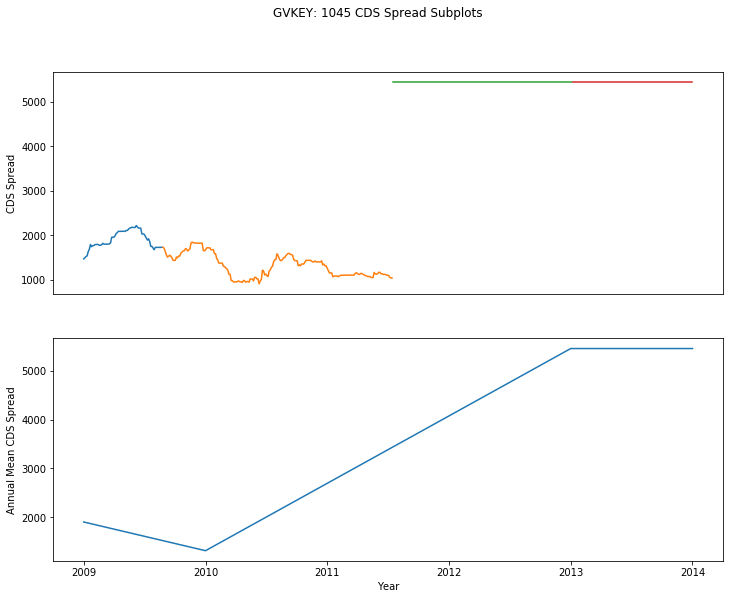

In [9]:
#insert GVKEY, view evolution of the key's CDS series & annual mean changes
gvkey_selection = 1045

gvkey_group_df = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]
print(" COMPANY == ", gvkey_group_df.company_name.iloc[0], '\n', "SECTOR ==  ", gvkey_group_df.sector.iloc[0])

#view that GVKEY's standard deviation too
print(" GVKEY ({}) STANDARD DEVIATION IS: ".format(gvkey_selection),
     np.round(sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'].std(),2))


#PLOT: 

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
fig.suptitle('GVKEY: {} CDS Spread Subplots'.format(gvkey_selection))

gvkey_group_df.groupby(['year_index'])['market_cds_spread'].plot(ax=ax1)
ax1.set_ylabel('CDS Spread')
ax1.axes.get_xaxis().set_visible(False)


gvkey_group_df.groupby(['year_index']).mean()['market_cds_spread'].plot(ax=ax2);
ax2.set_ylabel('Annual Mean CDS Spread')
ax2.set_xlabel('Year');
                       

## ADD THE BOND YIELD (RAW) SPREAD? 

## Visualise this point in time directly from the data DF: 

* Using GVKEY (1045) as the example

In [10]:
#view the loc_index indicated by the ZA test for one specific GVKEY:
zivotandrews_breakpoint_locations.loc[zivotandrews_breakpoint_locations.gvkey==gvkey_selection]

,gvkey,loc_index,date_breakpoint
0,1045,276,2010-10-15


In [33]:
#create a mini DF with just the three relevant series to simplify the viewing process:
zivot_andrews_mini_explanation_df = sorted_alldata_df_final_adf_results[['gvkey','trade_date','market_cds_spread']]

#now, visualise a few observations before and after the specified "break point/date"
zivot_andrews_mini_explanation_df.loc[zivot_andrews_mini_explanation_df.gvkey==gvkey_selection][274:280]

,gvkey,trade_date,market_cds_spread
274,1045,2010-10-13,1053.22
275,1045,2010-10-14,1039.01
276,1045,2010-10-15,1039.44
277,1045,2013-05-21,5456.22
278,1045,2013-05-22,5456.22
279,1045,2013-05-23,5456.22


#### Thus, it becomes fairly evident that the last date of the original breakpoint is (2010-10-15) which corresponds to the index.location(276). This is the precise location given by the Zivot Andrews test.
* Accordingly, it is obvious that the next data point is several years later and the spread is substantially higher. Thus, this si the location of the structural breakpoint. 

# Cross-validate the structural break points (date-wise) with the test-statistics derived from the arch.unitroot.ZivotAndrews

* This will allow us to isolate which GVKEYS actually fail to reject the null hypothesis, and then cross-reference the date associated with the break

* This is because only the statsmodels ZA package has the date feature, but the arch.unitroto package is more robust for running the actual test and deriving the statistics


* Potential Test Specifications: 
    * trend = t (a consistent, time trend)
    * trend = c (just a constant)
    * trend = ct (constant + trend)

In [13]:
##E.G Arch Unitroot Test 
#Test for a consistent time-series without structural breaks with the ZA test

#specify the same key as above:
gvkey_selection = 1045

#set the trend == (just a constant); same specification used in the statsmodel test for the breakpoint dates
ZivotAndrews(sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'], 
             trend='c',trim=0.15, max_lags=5, method='BIC').summary()

Test Statistic,-22.111
P-value,0.000
Lags,0


* The reported test statistic is extremely negative & significant. Thus, rejecting the Null Hypothesis at the 99% significance level 
* This supports the visual representation of there being indeed, a severe structural break

## Running The  Zivot-Andrews Loop For The Entire DF: 

* General Specifications: 
    * Trim = 0.15 (percentage of the series to exclude from the beginning and the end)
    * Maxlag = maximum lag to be conducted in the test
    * Method (BIC, AIC, t-stat) -- 
        * “t-stat” based choice of maxlag. Starts with maxlag and drops a lag until the t-statistic on the last lag length is significant using a 5%-sized test.
        * Otherwise, the BIC/AIC choose the number of lags to minimise that respective information criterion

In [ ]:
#The test's critical values are as follows: 

In [69]:
ZA_critical_values_dictionary = list(gvkey_1045_za.critical_values.values())

za_one_percent_cv = ZA_critical_values_dictionary[0]
za_five_percent_cv = ZA_critical_values_dictionary[1]
za_ten_percent_cv = ZA_critical_values_dictionary[2]

print(" ONE % ZA CRITICAL VALUE:", za_one_percent_cv, '\n', "FIVE % ZA CRITICAL VALUE:", za_five_percent_cv, '\n', 
      "TEN % ZA CRITICAL VALUE:", za_ten_percent_cv)

 ONE % ZA CRITICAL VALUE: -5.03421 
 FIVE % ZA CRITICAL VALUE: -4.4058 
 TEN % ZA CRITICAL VALUE: -4.13678


In [14]:
#create list for the general items
gvkey_list = []                        #holds the GVKEY
sector_list = []                       #append the sector for each GVKEY (just saves having to re-merge on again later)
first_date_obs = []                    #holds the first date observation per GVKEY
last_date_obs = []                     #holds the last date observation per GVKEY
time_horizon = []                      #holds the difference between the first and last date observations
group_size = []                        #hold the number of observations (trades) per GVKEY
size_discrepancy = []                  #hold the difference between #obs and (first trade - last trade) dates (a comparison)

#create lists for items specific to the ZA test
unitroot_ts_cds = []                   #the test statistic for the CDS series
unitroot_pvalue_cds = []               #the p-value for the CDS series
unitroot_test_res_cds = []             #a list which will hold the significance level (*, **, ***) for publication tables
group_stddev = []
outcome_string = []

#create a seperate DF to hold details about the probematic GVKEY groups & their characteristics 
problematic_gvkey = []
problematic_first_date_obs = []                   #holds the first date observation per GVKEY
problematic_last_date_obs = []                    #holds the last date observation per GVKEY
problematic_time_horizon = []                     #holds the difference between the first and last date observations
problematic_sector = []
problematic_size_discrep = []                     #holds the difference in trades vs (first - last date)
problematic_cds_stddev = []                       #compare against that group's standard_deviation (likely constant error)
problem_argument_instance = []                   #hold the string argument of the errors
infeasible_test_exceptions_counter = 0            #count the number of error instances

#THE ZA-TEST CRITICAL VALUES - highlighted/calculated above: (they don't change so fine to hard code in)
one_percent_cv = -5.27644   
five_percent_cv = -4.81067 
ten_percent_cv = -4.56618

#create loop to test for stationarity in each GVKEY's data group 
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]                        #assign the remainder of the data to be callable from data.(variable)
    gvkey_list.append(gvkey)             #append the GVKEY to a list, which keeps the data stored under the appropriate key
    sector_string = data.sector
    sector_list.append(sector_string.iloc[0])      #append the respective sector for that GVKEY
    
    
    #compute the specifics of each GVKEY's date / time horizon
    first_date_obs.append(data.trade_date.min())
    last_date_obs.append(data.trade_date.max())
    time_difference = data.trade_date.max() - data.trade_date.min()
    time_horizon.append(time_difference.days)               #append just the .days aspect of the timedelta variable
    
    #define the appropriate series for the ADF test: 
    cds_za = data.market_cds_spread      
    group_stddev.append(np.round(cds_za.std(),4))

    #bic is optimised within the test (see notes)

    try:
        #run the ZA-test
        za_test_cds = ZivotAndrews(cds_za, trend='c', trim=0.15, max_lags=5, method='t-stat')
        group_size.append(za_test_cds.nobs)
        size_discrepancy.append(int(za_test_cds.nobs) - int(time_difference.days))
        
        #number will always be negative as there are holidays etc. which mean total days is always > #trading days
          
        #store the test statistic & p-value for the ZA-TEST, by GVKEY (rounded to 4 decimals)
        unitroot_ts_cds.append(np.round(za_test_cds.stat,4))    
        unitroot_pvalue_cds.append(np.round(za_test_cds.pvalue,4))    

        
        #CDS ZA-TEST LATEX TABLE CONSTRUCTION
        if za_test_cds.stat < one_percent_cv:
            unitroot_test_res_cds.append("***")   
        elif za_test_cds.stat < five_percent_cv:
            unitroot_test_res_cds.append("**")    ## The 1% & 5% significance would reject H0
        elif za_test_cds.stat < ten_percent_cv:
            unitroot_test_res_cds.append("*")     ## The 10% and no level would fail to reject H0
        else: 
            unitroot_test_res_cds.append(" ")     #Fail to reject the H0 at any level less than 0.10% significance
            
              
        #ensure that both series are integrated of the same order: a jointly unit-root system is required for VECM models
        if (za_test_cds.stat > five_percent_cv or za_test_cds.pvalue > 0.05):  
            #this is > as to "not reject" the H0 is unit root; while reject the null would imply a stationary series
            outcome_string.append("unitroot/structural break")
        else: 
            outcome_string.append("trend/break stationary")


    except (InfeasibleTestException) as ite:
        #fill in the lists for the main_DF to maintain list to DF structuring 
        unitroot_ts_cds.append(np.nan)
        unitroot_pvalue_cds.append(np.nan)
        unitroot_test_res_cds.append("_ITE")
        outcome_string.append("ITE_ERROR")
        
        #populate items for the "problem" DF
        problematic_gvkey.append(gvkey)
        problematic_sector.append(sector_string.iloc[0]) 
        problematic_cds_stddev.append(cds_za.std())
        
        #populate date items
        problematic_first_date_obs.append(data.trade_date.min())
        problematic_last_date_obs.append(data.trade_date.max())
        problematic_time_difference = data.trade_date.max() - data.trade_date.min()
        problematic_time_horizon.append(time_difference.days) 
        problematic_size_discrep.append(int(cds_za.shape[0]) - int(time_difference.days)) #acquire the 'size' of the group 
    
        #print just the first instance of exception/error, and append details to the seperate DF
        problematic_instance_string = str(ite.args)
        if problematic_instance_string not in problem_argument_instance:
            print("InfeasibleTestException: Row: {}, Reason : {} ".format(i, ite))
            problem_argument_instance.append(problematic_instance_string)
        
        infeasible_test_exceptions_counter += 1
        print("GVKEY:", gvkey, "Another InfeasibleTestException: Row: {}".format(i), "SECTOR:", sector_string.iloc[0])
        continue          
        
        
#this section combines the test-statistic itself with the appropriate (*, **, ***) into one cell for the final DF
cds_za_sig = ["{}{}".format(unitroot_ts_cds, unitroot_test_res_cds) for unitroot_ts_cds, unitroot_test_res_cds in zip(unitroot_ts_cds, unitroot_test_res_cds)]


#the final DF constructor; the .T is to transpose to a more visually-friendly vertically orientated DF
df_za_results = pd.DataFrame(data=(gvkey_list, sector_list, cds_za_sig,  unitroot_pvalue_cds,
                                             outcome_string, first_date_obs, last_date_obs, time_horizon,
                                  group_stddev, size_discrepancy)).T

#rename the columns for better readability
df_za_results.columns = ['gvkey', 'sector', 'CDS_ZA_Test_Statistic', 'CDS_pval', 'Outcome',
                                  'date_start','date_end','length_days','std_dev','size_dif']


#construct problem DF
za_problem_df = pd.DataFrame(data=(problematic_gvkey, problematic_first_date_obs, problematic_last_date_obs,
                                   problematic_time_horizon, problematic_size_discrep, 
                                   problematic_cds_stddev, problematic_sector)).T

za_problem_df.columns = ['gvkey','first_obs_date','last_obs_date','length_days', 
                         'size_dif','group_cds_stddev', 'problem_sector']
                                   

print("Infeasible Test Exceptions Count:", infeasible_test_exceptions_counter)

C:\Users\JasonSpano\anaconda3\lib\site-packages\arch\unitroot\unitroot.py:1450: RuntimeWarning: invalid value encountered in sqrt
  return b / sqrt(diag(sigma2 * xpxi))


InfeasibleTestException: Row: 105, Reason : The maximum lag you are considering (5) results in an ADF regression with a
singular regressor matrix after including 0 lags, and so a specification test be
run. This may occur if your series have little variation and so is locally constant,
or may occur if you are attempting to test a very short series. You can manually set
maximum lag length to consider smaller models. 
GVKEY: 5671 Another InfeasibleTestException: Row: 105 SECTOR: Consumer Cyclical
GVKEY: 5862 Another InfeasibleTestException: Row: 109 SECTOR: Materials
GVKEY: 6653 Another InfeasibleTestException: Row: 123 SECTOR: Financials
GVKEY: 7991 Another InfeasibleTestException: Row: 158 SECTOR: Capital Goods
InfeasibleTestException: Row: 179, Reason : The maximum lag you are considering (5) results in an ADF regression with a
singular regressor matrix after including 2 lags, and so a specification test be
run. This may occur if your series have little variation and so is locally cons

### Zivot-Andrews DF 
* From the arch package, with test-statistics and p-values

##### to be merged with the "zivotandrews_breakpoint_locations" to give breakpoint dates with significance levels

In [19]:
df_za_results.head()

,gvkey,sector,CDS_ZA_Test_Statistic,CDS_pval,Outcome,date_start,date_end,length_days,std_dev,size_dif
0,1045,Transporation,-22.1113***,0,trend/break stationary,2009-09-24,2014-05-30,1709,2014.14,-1163
1,1078,Health Care,-3.2991,0.7958,unitroot/structural break,2008-03-17,2010-09-30,927,22.7526,-307
2,1161,Technology,-2.6801,0.9706,unitroot/structural break,2008-04-10,2017-06-30,3368,395.927,-1483
3,1209,Materials,-3.7591,0.5073,unitroot/structural break,2011-07-28,2017-06-30,2164,12.6212,-693
4,1300,Capital Goods,-4.0746,0.3068,unitroot/structural break,2007-12-14,2017-03-01,3365,19.0918,-991


In [17]:
#merge the two DF(s)
combined_za_breakpoints_df = df_za_results.merge(zivotandrews_breakpoint_locations,
                                                how='left',
                                                on='gvkey')

In [28]:
combined_za_breakpoints_df.head()

,gvkey,sector,CDS_ZA_Test_Statistic,CDS_pval,Outcome,date_start,date_end,length_days,std_dev,size_dif,loc_index,date_breakpoint
0,1045,Transporation,-22.1113***,0,trend/break stationary,2009-09-24,2014-05-30,1709,2014.14,-1163,276,2010-10-15
1,1078,Health Care,-3.2991,0.7958,unitroot/structural break,2008-03-17,2010-09-30,927,22.7526,-307,139,2008-09-26
2,1161,Technology,-2.6801,0.9706,unitroot/structural break,2008-04-10,2017-06-30,3368,395.927,-1483,1582,2016-04-21
3,1209,Materials,-3.7591,0.5073,unitroot/structural break,2011-07-28,2017-06-30,2164,12.6212,-693,1036,2015-08-20
4,1300,Capital Goods,-4.0746,0.3068,unitroot/structural break,2007-12-14,2017-03-01,3365,19.0918,-991,371,2009-05-18


In [ ]:
#4.81

In [25]:
combined_za_has_bp_df = combined_za_breakpoints_df.loc[combined_za_breakpoints_df.CDS_pval<=0.05]

In [27]:
combined_za_has_bp_df.head(5)

,gvkey,sector,CDS_ZA_Test_Statistic,CDS_pval,Outcome,date_start,date_end,length_days,std_dev,size_dif,loc_index,date_breakpoint
0,1045,Transporation,-22.1113***,0,trend/break stationary,2009-09-24,2014-05-30,1709,2014.14,-1163,276,2010-10-15
13,1704,Technology,-5.2397**,0.0123,trend/break stationary,2011-06-01,2017-06-15,2206,16.6373,-1585,318,2016-04-19
15,1794,Energy,-5.1511**,0.0177,trend/break stationary,2011-06-02,2016-08-31,1917,56.1296,-1233,307,2012-08-06
16,1913,Capital Goods,-33.7787***,0,trend/break stationary,2007-01-16,2017-06-29,3817,29.8273,-2779,460,2009-01-15
20,1988,Capital Goods,-6.5871***,0.0002,trend/break stationary,2010-09-02,2017-06-29,2492,34.5626,-1411,612,2014-01-06


In [20]:
#think this is unnecessary as no t-stat <= -4.81 with pvalue <= 0.05
#FLAG FOR DEL 
#combined_za_breakpoints_df.loc[((combined_za_breakpoints_df.CDS_pval<=0.05) & (combined_za_breakpoints_df.CDS_ZA_Test_Statistic <= -4.81))]


#spits: 
#TypeError: '<=' not supported between instances of 'str' and 'float'
#due to (***) in the statistic in table. 

## WORK IN PROGRESS 

In [ ]:
#FROM:



#https://realpython.com/python-statistics/






In [30]:
sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'].kurtosis()

-1.9498673667759177

In [ ]:
#Summary Statistics (should stack them into one clean list/df tabulate thing)
stat = df_comp_log.describe()
stat.loc['skew'] = df_comp_log.skew().tolist()
stat.loc['kurt'] = df_comp_log.kurtosis().tolist()
print(stat)

In [31]:
#range of data: 
np.ptp(sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'])

4548.62

In [32]:
np.quantile(sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'], 0.25)

1436.47

In [33]:
np.quantile(
sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'],
0.75)

5456.22

In [ ]:
#quantiles = np.quantile(y, [0.25, 0.75])
#quantiles[1] - quantiles[0]

In [34]:
np.cov(sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'],
      sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['pecds'])

array([[4.05674182e+06, 3.64565135e+03],
       [3.64565135e+03, 2.72738213e+01]])

In [ ]:
#key: 174130
#N_STDDEV == 0.56; mean = 171; stddev = 95.44

 COMPANY NAME IS:  AMERICAN AIRLINES GROUP INC 
 COMPANY SECTOR:  Transporation
 GVKEY (1045) CDS MEAN IS:  3430.22
 GVKEY (1045) CDS STANDARD DEVIATION IS:  2014.14
 GVKEY (1045) CDS NORMALISED STANDARD DEVIATION IS:  0.59

  GVKEY (1045) DESCRIPTIVE OVERVIEW:  
 count     546.00
mean     3430.22
std      2014.14
min       907.60
25%      1436.47
50%      2175.53
75%      5456.22
max      5456.22
Name: market_cds_spread, dtype: float64


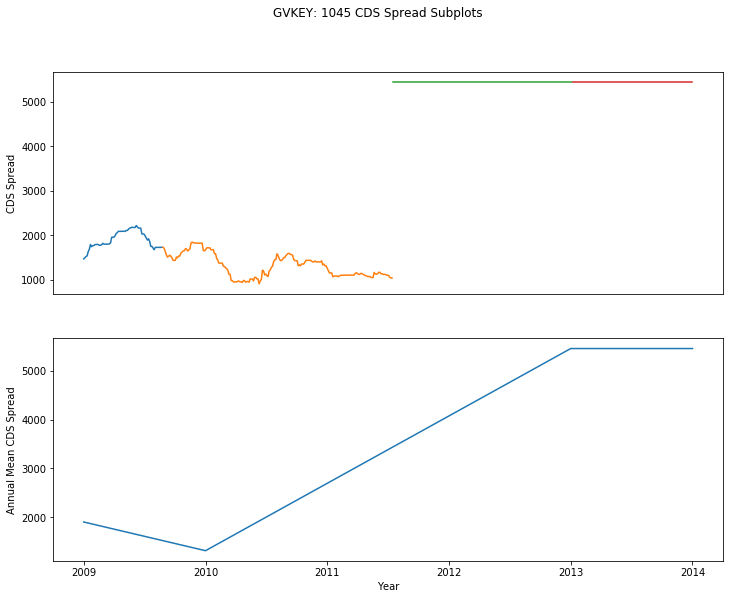

In [19]:
#insert GVKEY, view evolution of the key's CDS series & annual mean changes
gvkey_selection = 1045

gvkey_group_df = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]
print(" COMPANY NAME IS: ", gvkey_group_df.company_name.iloc[0], '\n', "COMPANY SECTOR: ", gvkey_group_df.sector.iloc[0])

#GVKEY's mean CDS spread
print(" GVKEY ({}) CDS MEAN IS: ".format(gvkey_selection),
     np.round(sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'].mean(),2))

#GVKEY's CDS spread standard deviation
print(" GVKEY ({}) CDS STANDARD DEVIATION IS: ".format(gvkey_selection),
     np.round(sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'].std(),2))

#GVKEY's CDS spread normalised standard deviation:
print(" GVKEY ({}) CDS NORMALISED STANDARD DEVIATION IS: ".format(gvkey_selection),
     np.round((sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'].std() / 
               sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'].mean()),2))

## CONSTRUCT THE PLOTS: 
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
fig.suptitle('GVKEY: {} CDS Spread Subplots'.format(gvkey_selection))

gvkey_group_df.groupby(['year_index'])['market_cds_spread'].plot(ax=ax1)
ax1.set_ylabel('CDS Spread')
ax1.axes.get_xaxis().set_visible(False)

gvkey_group_df.groupby(['year_index']).mean()['market_cds_spread'].plot(ax=ax2);
ax2.set_ylabel('Annual Mean CDS Spread')
ax2.set_xlabel('Year');

print('\n', " GVKEY ({}) DESCRIPTIVE OVERVIEW: ".format(gvkey_selection), '\n', 
     np.round(sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'].describe(),2))

#### Broad Overview of ZA Results: 
* SPECIFICATION: 
    * Trend parameter = "t" (testing for a continuous, uninterupted series)
    * The breakpoint is determined by working backwards from the maximum lag under the t-statistic

In [38]:
za_results_trendbreak_stat = df_za_results.loc[df_za_results.Outcome=='trend/break stationary']
print("Number of Trend/Break Stationary GVKEYS: {}".format(len(za_results_trendbreak_stat)))

za_results_unitroot_sbreak = df_za_results.loc[df_za_results.Outcome=='unitroot/structural break']
print("unitroot/structural break GVKEYS: {}".format(len(za_results_unitroot_sbreak)))

#unitroot_to_stat_ratio = (len(za_results_trendbreak_stat) / len(za_results_unitroot_sbreak))
print('\n', "PERCENT OF TREND/BREAK STATIONARY GVKEYS TO UNIT_ROOTS/STRUCTURAL_BREAKS {:.2f}%".format(
    len(za_results_trendbreak_stat) / len(za_results_unitroot_sbreak)))

Number of Trend/Break Stationary GVKEYS: 54
unitroot/structural break GVKEYS: 321

 PERCENT OF TREND/BREAK STATIONARY GVKEYS TO UNIT_ROOTS/STRUCTURAL_BREAKS 0.17%


#### Alternative Test Procedures: 
* Testing with Trend Parameter (t) and optimising with BIC (maxlags=10) results in 326 UR and 49 stationary 
* Testing with Trend Parameter (c) and optimising with t-stat (maxlags=10) results in 259 UR and 116 stationary
* Testing with Trend Parameter (c) and optimising with BIC (maxlags=10) results in 260 UR and 115 stationary

 COMPANY ==  BARRICK GOLD CORP 
 SECTOR ==   Materials
 GVKEY (2055) STANDARD DEVIATION IS:  0.16


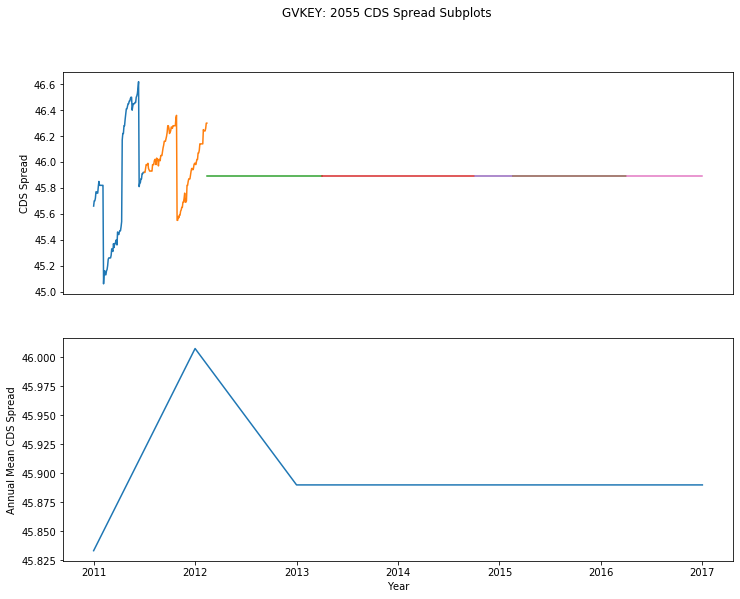

In [17]:
#move to reg primer? 




#miniuscule STD_DEV issue often == trend/break stationary 


#insert GVKEY, view evolution of the key's CDS series & annual mean changes
gvkey_selection = 2055

gvkey_group_df = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]
print(" COMPANY == ", gvkey_group_df.company_name.iloc[0], '\n', "SECTOR ==  ", gvkey_group_df.sector.iloc[0])

#view that GVKEY's standard deviation too
print(" GVKEY ({}) STANDARD DEVIATION IS: ".format(gvkey_selection),
     np.round(sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'].std(),2))


#PLOT: 

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
fig.suptitle('GVKEY: {} CDS Spread Subplots'.format(gvkey_selection))

gvkey_group_df.groupby(['year_index'])['market_cds_spread'].plot(ax=ax1)
ax1.set_ylabel('CDS Spread')
ax1.axes.get_xaxis().set_visible(False)


gvkey_group_df.groupby(['year_index']).mean()['market_cds_spread'].plot(ax=ax2);
ax2.set_ylabel('Annual Mean CDS Spread')
ax2.set_xlabel('Year');
                       

## PROBLEM GVKEYS
* Do problematic GVKEYS exhibit a common underlying feature? 

In [39]:
za_problem_df
#all have nearly == 0 STD DEV

,gvkey,first_obs_date,last_obs_date,length_days,size_dif,group_cds_stddev,problem_sector
0,5671,2009-06-15,2010-09-30,472,-133,3.70028e-13,Consumer Cyclical
1,5862,2016-04-01,2017-06-28,453,-129,2.9889e-13,Materials
2,6653,2013-05-21,2015-07-15,785,-223,0,Financials
3,7991,2008-01-16,2010-09-30,988,-378,3.6623e-13,Capital Goods
4,8551,2016-12-15,2017-06-30,197,-55,0.000236513,Consumer Cyclical
5,10187,2008-02-04,2008-11-05,275,-77,2.67129e-14,Financials
6,10443,2008-11-17,2010-09-30,682,-193,0,Consumer Cyclical
7,12459,2016-09-15,2017-06-30,288,-81,4.27359e-13,Consumer Cyclical
8,25180,2015-12-02,2017-06-29,575,-163,8.53688e-13,Capital Goods
9,25495,2012-04-16,2017-06-30,1901,-692,2.50215e-12,Utilities


In [45]:
#what is the distribution of sectors in the total DF? 

#sorted_alldata_df_final_adf_results.groupby(['year_index','sector']).median()['cds_bond_basis'].unstack()
sorted_alldata_df_final_adf_results.groupby(['year_index','sector']).mean()['market_cds_spread'].unstack()

sector,Capital Goods,Communication Services,Consumer Cyclical,Consumer Staples,Energy,Financials,Health Care,Materials,Technology,Transporation,Utilities
year_index,,,,,,,,,,,
2006,34.169048,NaN,39.587733,125.149711,59.842268,21.842005,NaN,26.838158,16.663077,21.666667,67.915000
2007,101.167580,71.733913,306.938163,120.441397,97.025283,53.689544,68.310031,47.024550,48.792986,31.150272,42.861645
2008,142.954892,147.763006,602.554256,131.576689,217.047051,350.324923,182.422669,198.331222,224.420387,102.207782,245.539523
2009,156.572395,161.243068,555.206319,151.511644,221.404872,563.148852,191.103500,285.489512,247.909231,194.616600,247.280325
2010,164.981954,253.977724,301.338431,164.045295,177.339171,262.073680,187.240836,157.583494,194.518129,296.944511,179.659232
2011,171.756405,292.719168,325.813543,181.683912,172.841414,334.353958,169.454260,182.797570,167.089747,211.737819,180.596349
2012,171.652082,296.629254,266.559354,179.970103,187.118618,312.477519,106.845675,204.086793,219.200444,296.817157,600.527957
2013,106.231422,218.314196,242.281734,126.196335,137.409727,175.114186,100.484108,185.208762,197.371809,460.010736,762.663377
2014,61.271698,137.485573,390.689373,110.874110,131.722074,149.581138,101.372726,153.667628,93.930451,316.502480,243.361793


In [ ]:
#try: 
basis_stats_yearind = np.round(df_basis_coupons_month.groupby('year_index').agg({'cds_bond_basis':['mean','median','std']}),2)

In [50]:
sorted_alldata_df_final_adf_results.groupby(['year_index','sector']).std()['market_cds_spread'].unstack()

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

In [ ]:


#change names: (see code below + take the np.round from here)
df_agg_year_yax_sector_xax_median_basis = np.round(df_agg_sector_year.groupby(['year_index','sector']).median()['cds_bond_basis'].unstack(),2)

In [ ]:
#creat

In [98]:
sorted_alldata_df_final.groupby(['sector','gvkey']).size()

sector         gvkey 
Capital Goods  1300      2374
               1913      1038
               1988      1081
               2285       929
               2393       523
                         ... 
Utilities      25495     1209
               25627     1876
               65092     1731
               135990    1932
               140977     267
Length: 388, dtype: int64

In [93]:
#check earlier code for improvement (firm size by sector? )
sorted_alldata_df_final.groupby(['sector']).size()

sector
Capital Goods             40115
Communication Services    15265
Consumer Cyclical         75948
Consumer Staples          66417
Energy                    42617
Financials                50476
Health Care               31186
Materials                 52417
Technology                33902
Transporation             18482
Utilities                 31422
dtype: int64

In [9]:
sorted_alldata_df_final.loc[sorted_alldata_df_final.gvkey==5862]['market_cds_spread'].std()

2.9888955478472275e-13

In [112]:
sorted_alldata_df_final.groupby('gvkey').size()

gvkey
1045       546
1078       620
1161      1885
1209      1471
1300      2374
          ... 
175263     265
176404    2092
176760    1760
179657     523
179700    1498
Length: 391, dtype: int64

In [ ]:
#reformat ADF to show when one series is stat vs UR? 

# COMPILE DUMMY-CODE BASED ON REGRESSION TYPE
* (VAR_IL) = VaR Regression in-levels, for series where both CDS/BONDS are stationary 
* (VAR_MIX) = Where on series had a unit-root? 
* (VECM) = Both series have Unit Roots, evidence of a cointegrating relationship
* (VAR_ID) = Unit Roots, but no evidence of cointegration 

In [23]:
df_stat_cdsbond_results.head()

,gvkey,sector,CDS,CDS_pval,Bond,BOND_pval,VIX,VIX_pval,Joint_Test_Outcome,bic_lag,date_start,date_end,length_days
0,1045,Transporation,-1.0934,0.7177,-4.4743***,0.0002,-2.9543**,0.0394,CDS ONLY HAS UR,1,2009-09-24,2014-05-30,1709
1,1078,Health Care,-1.357,0.6027,-1.2011,0.6731,-2.4359,0.1319,BOND/CDS Both Have Unit Root,1,2008-03-17,2010-09-30,927
2,1161,Technology,-2.0657,0.2585,-2.2804,0.1784,-5.6409***,0,BOND/CDS Both Have Unit Root,2,2008-04-10,2017-06-30,3368
3,1209,Materials,-1.7596,0.4007,-1.5329,0.5172,-4.4417***,0.0003,BOND/CDS Both Have Unit Root,1,2011-07-28,2017-06-30,2164
4,1300,Capital Goods,-2.5216,0.1103,-2.5023,0.1149,-3.9176***,0.0019,BOND/CDS Both Have Unit Root,2,2007-12-14,2017-03-01,3365


In [16]:
gvkey_adf_results_miniframe = df_stat_cdsbond_results[['gvkey','Joint_Test_Outcome','length_days']]

In [18]:
sorted_alldata_df_final_adf_results = sorted_alldata_df_final.merge(gvkey_adf_results_miniframe, how='left',on='gvkey')

In [22]:
sorted_alldata_df_final_adf_results.head()

,gvkey,trade_date,bond_sym_id,price,issue_id,bond_in_mergent,coupon,interest_frequency,coupon_type,maturity_date,secured,seniority,years_to_maturity,riskfree_rate_1yr,riskfree_rate_2yr,...,company_name,trading_vol_daily,price_close,price_high,price_low,price_open,eps,price_sales,price_cashflow,gross_profit_ta,capital_ratio,debt_eq_ratio,rnd_sales,Joint_Test_Outcome,length_days
0,1045,2009-09-24,AMR.UY,103.1100,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.056914,0.58,1.24,...,AMERICAN AIRLINES GROUP INC,34493080.0,7.74,8.03,7.63,7.91,-3.51,0.071,-0.949,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709
1,1045,2009-09-25,AMR.UY,107.0000,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.054176,0.62,1.29,...,AMERICAN AIRLINES GROUP INC,31763720.0,8.02,8.14,7.90,7.94,-3.51,0.071,-0.949,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709
2,1045,2009-09-28,AMR.UY,104.2500,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.045963,0.62,1.30,...,AMERICAN AIRLINES GROUP INC,13330220.0,8.00,8.20,7.90,8.06,-3.51,0.071,-0.949,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709
3,1045,2009-09-29,AMR.UY,105.7500,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.043225,0.64,1.33,...,AMERICAN AIRLINES GROUP INC,16459960.0,8.00,8.25,7.98,8.06,-3.51,0.071,-0.949,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709
4,1045,2009-09-30,AMR.UY,105.6268,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.040487,0.63,1.30,...,AMERICAN AIRLINES GROUP INC,18732570.0,7.95,8.12,7.71,8.02,-3.51,0.121,-1.623,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709


In [24]:
#sorted_alldata_df_final_adf_results.to_pickle("./sorted_alldata_df_final_adf_results.pkl")
sorted_alldata_df_final_adf_results = pd.read_pickle("./sorted_alldata_df_final_adf_results.pkl")

# COMPARE ZA & ADF RESULTS? 

<a id='variance_ratio_test'></a>


# Variance Ratio Test: 

In [68]:
#single GVKEY: VarianceRatio test:
gvkey_number = 174729
gvkey_frame = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_number]

print("Variance Ratio Test with individual GVKEY NUMBER: {}".format(gvkey_number))

cds_vr = gvkey_frame['market_cds_spread']
pecds_vr = gvkey_frame['pecds']
#data_vr = pd.DataFrame(data=(cds, pecds)).T
#data = np.column_stack((cds, pecds))

variance_ratio_model = VarianceRatio(cds_vr, trend='c', robust=True, lags=10)      
variance_ratio_model.summary()  


Variance Ratio Test with individual GVKEY NUMBER: 174729


Test Statistic,-0.977
P-value,0.328
Lags,10


In [69]:
variance_ratio_model.vr

0.700212568498119

In [10]:
variance_ratio_model.null_hypothesis

'The process is a random walk.'

In [18]:
variance_ratio_model.alternative_hypothesis

'The process is not a random walk.'

In [11]:
see(variance_ratio_model)

    <                   <=                  ==                  !=                  >                   >=
    dir()               hash()              help()              repr()              str()
    .alternative_hypothesis                 .critical_values    .debiased           .lags               .nobs
    .null_hypothesis    .overlap            .pvalue             .robust             .stat               .summary()
    .trend              .valid_trends       .vr                 .y

In [19]:
variance_ratio_model.critical_values

{'1%': -2.3263478740408408,
 '5%': -1.6448536269514729,
 '10%': -1.2815515655446004,
 '90%': 1.2815515655446004,
 '95%': 1.6448536269514722,
 '99%': 2.3263478740408408}

In [16]:
variance_ratio_model.critical_values['95%']

1.6448536269514722

 COMPANY ==  AIR PRODUCTS & CHEMICALS INC 
 SECTOR ==   Materials
 GVKEY (1209) STANDARD DEVIATION IS:  12.62


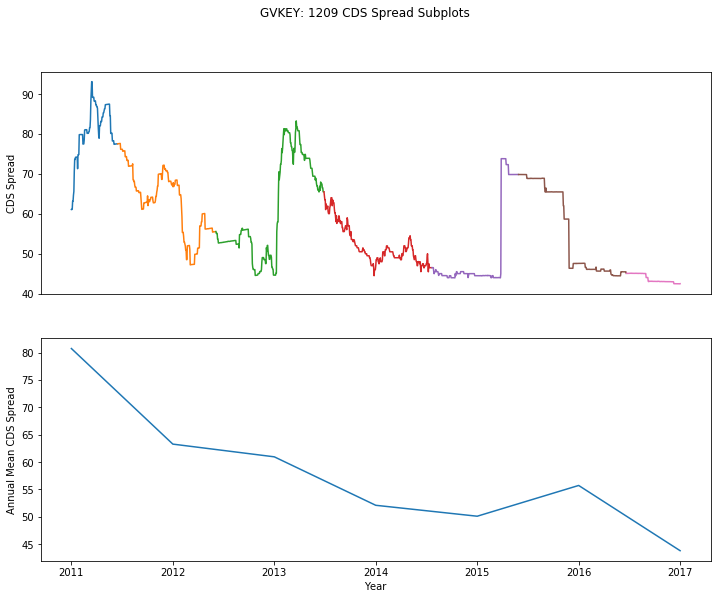

In [77]:
gvkey_selection = 1209
#other keys: 1045 / 2184 / 1045

gvkey_group_df = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]
print(" COMPANY == ", gvkey_group_df.company_name.iloc[0], '\n', "SECTOR ==  ", gvkey_group_df.sector.iloc[0])

#view that GVKEY's standard deviation too
print(" GVKEY ({}) STANDARD DEVIATION IS: ".format(gvkey_selection),
     np.round(sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]['market_cds_spread'].std(),2))


#PLOT: 

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
fig.suptitle('GVKEY: {} CDS Spread Subplots'.format(gvkey_selection))

gvkey_group_df.groupby(['year_index'])['market_cds_spread'].plot(ax=ax1)
ax1.set_ylabel('CDS Spread')
ax1.axes.get_xaxis().set_visible(False)


gvkey_group_df.groupby(['year_index']).mean()['market_cds_spread'].plot(ax=ax2);
ax2.set_ylabel('Annual Mean CDS Spread')
ax2.set_xlabel('Year');
                       

# Variance Ratio Loop

# see that old GARCH webpage for running a loop for each GVKEY, which uses lags [5, 10, 20, and maybe some %?] and then aggreg the results in one DF? 

In [75]:
gvkey_list = []                        
sector_list = []   
vr_ratio = [] 
vr_stat = []
vr_pvalue = []
significance_level = []
vr_test_outcome = []
infeasible_test_errors = 0
vr_significance = []


for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    #append general data regarding each group
    gvkey = val[0]
    data = val[1]                        
    gvkey_list.append(gvkey)             
    sector_string = data.sector
    sector_list.append(sector_string.iloc[0])  
    cds_varianceratio = data.market_cds_spread
    #data_df = pd.DataFrame(data=(data.market_cds_spread)).T
    data_df = np.column_stack(cds_varianceratio)
    
    try: 
        variance_ratio_model_loop = VarianceRatio(data_df, trend='c', overlap=True, debiased=True, 
                                                  robust=True, lags=10)   

        #append the variance ratio itself 
        vr_ratio.append(np.round(variance_ratio_model_loop.vr,4))

        #append the test-statistic of the variance ratio
        vr_stat.append(np.round(variance_ratio_model_loop.stat,4))

        #append Variance Ratio's P-value:
        vr_pvalue.append(np.round(variance_ratio_model_loop.pvalue,4))

        #append the level of significance 
        ## significant at or above 99%
        if (variance_ratio_model_loop.stat >= variance_ratio_model_loop.critical_values['99%']) and (
        variance_ratio_model_loop.pvalue <= 0.05):
            significance_level.append("***")
            vr_test_outcome.append(variance_ratio_model_loop.alternative_hypothesis)
            continue

        ## significant above 95%
        elif (variance_ratio_model_loop.stat >= variance_ratio_model_loop.critical_values['95%']) and (
        variance_ratio_model_loop.pvalue <= 0.05): 
            significance_level.append("**")
            vr_test_outcome.append(variance_ratio_model_loop.alternative_hypothesis)
            continue

        ## not significant at a minimum of 95%
        else: 
            significance_level.append(" ")
            vr_test_outcome.append(variance_ratio_model_loop.null_hypothesis)
            continue

        
#    except (ValueError) as ve:
#        print("GVKEY: {}".format(gvkey), "from sector: {}".format(sector_string.iloc[0]))
        
    except (RuntimeWarning) as rtw:
        print("RunTime Warning, Row {}, Reason: {}".format(i, rtw), 
              "GVKEY ({})".format(gvkey), 
              "from sector: {}".format(sector_string.iloc[0]))        

#combine the test-stat with its respective significance level indicator (***, ** or nothing)
vr_significance = ["{}{}".format(vr_stat, significance_level) for vr_stat, significance_level in zip(vr_stat, significance_level)]     

#create DF and re-name columns:
variance_ratio_df = pd.DataFrame(data=(gvkey_list, sector_list, 
                                       vr_ratio, vr_significance, vr_pvalue, vr_test_outcome)).T

variance_ratio_df.columns = ['gvkey','sector','variance_ratio','vr_test_stat','vr_pvalue','vr_outcome']

C:\Users\JasonSpano\anaconda3\lib\site-packages\arch\unitroot\unitroot.py:1744: RuntimeWarning: invalid value encountered in double_scalars
  delta = nq * z2[k:] @ z2[:-k] / scale
C:\Users\JasonSpano\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\JasonSpano\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\JasonSpano\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [ ]:
#        elif (variance_ratio_model_loop.stat < variance_ratio_model_loop.critical_values['95%']) and ((
#        variance_ratio_model_loop.pvalue > 0.05) or (variance_ratio_model_loop.pvalue < 0.05)): 
#            significance_level.append(" ")
#            vr_test_outcome.append(variance_ratio_model_loop.null_hypothesis)

In [76]:
variance_ratio_df

,gvkey,sector,variance_ratio,vr_test_stat,vr_pvalue,vr_outcome
0,1045,Transporation,1.017,0.8602,0.3897,The process is a random walk.
1,1078,Health Care,1.3438,1.9589,0.0501,The process is a random walk.
2,1161,Technology,1.4205,3.5354***,0.0004,The process is not a random walk.
3,1209,Materials,1.4221,4.4863***,0,The process is not a random walk.
4,1300,Capital Goods,1.3533,1.9726**,0.0485,The process is not a random walk.
...,...,...,...,...,...,...
386,175263,Consumer Cyclical,0.6621,-0.7,0.4839,The process is a random walk.
387,176404,Communication Services,1.4225,3.6395***,0.0003,The process is not a random walk.
388,176760,Materials,1.992,4.8891***,0,The process is not a random walk.
389,179657,Capital Goods,NaN,nan,NaN,The process is a random walk.


# (JOHANSEN) COINTEGRATION TEST

* SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.select_coint_rank.html#statsmodels.tsa.vector_ar.vecm.select_coint_rank

* TRACE VS EIG: 
    * http://rizaudinsahlan.blogspot.com/2017/09/johansen-cointegration-test-with-eviews_93.html
    * file:///C:/Users/JasonSpano/OneDrive/Uva%20Msc%2019-20%20Subjects/Research%20Assistant%20Docs/CDS_project_-_first_set_of_tasks/Part%202_jan20/Johansen1.pdf
    
* Source CODE: 
    * https://www.statsmodels.org/stable/_modules/statsmodels/tsa/vector_ar/vecm.html#select_coint_rank

In [8]:
sorted_alldata_df_final_adf_results.head(2)

,gvkey,trade_date,bond_sym_id,price,issue_id,bond_in_mergent,coupon,interest_frequency,coupon_type,maturity_date,secured,seniority,years_to_maturity,riskfree_rate_1yr,riskfree_rate_2yr,...,company_name,trading_vol_daily,price_close,price_high,price_low,price_open,eps,price_sales,price_cashflow,gross_profit_ta,capital_ratio,debt_eq_ratio,rnd_sales,Joint_Test_Outcome,length_days
0,1045,2009-09-24,AMR.UY,103.11,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.056914,0.58,1.24,...,AMERICAN AIRLINES GROUP INC,34493080.0,7.74,8.03,7.63,7.91,-3.51,0.071,-0.949,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709
1,1045,2009-09-25,AMR.UY,107.00,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.054176,0.62,1.29,...,AMERICAN AIRLINES GROUP INC,31763720.0,8.02,8.14,7.90,7.94,-3.51,0.071,-0.949,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709


In [31]:
UR_ONLY_DF = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.Joint_Test_Outcome=='BOND/CDS Both Have Unit Root']

In [33]:
UR_ONLY_DF.groupby('gvkey')['Joint_Test_Outcome'].nunique()

gvkey
1078      1
1161      1
1209      1
1300      1
1408      1
         ..
174130    1
174490    1
174729    1
176404    1
176760    1
Name: Joint_Test_Outcome, Length: 259, dtype: int64

In [22]:
#single GVKEY: cointegration test:

gvkey_1408 = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==1408]

gvkey_number = 1408
gvkey_frame = gvkey_1408
print("JOHANSENS COINT TEST with individual GVKEY NUMBER: " + str(gvkey_number))

cds = gvkey_frame['market_cds_spread']
pecds = gvkey_frame['pecds']
data = pd.DataFrame(data=(cds, pecds)).T
#data = np.column_stack((cds, pecds))

model = vecm.select_order(data, maxlags=5)
optimal_lag_length = model.bic
print("Optimal Lag Lengths == {}".format(optimal_lag_length))
    
vecm_cointeg_rank = vecm.select_coint_rank(data, det_order =1, k_ar_diff = optimal_lag_length, 
                                                  method='maxeig', signif=0.05)
        
print(vecm_cointeg_rank.summary())
print("Number of Cointegrating relationships:", vecm_cointeg_rank.rank)

JOHANSENS COINT TEST with individual GVKEY NUMBER: 1408
Optimal Lag Lengths == 3
Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          15.16          17.15
-------------------------------------
Number of Cointegrating relationships: 0


In [14]:
see(vecm_cointeg_rank)

    <              <=             ==             !=             >              >=             dir()          hash()
    help()         repr()         str()          .crit_vals     .method        .neqs          .r_1           .rank
    .signif        .summary()     .test_stats

In [20]:
vecm_cointeg_rank.test_stats

array([20.24521842,  5.08897601])

In [ ]:
#adjust this to add a (!) marker? Where coint_rels >= 2


#inspect the maxlag subject to bic? 

#https://www.statsmodels.org/stable/_modules/statsmodels/tsa/vector_ar/vecm.html#select_coint_rank

#try change BIC TO AIC? 

In [32]:
#UPDATED COINT TEST: 

#create list for the general items
gvkey_list = []                        
sector_list = []                       

#create lists for the cointegration test items:
optimal_lag_list = []
cointeg_rank_list = []                      #number of cointegrating relationships, expressed as (int)
cointeg_teststats_list = []                 #the test statistic for >= (1) cointegrating relationship                 
coint_signif = []                           #will hold the string information for compiling latex table
pass_boolean = []                           #will hold a string conclusion of the outcome for each GVKEY
data_type_tracker = []
vecm_rank_level = []                        #will hold cointegrating equation significances (for 1 and 2 coint equations)

#keep track of error numbers:
problem_argument_instances = []             #hold duplicate error messages to avoid clutter in some parts 
value_error_counter = 0
optimal_lags_zero_count = 0 

#run the cointegration test for each GVKEY group in the DF:
for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):
    gvkey = val[0]
    data = val[1]                        
    gvkey_list.append(gvkey)             
    sector_string = data.sector
    sector_list.append(sector_string.iloc[0])   
    
    #insert a boolean to filter the DF for valid and not valid cointegration test scenarios 
    #cointegration is only valid if both series are integrated of the same order, but viewing all results could be interesting
    if data.Joint_Test_Outcome.iloc[0]=="BOND/CDS Both Have Unit Root":
        data_type_tracker.append("coint_test_valid")
    else: 
        data_type_tracker.append("coint_test_not_valid")
    
    #load data for model -- column_stack is quicker here as the DF method is not needed
    cds = data.market_cds_spread
    pecds = data.pecds
    data = pd.DataFrame(data=(cds, pecds)).T
    #data = np.column_stack((cds, pecds))
    
    try:
        model = vecm.select_order(data, maxlags=5)
        optimal_lag_length = model.bic
        optimal_lag_list.append(optimal_lag_length)
        
        #for curiosity, track how many GVKEYS have a bic-optimised lag of 0
        if optimal_lag_length <= 0:
            optimal_lags_zero_count += 1
       
        vecm_cointeg_rank = vecm.select_coint_rank(data, det_order =0, k_ar_diff = optimal_lag_length, 
                                                  method='trace', signif=0.05)

        #Because statsmodels does not enforce the rule that maximum cointegrating-eqs must be < number of series in the system
        #E.G. the system has two series (CDS+BOND) and hence, the maximum #cointegrating eqs is (2 - 1) == 1 
        #wherever an instance of a rank >1 occurs, mark it with a (*)
        if vecm_cointeg_rank.rank > 1:
            vecm_rank_level.append("*")
            cointeg_rank_list.append(int(1))
        else: 
            vecm_rank_level.append(" ")
            cointeg_rank_list.append(vecm_cointeg_rank.rank) 
            
        #FLAG FOR DELETION! 
        try:
            test_statistic = vecm_cointeg_rank.test_stats[0]
            cointeg_teststats_list.append(np.round(vecm_cointeg_rank.test_stats[0], 4))
            
            #append the significance of each GVKEY's test_statistic (** / *** for > 95%; otherwise  <95% == fail)
            if test_statistic >= vecm_cointeg_rank.crit_vals[0]:
                coint_signif.append("**")                                      #significant above 95%
                pass_boolean.append("Reject_H0")
            else:
                coint_signif.append(" ")
                pass_boolean.append("Fail_Reject_H0")            
            
        except IndexError as ts_index_error:
            print("IndexError: Row: {}, Reason : {} ".format(i, ts_index_error), "GVKEY: {}".format(gvkey))
           
        #perhaps not needed? 
        #if (data.Joint_Test_Outcome.iloc[0]=="BOND/CDS Both Have Unit Root") and (vecm_cointeg_rank.rank > 1:):
            #something.append(?)
        
    #catch the ValueError of either: NaN or Infs   - print full traceback only once, then just GVKEY/SECTOR
    except (ValueError) as ve:
        value_error_instance = str(ve.args)
        if value_error_instance not in problem_argument_instances:
            print("ValueError: Row: {}, Reason : {} ".format(i, ve), '\n',
                  "Total Value Errors: ", '\n')
            problem_argument_instances.append(value_error_instance)
            
        print("GVKEY: {}".format(gvkey), "from sector: {}".format(sector_string.iloc[0]))
        value_error_counter += 1
        
        #append items to main lists to maintain placement consistency of data items: 
        optimal_lag_list.append("VE_ERROR")
        cointeg_rank_list.append("VE_ERROR")
        cointeg_teststats_list.append("VE_ERROR")
        coint_signif.append("_N/A")
        vecm_rank_level.append("_N/A")
        pass_boolean.append("VE_ERROR")
        
#compiles the asterisk to mark any GVKEYS with an (invalid) #cointegrating equations; that is, >1 in this case            
coint_eqs = ["{}{}".format(cointeg_rank_list, vecm_rank_level) for cointeg_rank_list, vecm_rank_level in zip(cointeg_rank_list, vecm_rank_level)] 

#will denote those test statistics which manage to reject the null hypothesis with (**); otherwise nothing
coint_sig = ["{}{}".format(cointeg_teststats_list, coint_signif) for cointeg_teststats_list, coint_signif in zip(cointeg_teststats_list, coint_signif)]  

#assemble the DF 
df_coint_rank = pd.DataFrame(data=(gvkey_list, coint_eqs, 
                                       coint_sig, pass_boolean, optimal_lag_list, data_type_tracker)).T

#rename the DF's columns
df_coint_rank.columns = ['gvkey','coint_rank', 'cointegration_test_stat','outcome', "BIC_lags", 'test_type'] 

#print some overview facts about the outcomes of the cointegrating testing loops 
print('\n', " Optimal GVKEY Lag Lengths With Zero in BIC Framework: {}".format(optimal_lags_zero_count), 
      '\n', " Total # Value Errors ({})".format(value_error_counter))    
        

C:\Users\JasonSpano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: Row: 105, Reason : x contains a constant. Adding a constant with trend='c' is not allowed.  
 Total Value Errors:  

GVKEY: 5671 from sector: Consumer Cyclical
GVKEY: 5862 from sector: Materials
GVKEY: 6653 from sector: Financials
GVKEY: 7991 from sector: Capital Goods
GVKEY: 8551 from sector: Consumer Cyclical
GVKEY: 10187 from sector: Financials
GVKEY: 10443 from sector: Consumer Cyclical
GVKEY: 12459 from sector: Consumer Cyclical
GVKEY: 25180 from sector: Capital Goods
GVKEY: 25495 from sector: Utilities
GVKEY: 30219 from sector: Consumer Cyclical
GVKEY: 30671 from sector: Capital Goods
GVKEY: 64768 from sector: Consumer Cyclical
GVKEY: 64891 from sector: Consumer Cyclical
GVKEY: 137024 from sector: Energy
GVKEY: 179657 from sector: Capital Goods

  Optimal GVKEY Lag Lengths With Zero in BIC Framework: 246 
  Total # Value Errors (16)


In [33]:
df_coint_rank.head(30)

,gvkey,coint_rank,cointegration_test_stat,outcome,BIC_lags,test_type
0,1045,1,18.146**,Reject_H0,0,coint_test_not_valid
1,1078,0,10.0436,Fail_Reject_H0,0,coint_test_valid
2,1161,0,10.4998,Fail_Reject_H0,1,coint_test_valid
3,1209,0,12.3264,Fail_Reject_H0,0,coint_test_valid
4,1300,0,12.1631,Fail_Reject_H0,1,coint_test_valid
5,1356,1*,18.7427**,Reject_H0,1,coint_test_not_valid
6,1380,0,14.3431,Fail_Reject_H0,0,coint_test_not_valid
7,1408,0,12.732,Fail_Reject_H0,3,coint_test_valid
8,1440,0,12.1694,Fail_Reject_H0,0,coint_test_valid
9,1447,0,6.2934,Fail_Reject_H0,0,coint_test_not_valid


 COMPANY ==  BEST BUY CO INC 
 SECTOR ==   Consumer Cyclical


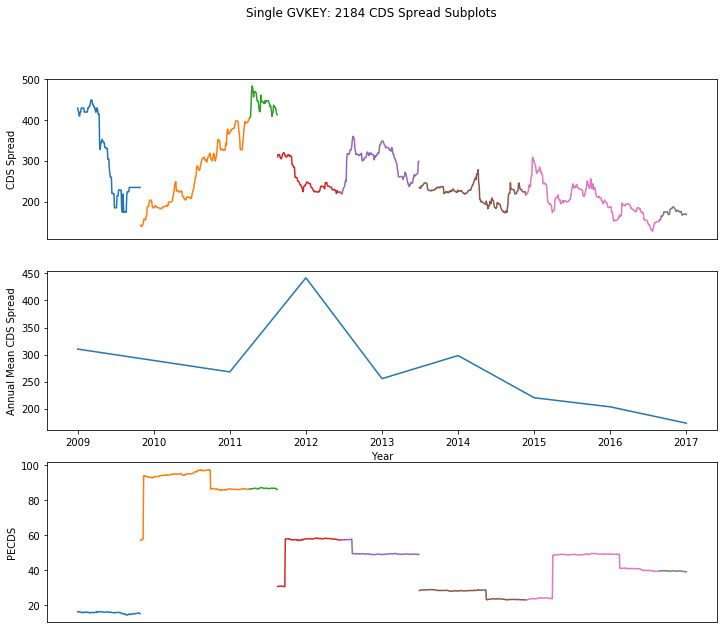

In [7]:
#infographic of GVKEY: 

#insert GVKEY, view evolution of the key's CDS series & annual mean changes
gvkey_selection = 2184

gvkey_group_df = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==gvkey_selection]
print(" COMPANY == ", gvkey_group_df.company_name.iloc[0], '\n', "SECTOR ==  ", gvkey_group_df.sector.iloc[0])

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10))
fig.suptitle('Single GVKEY: ({}) CDS Spread Subplots'.format(gvkey_selection))

gvkey_group_df.groupby(['year_index'])['market_cds_spread'].plot(ax=ax1)
ax1.set_ylabel('CDS Spread')
ax1.axes.get_xaxis().set_visible(False)


gvkey_group_df.groupby(['year_index']).mean()['market_cds_spread'].plot(ax=ax2);
ax2.set_ylabel('Annual Mean CDS Spread')
ax2.set_xlabel('Year')

gvkey_group_df.groupby(['year_index'])['pecds'].plot(ax=ax3)
ax3.set_ylabel('PECDS')
ax3.axes.get_xaxis().set_visible(False);
                       

In [20]:
print(gvkey_group_df[['trade_date','market_cds_spread']].to_string())

#scale of the graph is slightly off!

      trade_date  market_cds_spread
30183 2009-01-26             429.57
30184 2009-01-27             424.69
30185 2009-01-28             419.81
30186 2009-01-29             410.05
30187 2009-01-30             410.05
30188 2009-02-02             419.81
30189 2009-02-03             419.81
30190 2009-02-04             429.57
30191 2009-02-05             429.57
30192 2009-02-06             429.57
30193 2009-02-09             429.57
30194 2009-02-10             429.57
30195 2009-02-11             429.57
30196 2009-02-12             419.81
30197 2009-02-13             419.81
30198 2009-02-16             419.81
30199 2009-02-17             419.81
30200 2009-02-18             419.81
30201 2009-02-19             419.81
30202 2009-02-20             419.81
30203 2009-02-23             429.57
30204 2009-02-24             429.57
30205 2009-02-25             431.94
30206 2009-02-26             434.48
30207 2009-02-27             434.48
30208 2009-03-02             444.24
30209 2009-03-03            

In [ ]:
#3 distinct regimes? 

In [ ]:
#take a look at that period with the gap

In [9]:
df_coint_rank_valid = df_coint_rank.loc[df_coint_rank.test_type=='coint_test_valid']

In [10]:
len(df_coint_rank_valid.loc[df_coint_rank_valid.outcome=='Reject_H0'])

32

In [11]:
df_coint_outcome_reject = df_coint_rank.loc[df_coint_rank.outcome=='Reject_H0']

In [12]:
len(df_coint_outcome_reject)

103

## DISCUSS IMPLICATIONS OF 32 >> 103

In [ ]:
#how many keys in the real project? 

# how to merge this outcome back onto full DF? 
## SEE ADF section? 

In [ ]:
#create "mini_frame"

#sorted_alldata_df_final_adf_results = sorted_alldata_df_final.merge(gvkey_adf_results_miniframe, how='left',on='gvkey')

## presentation 
* REVISEMENT NEEDED

In [ ]:
#OG CODE

#df_coint_rank_clean_sector = df_coint_rank_clean.merge(sectors_gvkey_df_grouped_short, how='left',on='gvkey')  #obsolete

df_coint_rank_clean_sector.loc[df_coint_rank_clean_sector.outcome=='Fail_Reject_H0']


In [ ]:

df_crcs_cointegrated = df_coint_rank_clean_sector.loc[df_coint_rank_clean_sector.outcome=='Reject_H0']
df_crcs_nocoint = df_coint_rank_clean_sector.loc[df_coint_rank_clean_sector.outcome=='Fail_Reject_H0']

In [ ]:
df_coint_test_totals = df_coint_rank_clean_sector.groupby('sector')['outcome'].size()

In [ ]:
df_cointegrated_size = df_crcs_cointegrated.groupby('sector')['outcome'].size()
df_nocoint_size = df_crcs_nocoint.groupby('sector')['outcome'].size()

In [ ]:
df_crcs_nocoint

In [ ]:
df_coint_rank_clean_sector['clean_ts_list'] = df_coint_rank_clean_sector['clean_ts_list'].astype(float)

In [ ]:
#add the stats based off full DF 
coint_describe_stats = df_coint_rank_clean_sector.groupby('sector').agg({'clean_ts_list':['mean','median']})
#nocoint_pval_avg = df_crcs_nocoint

In [ ]:
df_crcs_nocoint['clean_ts_list'] = df_crcs_nocoint['clean_ts_list'].astype(float)
df_crcs_cointegrated['clean_ts_list'] = df_crcs_cointegrated['clean_ts_list'].astype(float)

In [ ]:
df_crcs_nocoint_stats = df_crcs_nocoint.groupby('sector').agg({'clean_ts_list':['mean','median']})
df_crcs_cointegrated_stats = df_crcs_cointegrated.groupby('sector').agg({'clean_ts_list':['mean','median']})
df_crcs_nocoint_stats = np.round(df_crcs_nocoint_stats, 2)
df_crcs_cointegrated_stats = np.round(df_crcs_cointegrated_stats, 2)
#coint_describe_stats

In [ ]:
coint_describe_stats = np.round(coint_describe_stats, 2)

In [ ]:
coint_describe_stats
#partial DF 

In [ ]:
#splits cointeg vs no-coint median/mean + group sizes (~ 0.75 down msvecm_1.02 doc)

df_crcs_sizes_concat = pd.concat([df_cointegrated_size, df_crcs_cointegrated_stats, 
                                  df_nocoint_size, df_crcs_nocoint_stats], axis=1)

df_crcs_sizes_concat_df = pd.DataFrame(df_crcs_sizes_concat)

In [ ]:
df_crcs_sizes_concat_df

In [ ]:
df_crcs_sizes_concat_df.take([0],axis=1).sum()

In [ ]:
#
#print(df_crcs_sizes_concat_df.to_latex())
#90 COINT
#139 NO COINT
#229 STAT?

#ORIGINAL STATS!

# REGRESSIONS

## VAR MODELS / GRANGER-CAUSALITY TEST
* VAR/GCT in-levels (stationary series)
* VAR/GCT in-differences (unit-root series')
    * GCT test in the VAR framework: to be compared (authenticed by) the VECM framework

* do some sort of impulse response check? (See Econometrics with python / see the online docs)?



* VECM MODELING: 
    * (JOHANSEN?) Cointegration Rank + appropriate LAG length (BIC) from 'vecm_model_order'
        * Could try the: Phillips_Ouliaris cointegration framework? from arch.readthedocs
    * Can apply wald_test among the variables (instantaneous causality) + residuals_autocorrelations (test_whiteness)
    
* VECM MODEL + the price discovery measures 


* MS-VECM MODEL + regime  switching coefficients etc. 



#### Reapply process to: 
* Apply to weekly series? 
* ADF test / Zivot-Andrews >> VAR/GCT (overwhelming non-stat?) >> VECM > MS-VECM

# VAR REGRESSION

In [25]:
sorted_alldata_df_final_adf_results.head()

,gvkey,trade_date,bond_sym_id,price,issue_id,bond_in_mergent,coupon,interest_frequency,coupon_type,maturity_date,secured,seniority,years_to_maturity,riskfree_rate_1yr,riskfree_rate_2yr,...,company_name,trading_vol_daily,price_close,price_high,price_low,price_open,eps,price_sales,price_cashflow,gross_profit_ta,capital_ratio,debt_eq_ratio,rnd_sales,Joint_Test_Outcome,length_days
0,1045,2009-09-24,AMR.UY,103.1100,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.056914,0.58,1.24,...,AMERICAN AIRLINES GROUP INC,34493080.0,7.74,8.03,7.63,7.91,-3.51,0.071,-0.949,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709
1,1045,2009-09-25,AMR.UY,107.0000,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.054176,0.62,1.29,...,AMERICAN AIRLINES GROUP INC,31763720.0,8.02,8.14,7.90,7.94,-3.51,0.071,-0.949,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709
2,1045,2009-09-28,AMR.UY,104.2500,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.045963,0.62,1.30,...,AMERICAN AIRLINES GROUP INC,13330220.0,8.00,8.20,7.90,8.06,-3.51,0.071,-0.949,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709
3,1045,2009-09-29,AMR.UY,105.7500,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.043225,0.64,1.33,...,AMERICAN AIRLINES GROUP INC,16459960.0,8.00,8.25,7.98,8.06,-3.51,0.071,-0.949,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709
4,1045,2009-09-30,AMR.UY,105.6268,504701.0,True,6.25,2.0,F,20141015.0,NaN,1.0,5.040487,0.63,1.30,...,AMERICAN AIRLINES GROUP INC,18732570.0,7.95,8.12,7.71,8.02,-3.51,0.121,-1.623,0.134,1.288,-13.427,0.0,CDS ONLY HAS UR,1709


In [ ]:
#old results have list placement error (flawed)

In [ ]:
res.test_whiteness(nlags=5, signif=0.05).summary()
#portmanteau-test for residual autocorr

In [ ]:
print(len(df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=="BOND/CDS Both Have Unit Root"]))
print(len(df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=="BOND ONLY HAS UR"]))
print(len(df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=="CDS ONLY HAS UR"]))
print(len(df_stat_cdsbond_results.loc[df_stat_cdsbond_results.Joint_Test_Outcome=="Cannot Reject H0"]))

#option for errorS? 
#        #res = model.fit(maxlags=10, method='ols',ic=None, trend='nc')

In [ ]:
#consider swapping summary.str.conclusion for manual appraisal of GC or does not GC

## INSERT THIS AFTER COINTEGRATION TEST SO THE DIF IS LABELLED

In [28]:
#VaR Regression Output Lists: 
cds_resc_ts = []; bond_resc_ts = []
cds_resc_cv = []; bond_resc_cv = []  
cds_signif = []; bond_signif = []
cds_resc_pval = []; bond_resc_pval = []
cds_resc_concl = []; bond_resc_concl = []

#GVKEY group general data list:
gvkey_list = []; sector_list = []
test_type = []
both_stat_counter = 0; cds_stat_counter = 0; bond_stat_counter = 0; unitroot_counter = 0; adf_errors_counter = 0

#lists to hold potential problem elements: 
var_problem_gvkeys = []                                  #to record any GVKEYs with VaR regression errors
linalg_error_counter = 0; value_error_counter = 0; rte_counter = 0


for i, val in enumerate(sorted_alldata_df_final_adf_results.groupby('gvkey')):  
    #append GVKEY & its respective sector to list
    gvkey = val[0]; data = val[1]
    gvkey_list.append(gvkey)   
    sector_string = data.sector
    sector_list.append(sector_string.iloc[0])                       
    
    #add in cointegration switch here? 
    
    if data.Joint_Test_Outcome.iloc[0]=="Cannot Reject H0":                 #both series are stationary 
        both_stat_counter += 1
        test_type.append("both_stat")
        cds = data.market_cds_spread                                #initialise both series in their original forms
        pecds = data.pecds
        data = pd.DataFrame(data=(cds, pecds)).T  
        #continue
        
    elif data.Joint_Test_Outcome.iloc[0]=="CDS ONLY HAS UR":                 #only CDS has a unit-root (bond is stat)
        cds_stat_counter +=1 
        test_type.append("cds_only_stat")
        cds = data.market_cds_spread  
        pecds = data.pecds
        data = pd.DataFrame(data=(cds, pecds)).T  
        #continue
        
    elif data.Joint_Test_Outcome.iloc[0]=="BOND ONLY HAS UR":                #only bond has a unit-root (CDS is stat)
        bond_stat_counter += 1
        test_type.append("bond__only_stat")
        cds = data.market_cds_spread
        pecds = data.pecds
        data = pd.DataFrame(data=(cds, pecds)).T              
        #continue
        
    elif data.Joint_Test_Outcome.iloc[0]=="BOND/CDS Both Have Unit Root":   
        unitroot_counter += 1
        test_type.append("both_unitroot")
        cds = data.market_cds_spread.diff().dropna()
        pecds = data.pecds.diff().dropna()
        data = pd.DataFrame(data=(cds, pecds)).T      
        #continue
        
    else: #value/linalg errors from the ADF test
        adf_errors_counter += 1
        test_type.append("ADF_ERROR")
        cds = data.market_cds_spread.diff().dropna()
        pecds = data.pecds.diff().dropna()
        data = pd.DataFrame(data=(cds, pecds)).T   
        

    #now fit the VaR model & optimise the number of lags according to BIC within the VaR framework
    try:
        model = smt.VAR(data)
        max_lags_bic = model.select_order(maxlags=5).bic
        
        if max_lags_bic == 0:
            max_lags_bic = 1
        
        res = model.fit(maxlags=max_lags_bic)

        #now, apply the Granger Causality Test to the VaR model instance:
        res_causality_cds = res.test_causality(causing=['pecds'], 
                                  caused=['market_cds_spread'], kind='wald', signif=0.05)  
        
        #append regression items to lists: 
        cds_rs_ts = res_causality_cds.test_statistic
        cds_rs_cv = res_causality_cds.crit_value           #critical value is unique to GVKEY length
        #cds_rs_pval = np.round(res_causality_cds.pvalue, 4)
        #cds_rs_con = res_causality_cds.conclusion
        
        if cds_rs_ts > cds_rs_cv:                                   #apply a pass only if > 95% significance
            cds_signif.append("**")
        else: 
            cds_signif.append("  ")        
            
        cds_resc_ts.append(np.round(res_causality_cds.test_statistic, 4))
        cds_resc_cv.append(np.round(res_causality_cds.crit_value, 4))
        cds_resc_pval.append(np.round(res_causality_cds.pvalue, 4))
        cds_resc_concl.append(res_causality_cds.conclusion)          #check?           
        
        
        
        #REPEAT FOR BONDS: 
        res_causality_bond = res.test_causality(causing=['market_cds_spread'], 
                                      caused=['pecds'], kind='wald', signif=0.05)

        bond_rs_ts = res_causality_bond.test_statistic
        bond_rs_cv = res_causality_bond.crit_value
        #bond_rs_pval = np.round(res_causality_bond.pvalue, 4)
        #bond_rs_con = res_causality_bond.conclusion
        
        if bond_rs_ts > bond_rs_cv:
            bond_signif.append("**")    
        else:
            bond_signif.append("  ")      
            
        bond_resc_ts.append(np.round(res_causality_bond.test_statistic, 4))
        bond_resc_cv.append(np.round(res_causality_bond.crit_value, 4))
        bond_resc_pval.append(np.round(res_causality_bond.pvalue, 4))
        bond_resc_concl.append(res_causality_bond.conclusion)            
            
    except ValueError as ve:
        var_problem_gvkeys.append(gvkey)
        print("ValueError: {} ".format(i, ve), "gvkey: {}".format(gvkey), "SECTOR", sector_string.iloc[0])
        value_error_counter += 1
        test_type.append("ValueError")
        
        #append items to keep list placement: 
        cds_resc_ts.append(np.nan)
        cds_resc_cv.append(np.nan)
        cds_resc_pval.append(np.nan)
        cds_resc_concl.append("Value_Error")
        cds_signif.append("  ")  
        #equivalent for bonds
        bond_resc_ts.append(np.nan)
        bond_resc_cv.append(np.nan)
        bond_resc_pval.append(np.nan)
        bond_resc_concl.append("Value_Error")
        bond_signif.append("  ")  
        

    except np.linalg.LinAlgError as lae: 
        var_problem_gvkeys.append(gvkey)
        print("np.linalg.LinAlgError: {} ".format(i, lae), "gvkey: {}".format(gvkey), "SECTOR", sector_string.iloc[0])
        linalg_error_counter += 1
        test_type.append("LinAlgError")
        
        #append items to keep list placement: 
        cds_resc_ts.append(np.nan)
        cds_resc_cv.append(np.nan)
        cds_resc_pval.append(np.nan)
        cds_resc_concl.append("LinAlg_Error")
        cds_signif.append("  ")  
        #equivalent for bonds
        bond_resc_ts.append(np.nan)
        bond_resc_cv.append(np.nan)
        bond_resc_pval.append(np.nan)
        bond_resc_concl.append("LinAlg_Error")
        bond_signif.append("  ")  
        
    except RuntimeError as re:                    #occurs if ADF test (GC) run on 0 lags model (manually fixed above)
        var_problem_gvkeys.append(gvkey)
        print("RuneTimeError: {}".format(i, re), "gvkey: {}".format(gvkey)) 
        rte_counter += 1
        
        
        
cds_sig = ["{}{}".format(cds_resc_ts, cds_signif) for cds_resc_ts, cds_signif in zip(cds_resc_ts, cds_signif)]
bond_sig = ["{}{}".format(bond_resc_ts, bond_signif) for bond_resc_ts, bond_signif in zip(bond_resc_ts, bond_signif)]  


granger_causality_df = pd.DataFrame(data=(gvkey_list, sector_list, cds_sig, cds_resc_pval, cds_resc_concl,
                                         bond_sig, bond_resc_pval, bond_resc_concl, test_type, cds_resc_cv)).T

granger_causality_df.columns = ['gvkey', 'sector','cds_testval','cds_pval','cds_conclusion',
                                           'bond_testval', 'bond_pval','bond_conclusion', 'test_type', "crit_val"]

#flag: crit_val for del

#check pvalues? 
#print(res_causality_bond.crit_value)        
print(" LinAlg Error Counts: #", linalg_error_counter, '\n', 'Value Error Counts: #', value_error_counter,
     '\n', "RunTime Errors: #", rte_counter, '\n', "ADF_ERRORS_CARRY_ONS: #", adf_errors_counter)

C:\Users\JasonSpano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: 105  gvkey: 5671 SECTOR Consumer Cyclical
ValueError: 109  gvkey: 5862 SECTOR Materials
ValueError: 123  gvkey: 6653 SECTOR Financials
ValueError: 158  gvkey: 7991 SECTOR Capital Goods
ValueError: 179  gvkey: 8551 SECTOR Consumer Cyclical
ValueError: 205  gvkey: 10187 SECTOR Financials
ValueError: 212  gvkey: 10443 SECTOR Consumer Cyclical
ValueError: 244  gvkey: 12459 SECTOR Consumer Cyclical
ValueError: 291  gvkey: 25180 SECTOR Capital Goods
ValueError: 297  gvkey: 25495 SECTOR Utilities
ValueError: 320  gvkey: 30219 SECTOR Consumer Cyclical
ValueError: 323  gvkey: 30671 SECTOR Capital Goods
ValueError: 340  gvkey: 64768 SECTOR Consumer Cyclical
ValueError: 341  gvkey: 64891 SECTOR Consumer Cyclical
ValueError: 362  gvkey: 137024 SECTOR Energy
ValueError: 389  gvkey: 179657 SECTOR Capital Goods
 LinAlg Error Counts: # 0 
 Value Error Counts: # 16 
 RunTime Errors: # 0 
 ADF_ERRORS_CARRY_ONS: # 0


In [ ]:
#valueError: pandas data cast to numpy dtype of object. check input data with np.asarray(data)

In [29]:
granger_causality_df.tail(30)

,gvkey,sector,cds_testval,cds_pval,cds_conclusion,bond_testval,bond_pval,bond_conclusion,test_type,crit_val
361,135990,Utilities,3.022,0.2207,fail to reject,2.2446,0.3255,fail to reject,cds_only_stat,5.9915
362,137024,Energy,nan,NaN,Value_Error,nan,NaN,Value_Error,ValueError,NaN
363,137232,Financials,0.47,0.493,fail to reject,1.7701,0.1834,fail to reject,cds_only_stat,3.8415
364,140760,Materials,0.0166,0.8973,fail to reject,0.0184,0.892,fail to reject,both_unitroot,3.8415
365,140977,Utilities,0.0024,0.9613,fail to reject,7.4793**,0.0062,reject,cds_only_stat,3.8415
366,141720,Consumer Cyclical,0.0627,0.9691,fail to reject,0.0767,0.9624,fail to reject,both_unitroot,5.9915
367,142230,Energy,0.0259,0.8722,fail to reject,0.0849,0.7708,fail to reject,both_unitroot,3.8415
368,142460,Materials,0.0001,0.9912,fail to reject,1.4994,0.2208,fail to reject,both_unitroot,3.8415
369,143073,Financials,0.1178,0.7314,fail to reject,4.8632**,0.0274,reject,both_unitroot,3.8415
370,143356,Financials,2.7533,0.0971,fail to reject,1.5327,0.2157,fail to reject,cds_only_stat,3.8415


In [25]:
sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==5862 ]

,gvkey,trade_date,bond_sym_id,price,issue_id,bond_in_mergent,coupon,interest_frequency,coupon_type,maturity_date,secured,seniority,years_to_maturity,riskfree_rate_1yr,riskfree_rate_2yr,...,company_name,trading_vol_daily,price_close,price_high,price_low,price_open,eps,price_sales,price_cashflow,gross_profit_ta,capital_ratio,debt_eq_ratio,rnd_sales,Joint_Test_Outcome,length_days
127472,5862,2016-04-01,RYN3826665,102.3654,571031.0,True,3.75,2.0,F,20220401.0,0.0,1.0,5.998754,0.766,0.886,...,RAYONIER INC,486806.0,24.86,24.88,24.46,24.46,0.37,5.559,17.098,0.094,0.393,0.743,0.0,Value_Error,453
127473,5862,2016-04-04,RYN3826665,102.3654,571031.0,True,3.75,2.0,F,20220401.0,0.0,1.0,5.990541,0.762,0.878,...,RAYONIER INC,463946.0,24.59,24.95,24.48,24.83,0.37,5.559,17.098,0.094,0.393,0.743,0.0,Value_Error,453
127474,5862,2016-04-05,RYN3826665,102.3654,571031.0,True,3.75,2.0,F,20220401.0,0.0,1.0,5.987803,0.741,0.845,...,RAYONIER INC,299111.0,24.37,24.58,24.31,24.44,0.37,5.559,17.098,0.094,0.393,0.743,0.0,Value_Error,453
127475,5862,2016-04-06,RYN3826665,101.6700,571031.0,True,3.75,2.0,F,20220401.0,0.0,1.0,5.985065,0.744,0.850,...,RAYONIER INC,490792.0,24.59,24.61,24.20,24.34,0.37,5.559,17.098,0.094,0.393,0.743,0.0,Value_Error,453
127476,5862,2016-04-07,RYN3826665,102.2050,571031.0,True,3.75,2.0,F,20220401.0,0.0,1.0,5.982327,0.735,0.833,...,RAYONIER INC,415055.0,24.18,24.70,24.01,24.45,0.37,5.559,17.098,0.094,0.393,0.743,0.0,Value_Error,453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127791,5862,2017-06-22,RYN3826665,101.3110,571031.0,True,3.75,2.0,F,20220401.0,0.0,1.0,4.774910,1.419,1.544,...,RAYONIER INC,269001.0,29.03,29.05,28.67,28.83,1.88,4.268,17.507,0.151,0.422,0.863,0.0,Value_Error,453
127792,5862,2017-06-23,RYN3826665,101.3110,571031.0,True,3.75,2.0,F,20220401.0,0.0,1.0,4.772172,1.418,1.540,...,RAYONIER INC,946627.0,29.33,29.38,29.01,29.09,1.88,4.268,17.507,0.151,0.422,0.863,0.0,Value_Error,453
127793,5862,2017-06-26,RYN3826665,101.3110,571031.0,True,3.75,2.0,F,20220401.0,0.0,1.0,4.763958,1.421,1.546,...,RAYONIER INC,454402.0,29.31,29.47,29.22,29.38,1.88,4.268,17.507,0.151,0.422,0.863,0.0,Value_Error,453
127794,5862,2017-06-27,RYN3826665,101.3110,571031.0,True,3.75,2.0,F,20220401.0,0.0,1.0,4.761220,1.436,1.573,...,RAYONIER INC,608412.0,28.72,29.43,28.66,29.29,1.88,4.268,17.507,0.151,0.422,0.863,0.0,Value_Error,453


In [52]:
granger_causality_df.loc[granger_causality_df.crit_val!=np.nan]

,gvkey,sector,cds_testval,cds_pval,cds_conclusion,bond_testval,bond_pval,bond_conclusion,test_type,crit_val
0,1045,Transporation,nan,NaN,LinAlg_Error,nan,NaN,LinAlg_Error,cds_only_stat,NaN
1,1078,Health Care,nan,NaN,Value_Error,nan,NaN,Value_Error,cds_only_stat,NaN
2,1161,Technology,nan,NaN,Value_Error,nan,NaN,Value_Error,bond__only_stat,NaN
3,1209,Materials,nan,NaN,Value_Error,nan,NaN,Value_Error,both_stat,NaN
4,1300,Capital Goods,nan,NaN,Value_Error,nan,NaN,Value_Error,bond__only_stat,NaN
...,...,...,...,...,...,...,...,...,...,...
386,175263,Consumer Cyclical,None,None,None,None,None,None,None,None
387,176404,Communication Services,None,None,None,None,None,None,None,None
388,176760,Materials,None,None,None,None,None,None,None,None
389,179657,Capital Goods,None,None,None,None,None,None,None,None


In [ ]:
https://stackoverflow.com/questions/27309243/python-statsmodels-arima-linalgerror-svd-did-not-converge

In [45]:
sorted_alldata_df_final.loc[sorted_alldata_df_final.gvkey==1045].market_cds_spread

0      1468.95
1      1493.47
2      1522.60
3      1535.88
4      1634.44
        ...   
541    5456.22
542    5456.22
543    5456.22
544    5456.22
545    5456.22
Name: market_cds_spread, Length: 546, dtype: float64

In [46]:
sorted_alldata_df_final.loc[sorted_alldata_df_final.gvkey==1045].pecds

0      12.046157
1      12.066573
2      12.167274
3      12.172879
4      12.200371
         ...    
541    30.062223
542    30.030638
543    30.159865
544    30.221855
545    30.092597
Name: pecds, Length: 546, dtype: float64

In [6]:
gvkey_1045 = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==1045]

In [18]:
gvkey_frame = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==174729]

cds = gvkey_frame['market_cds_spread']
pecds = gvkey_frame['pecds']

cds = cds.diff().dropna()
pecds = pecds.diff().dropna()

gvkey_frame_df4 = pd.DataFrame(data=(cds, pecds)).T

var_model_4 = smt.VAR(gvkey_frame_df4)  #add make lags here? 

res_model_4 = var_model_4.fit(maxlags=var_model_4.select_order(maxlags=5).bic)

print("max lags:", var_model_4.select_order(maxlags=5).bic,'\n')
print(res_model_4.summary())

max lags: 0 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Nov, 2020
Time:                     12:44:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.14270
Nobs:                     250.000    HQIC:                   3.12587
Log likelihood:          -1096.79    FPE:                    22.5228
AIC:                      3.11453    Det(Omega_mle):         22.3437
--------------------------------------------------------------------
Results for equation market_cds_spread
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.865760         0.942461           -0.919           0.358

Results for equation pecds
           coefficient       std. error           t-stat            prob
--------------------------------------

In [8]:
gvkey_frame = sorted_alldata_df_final_adf_results.loc[sorted_alldata_df_final_adf_results.gvkey==1045]

cds = gvkey_frame['market_cds_spread']
#cds = cds.diff().dropna()

pecds = gvkey_frame['pecds']
#pecds = pecds.diff().dropna()

gvkey_frame_df4 = pd.DataFrame(data=(cds, pecds)).T

var_model_4 = smt.VAR(gvkey_frame_df4)  #add make lags here? 

res_model_4 = var_model_4.fit(maxlags=var_model_4.select_order(maxlags=5).bic)

print("max lags:", var_model_4.select_order(maxlags=5).bic,'\n')
print(res_model_4.summary())

max lags: 1 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Nov, 2020
Time:                     12:32:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.1862
Nobs:                     545.000    HQIC:                   11.1574
Log likelihood:          -4575.98    FPE:                    68792.7
AIC:                      11.1389    Det(Omega_mle):         68041.5
--------------------------------------------------------------------
Results for equation market_cds_spread
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       45.447134        49.974638            0.909           0.363
L1.market_cds_spread         0.996264         0.004352          228.930           0.000
L1.pec

In [ ]:
https://stackoverflow.com/questions/21827594/raise-linalgerrorsvd-did-not-converge-linalgerror-svd-did-not-converge-in-m
    
however, if one of the columns in ori_data has always the same value, the data will get Nans, since the implementation of PCA in mlab normalizes the input data by doing

ori_data = (ori_data - mean(ori_data)) / std(ori_data).
The solution is to do:

result = PCA(ori_data, standardize=False)    

In [38]:
res_causality_cds.summary()
#fail to reject = (bonds) does not GC (cds)
#reject == (bonds) does GC (CDS)

Test statistic,Critical value,p-value,df
0.1758,3.841,0.675,1


In [ ]:
print(res_causality_bond.h0)
print(res_causality_bond.conclusion)
print(res_causality_bond.conclusion_str)
print(res_causality_bond.df)
print(res_causality_bond.method)
print(res_causality_bond.pvalue)
print(res_causality_bond.signif_str)
print(res_causality_bond.test)
print(res_causality_bond.test_statistic)
print(res_causality_bond.crit_value)

In [ ]:
#try first with no VIX? 

In [ ]:
#OLD FORMAT (daily?)

var_constantissue_gvkeys = []
cds_resc_ts = []
cds_resc_cv = []
cds_signif = []
bond_signif = []
cds_resc_pval = []
cds_resc_concl = []
bond_resc_ts = []
bond_resc_cv = []
bond_resc_pval = []
bond_resc_concl = []
gvkey_list = []
type_tracker = []

#make a small loop?
for i, val in enumerate(df_no_coint_fulldata.groupby('gvkey')):  #unit root but no cointegration!
    #print("i=", i)
    #print("VAL ------------ VAL:", val[0])
    
    #create the GVKEY list from the groupby object, to later affix as the DF's index
    gvkey = val[0]; data = val[1]
    gvkey_list.append(gvkey)   
    type_tracker.append("GCT_indifferences")

    #load the data to create the model for each GVKEY/LOOP (take the first difference of each series)
    cds = data.market_cds_spread
    cds = cds.diff().dropna()
    pecds = data.pecds
    pecds = pecds.diff().dropna()
    #data = np.column_stack((cds, pecds))
    data = pd.DataFrame(data=(cds, pecds)).T

    #VAR_MODEL: GVKEYS (stat)
    try:
        model = smt.VAR(data)
        
        max_lags_bic = model.select_order(maxlags=5).bic
        if max_lags_bic <= 0:
            max_lags_bic = 1
            
        res = model.fit(maxlags=max_lags_bic)
        
        res_causality_cds = res.test_causality(causing=['pecds'], 
                                      caused=['market_cds_spread'], kind='wald', signif=0.05)
        
        cds_rs_ts = np.round(res_causality_cds.test_statistic, 4)
        cds_rs_cv = np.round(res_causality_cds.crit_value, 4)
        cds_rs_pval = np.round(res_causality_cds.pvalue, 4)
        cds_rs_con = res_causality_cds.conclusion
        
        if cds_rs_ts > cds_rs_cv:
            cds_signif.append("**")
        else: 
            cds_signif.append("  ")
        
        cds_resc_ts.append(cds_rs_ts)
        cds_resc_cv.append(cds_rs_cv)
        cds_resc_pval.append(cds_rs_pval)
        cds_resc_concl.append(cds_rs_con)
        
        res_causality_bond = res.test_causality(causing=['market_cds_spread'], 
                                      caused=['pecds'], kind='wald', signif=0.05)

        bond_rs_ts = np.round(res_causality_bond.test_statistic, 4)
        bond_rs_cv = np.round(res_causality_bond.crit_value, 4)
        bond_rs_pval = np.round(res_causality_bond.pvalue, 4)
        bond_rs_con = res_causality_bond.conclusion
        
        if bond_rs_ts > bond_rs_cv:
            bond_signif.append("**")    
        else:
            bond_signif.append("  ")

        bond_resc_ts.append(bond_rs_ts)
        bond_resc_cv.append(bond_rs_cv)
        bond_resc_pval.append(bond_rs_pval)
        bond_resc_concl.append(bond_rs_con)

    except ValueError as ve:
        #res = model.fit(maxlags=10, method='ols',ic=None, trend='nc')
        #var_constantissue_gvkeys.append(gvkey)
        print("ValueError: {} ".format(i, ve))
        pass
        #pass
    except np.linalg.LinAlgError as lae: 
        #var_linalg_issue_gvkeys.append(gvkey)
        print("np.linalg.LinAlgError: {} ".format(i, lae), "gvkey: {}".format(gvkey))
        pass
        #print("LinAlgError: {} ".format(lae))
        
    except RuntimeError as re:
        print("RuneTimeError: {}".format(i, re), "gvkey: {}".format(gvkey))
    #    pass
        #pass
    
    #print("max_lags:", var_model_1300.select_order().bic)
    #print(res_model_1300.summary())

cds_sig = ["{}{}".format(cds_resc_ts, cds_signif) for cds_resc_ts, cds_signif in zip(cds_resc_ts, cds_signif)]
bond_sig = ["{}{}".format(bond_resc_ts, bond_signif) for bond_resc_ts, bond_signif in zip(bond_resc_ts, bond_signif)]
#stat_test_strcomp_2 = ["{}{}".format(i, five_pnt_cv) for i in np.round(stat_test_strcomp,4)]    
    

granger_causality_nonstat__noce_df = pd.DataFrame(data=(gvkey_list, cds_sig, cds_resc_pval, cds_resc_concl,
                                         bond_sig, bond_resc_pval, bond_resc_concl, type_tracker)).T

granger_causality_nonstat__noce_df.columns = ['gvkey','cds_testval','cds_pval','cds_conclusion',
                                           'bond_testval', 'bond_pval','bond_conclusion', 'type_tracker']
              
print(res_causality_bond.crit_value)

In [ ]:
#finding location of nan(s):

index = total_alldata_df_final['price_sales'].index[total_alldata_df_final['price_sales'].apply(np.isnan)]